## 4.1 contrastive.model.py

### ‰ª£Á†ÅÊ≠£Á°ÆÊÄßÈ™åËØÅ (ÂçïÂÖÉ/ÂÜíÁÉüÊµãËØï)

In [2]:
import torch
from transformers import AutoTokenizer

# ÂÅáËÆæËøô‰∫õÊ®°ÂùóÂ∑≤ÁªèÂú®ÊÇ®ÁöÑÁéØÂ¢É‰∏≠ÂÆö‰πâÂ•Ω‰∫Ü
from core.config import CONFIG, device
from scripts.get_dataloaders import get_contrastive_dataloaders, get_dataloaders # ÈúÄË¶Å‰øÆÊîπÊ≠§ÂáΩÊï∞‰ª•ÈÄÇÂ∫îÊñ∞Ê®°Âûã
from contrastive.model import ContrastiveModel, MemoryOptimizedContrastiveModel # ÂØºÂÖ•Êàë‰ª¨Êñ∞ÂàõÂª∫ÁöÑÊ®°Âûã

CONFIG.load_config("config.yaml")

print("--- Â±ÇÈù¢‰∏ÄÔºö‰ª£Á†ÅÊ≠£Á°ÆÊÄßÈ™åËØÅ ---")

# --- 1. ÂáÜÂ§á‰∏Ä‰∏™Êï∞ÊçÆÊâπÊ¨° ---
# Êàë‰ª¨ÈúÄË¶Å‰∏Ä‰∏™Êñ∞ÁöÑ Dataloader Âíå Collator Êù•Â§ÑÁêÜÂèåÊ®°ÊÄÅÊï∞ÊçÆ„ÄÇ
# Âú®ËøôÈáåÔºå‰∏∫‰∫ÜÂø´ÈÄüÈ™åËØÅÔºåÊàë‰ª¨ÂÖàÊâãÂä®ÂàõÂª∫‰∏Ä‰∫õ‚Äú‰º™‚ÄùÊï∞ÊçÆ (dummy data)„ÄÇ
# ËøôÊØî‰øÆÊîπÊï¥‰∏™ Dataloader ÊµÅÁ®ãË¶ÅÂø´ÂæóÂ§ö„ÄÇ

BATCH_SIZE = 4
AUDIO_SEQ_LEN = 16000 # ÂÅáËÆæÈü≥È¢ëÈïøÂ∫¶‰∏∫1Áßí (16kHz)
TEXT_SEQ_LEN = 50

dummy_audio_input = torch.randn(BATCH_SIZE, AUDIO_SEQ_LEN).to(device)
dummy_text_input_ids = torch.randint(0, 1000, (BATCH_SIZE, TEXT_SEQ_LEN)).to(device)
dummy_attention_mask = torch.ones(BATCH_SIZE, TEXT_SEQ_LEN).to(device)

print(f"ÂàõÂª∫‰º™Êï∞ÊçÆ: batch_size={BATCH_SIZE}, audio_len={AUDIO_SEQ_LEN}, text_len={TEXT_SEQ_LEN}")


# --- 2. ÂÆû‰æãÂåñÊ®°Âûã ---
try:
    # ‰ªéCONFIGÂä†ËΩΩÊ†áÁ≠æÊï∞Èáè
    num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))

    # Â∞ÜÊ®°ÂûãÁßªÂä®Âà∞GPU (Â¶ÇÊûúÂèØÁî®)
    # contrastive_model = ContrastiveModel(num_labels=num_labels).to(device)
    contrastive_model = MemoryOptimizedContrastiveModel(num_labels=num_labels).to(device)
    contrastive_model.eval() # ËÆæÁΩÆ‰∏∫ËØÑ‰º∞Ê®°Âºè
    print("ContrastiveModel ÂÆû‰æãÂåñÊàêÂäüÔºÅ")

except Exception as e:
    print(f"Ê®°ÂûãÂÆû‰æãÂåñÂ§±Ë¥•: {e}")
    # Â¶ÇÊûúÂ§±Ë¥•ÔºåÂêéÈù¢ÁöÑÊ≠•È™§Â∞ÜÊó†Ê≥ïÊâßË°å

# --- 3. ÊâßË°åÂâçÂêë‰º†Êí≠ (Forward Pass) ---
with torch.no_grad(): # Âú®È™åËØÅÊó∂‰∏çÈúÄË¶ÅËÆ°ÁÆóÊ¢ØÂ∫¶
    try:
        acoustic_embedding, text_embedding, audio_logits = contrastive_model(
            audio_input_values=dummy_audio_input,
            text_input_ids=dummy_text_input_ids,
            text_attention_mask=dummy_attention_mask
        )
        print("ÂâçÂêë‰º†Êí≠ÊàêÂäüÔºÅ")

        # --- 4. Ê£ÄÊü•ËæìÂá∫ÁöÑÂΩ¢Áä∂ÂíåÁ±ªÂûã ---
        print("\n--- ËæìÂá∫È™åËØÅ ---")
        proj_config = CONFIG.projection_bridge_config()
        expected_embedding_dim = proj_config['hidden_dims'][-1] # e.g., 256

        # Ê£ÄÊü•Â£∞Â≠¶ÂµåÂÖ•
        assert acoustic_embedding.shape == (BATCH_SIZE, expected_embedding_dim), "Â£∞Â≠¶ÂµåÂÖ•ÂΩ¢Áä∂‰∏çÂåπÈÖçÔºÅ"
        print(f"Â£∞Â≠¶ÂµåÂÖ• (Acoustic Embedding) ÂΩ¢Áä∂Ê≠£Á°Æ: {acoustic_embedding.shape}")

        # Ê£ÄÊü•ÊñáÊú¨ÂµåÂÖ•
        assert text_embedding.shape == (BATCH_SIZE, expected_embedding_dim), "ÊñáÊú¨ÂµåÂÖ•ÂΩ¢Áä∂‰∏çÂåπÈÖçÔºÅ"
        print(f"ÊñáÊú¨ÂµåÂÖ• (Text Embedding) ÂΩ¢Áä∂Ê≠£Á°Æ: {text_embedding.shape}")

        # Ê£ÄÊü•Â£∞Â≠¶ÂàÜÁ±ªLogits
        assert audio_logits.shape == (BATCH_SIZE, num_labels), "Â£∞Â≠¶LogitsÂΩ¢Áä∂‰∏çÂåπÈÖçÔºÅ"
        print(f"Â£∞Â≠¶ Logits (Audio Logits) ÂΩ¢Áä∂Ê≠£Á°Æ: {audio_logits.shape}")

        print("\n‚úÖ ÊâÄÊúâËæìÂá∫ÁöÑÂΩ¢Áä∂ÂíåÁ±ªÂûãÂùáÁ¨¶ÂêàÈ¢ÑÊúüÔºÅ")

    except Exception as e:
        print(f"ÂâçÂêë‰º†Êí≠Â§±Ë¥•: {e}")

--- Â±ÇÈù¢‰∏ÄÔºö‰ª£Á†ÅÊ≠£Á°ÆÊÄßÈ™åËØÅ ---
ÂàõÂª∫‰º™Êï∞ÊçÆ: batch_size=4, audio_len=16000, text_len=50
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
ContrastiveModel ÂÆû‰æãÂåñÊàêÂäüÔºÅ
ÂâçÂêë‰º†Êí≠ÊàêÂäüÔºÅ

--- ËæìÂá∫È™åËØÅ ---
Â£∞Â≠¶ÂµåÂÖ• (Acoustic Embedding) ÂΩ¢Áä∂Ê≠£Á°Æ: torch.Size([4, 256])
ÊñáÊú¨ÂµåÂÖ• (Text Embedding) ÂΩ¢Áä∂Ê≠£Á°Æ: torch.Size([4, 256])
Â£∞Â≠¶ Logits (Audio Logits) ÂΩ¢Áä∂Ê≠£Á°Æ: torch.Size([4, 4])

‚úÖ ÊâÄÊúâËæìÂá∫ÁöÑÂΩ¢Áä∂ÂíåÁ±ªÂûãÂùáÁ¨¶ÂêàÈ¢ÑÊúüÔºÅ


### ÂèØËÆ≠ÁªÉÊÄßÈ™åËØÅ (Ê¢ØÂ∫¶Ê£ÄÊü•)
ÁõÆÁöÑ: Á°Æ‰øùÊ®°ÂûãÁöÑÊï¥‰∏™ËÆ°ÁÆóÂõæÊòØÂèØÂæÆÂàÜÁöÑ„ÄÇ‰πüÂ∞±ÊòØËØ¥ÔºåÂΩìËÆ°ÁÆóÂá∫ÊçüÂ§±Âπ∂Ë∞ÉÁî® loss.backward() Êó∂ÔºåÊ¢ØÂ∫¶ËÉΩÂ§üÈ°∫Âà©Âú∞ÂèçÂêë‰º†Êí≠Âà∞ÊâÄÊúâÈúÄË¶ÅËÆ≠ÁªÉÁöÑÂèÇÊï∞‰∏ä„ÄÇÂ¶ÇÊûúÊ¢ØÂ∫¶Êó†Ê≥ï‰º†Êí≠ÔºåÊ®°ÂûãÂ∞±Êó†Ê≥ïÈÄöËøáËÆ≠ÁªÉÊù•Êõ¥Êñ∞ÊùÉÈáç„ÄÇ

‰æùÊçÆ: Âú®PyTorch‰∏≠Ôºå‰∏Ä‰∏™ÂèØËÆ≠ÁªÉÁöÑnn.ModuleÂú®ÊâßË°åÂÆåloss.backward()ÂêéÔºåÂÖ∂requires_grad=TrueÁöÑÂèÇÊï∞ÔºàparameterÔºâÂ∫îËØ•‰ºöÊúâ‰∏Ä‰∏™ÈùûÁ©∫ÁöÑ.gradÂ±ûÊÄß„ÄÇ

In [3]:
import torch.nn as nn
print("\n--- Â±ÇÈù¢‰∫åÔºöÂèØËÆ≠ÁªÉÊÄßÈ™åËØÅ (Ê¢ØÂ∫¶Ê£ÄÊü•) ---")

try:
    # Â∞ÜÊ®°ÂûãËÆæÁΩÆ‰∏∫ËÆ≠ÁªÉÊ®°Âºè
    contrastive_model.train()

    # --- 1. ÂÜçÊ¨°ÊâßË°åÂâçÂêë‰º†Êí≠ ---
    acoustic_embedding, text_embedding, audio_logits = contrastive_model(
        audio_input_values=dummy_audio_input,
        text_input_ids=dummy_text_input_ids,
        text_attention_mask=dummy_attention_mask
    )
    print("ËÆ≠ÁªÉÊ®°Âºè‰∏ãÂâçÂêë‰º†Êí≠ÊàêÂäü„ÄÇ")

    # --- 2. ÂÆö‰πâ‰º™ÊçüÂ§±ÂáΩÊï∞Âíå‰º™Ê†áÁ≠æ ---
    # ËøôÈáåÊàë‰ª¨Áî®ÁÆÄÂçïÁöÑÊçüÂ§±ÂáΩÊï∞Êù•Ê®°ÊãüÁúüÂÆûÁöÑËÆ≠ÁªÉËøáÁ®ã
    dummy_labels = torch.randint(0, num_labels, (BATCH_SIZE,)).to(device)

    # Ê®°Êãü‰∫§ÂèâÁÜµÊçüÂ§± (Áî®‰∫éÂàÜÁ±ª)
    loss_ce = nn.CrossEntropyLoss()(audio_logits, dummy_labels)

    # Ê®°ÊãüÂØπÊØîÊçüÂ§± (Êàë‰ª¨Áî®L1ÊçüÂ§±ÁÆÄÂçï‰ª£ÊõøÔºåÁõÆÁöÑÂè™ÊòØ‰∏∫‰∫ÜÊ£ÄÊü•Ê¢ØÂ∫¶)
    # ÁúüÂÆûÂú∫ÊôØ‰ºöÁî® SupConLoss
    loss_con = nn.L1Loss()(acoustic_embedding, text_embedding)

    # ÁªÑÂêàÊçüÂ§±
    total_loss = loss_ce + 0.5 * loss_con # ÂÅáËÆæ alpha=0.5
    print(f"ËÆ°ÁÆóÂæóÂà∞ÊÄªÊçüÂ§±: {total_loss.item()}")

    # --- 3. ÊâßË°åÂèçÂêë‰º†Êí≠ ---
    total_loss.backward()
    print("ÂèçÂêë‰º†Êí≠ (loss.backward()) ÊâßË°åÊàêÂäü„ÄÇ")

    # --- 4. Ê£ÄÊü•Ê¢ØÂ∫¶ÊòØÂê¶Â≠òÂú® ---
    # Êàë‰ª¨Ê£ÄÊü•Ê®°Âûã‰∏≠‰ªªÊÑè‰∏Ä‰∏™ÈúÄË¶ÅËÆ≠ÁªÉÁöÑÂèÇÊï∞ (‰æãÂ¶ÇÂàÜÁ±ªÂô®ÁöÑÊùÉÈáç)
    # ÊòØÂê¶Âú®ÂèçÂêë‰º†Êí≠ÂêéËé∑Âæó‰∫ÜÊ¢ØÂ∫¶„ÄÇ
    classifier_grad = contrastive_model.audio_classifier.weight.grad

    assert classifier_grad is not None, "ÂàÜÁ±ªÂ§¥Ê≤°ÊúâÊé•Êî∂Âà∞Ê¢ØÂ∫¶ÔºÅ"
    assert torch.sum(torch.abs(classifier_grad)) > 0, "Ê¢ØÂ∫¶‰∏∫Èõ∂ÔºåÂèØËÉΩÂ≠òÂú®ÈóÆÈ¢òÔºÅ"

    print("Ê¢ØÂ∫¶Ê£ÄÊü•ÈÄöËøáÔºöÂàÜÁ±ªÂ§¥ÁöÑÊùÉÈáçÊàêÂäüÊé•Êî∂Âà∞‰∫ÜÈùûÈõ∂Ê¢ØÂ∫¶„ÄÇ")

    # Ê£ÄÊü•Â£∞Â≠¶ÁºñÁ†ÅÂô®Ê∑±Â±ÇÂèÇÊï∞ÁöÑÊ¢ØÂ∫¶
    audio_encoder_grad = contrastive_model.audio_encoder.encoder.layers[0].attention.q_proj.weight.grad
    assert audio_encoder_grad is not None, "Â£∞Â≠¶ÁºñÁ†ÅÂô®Ê∑±Â±ÇÂèÇÊï∞Ê≤°ÊúâÊé•Êî∂Âà∞Ê¢ØÂ∫¶ÔºÅ"
    print("Ê¢ØÂ∫¶Ê£ÄÊü•ÈÄöËøáÔºöÂ£∞Â≠¶ÁºñÁ†ÅÂô®Ê∑±Â±ÇÂèÇÊï∞ÊàêÂäüÊé•Êî∂Âà∞‰∫ÜÊ¢ØÂ∫¶„ÄÇ")

    print("\n‚úÖ Ê®°ÂûãÊòØÂèØËÆ≠ÁªÉÁöÑÔºÅ")

except Exception as e:
    print(f"ÂèØËÆ≠ÁªÉÊÄßÈ™åËØÅÂ§±Ë¥•: {e}")


--- Â±ÇÈù¢‰∫åÔºöÂèØËÆ≠ÁªÉÊÄßÈ™åËØÅ (Ê¢ØÂ∫¶Ê£ÄÊü•) ---
ËÆ≠ÁªÉÊ®°Âºè‰∏ãÂâçÂêë‰º†Êí≠ÊàêÂäü„ÄÇ
ËÆ°ÁÆóÂæóÂà∞ÊÄªÊçüÂ§±: 1.475878119468689
ÂèçÂêë‰º†Êí≠ (loss.backward()) ÊâßË°åÊàêÂäü„ÄÇ
Ê¢ØÂ∫¶Ê£ÄÊü•ÈÄöËøáÔºöÂàÜÁ±ªÂ§¥ÁöÑÊùÉÈáçÊàêÂäüÊé•Êî∂Âà∞‰∫ÜÈùûÈõ∂Ê¢ØÂ∫¶„ÄÇ
Ê¢ØÂ∫¶Ê£ÄÊü•ÈÄöËøáÔºöÂ£∞Â≠¶ÁºñÁ†ÅÂô®Ê∑±Â±ÇÂèÇÊï∞ÊàêÂäüÊé•Êî∂Âà∞‰∫ÜÊ¢ØÂ∫¶„ÄÇ

‚úÖ Ê®°ÂûãÊòØÂèØËÆ≠ÁªÉÁöÑÔºÅ


## 4.2 contrastive.loss.py

### ÂçïÂÖÉÊµãËØï

In [6]:
import torch
import torch.nn.functional as F
import numpy as np

from contrastive.loss import SupConLoss

print("--- Â±ÇÈù¢‰∏ÄÔºöSupConLoss ÂçïÂÖÉÊµãËØï ---")

# --- 1. ÂàùÂßãÂåñÊçüÂ§±ÂáΩÊï∞ ---
sup_con_loss = SupConLoss(temperature=0.1)
print(f"ÊçüÂ§±ÂáΩÊï∞ÂÆû‰æãÂåñÊàêÂäü (temperature={sup_con_loss.temperature})")

# --- 2. ÊûÑÈÄ†‰∏Ä‰∏™ÂèØÊéßÁöÑ‚ÄúÁé©ÂÖ∑‚ÄùÊâπÊ¨° ---
# batch_size = 2, embedding_dim = 2
# Ê†áÁ≠æ: Ê†∑Êú¨0ÊòØÁ±ªÂà´A, Ê†∑Êú¨1ÊòØÁ±ªÂà´B
labels = torch.tensor([0, 1])

# ÊûÑÈÄ†ÂµåÂÖ•ÂêëÈáè:
# Â£∞Â≠¶ÂµåÂÖ•
acoustic_emb = torch.tensor([
    [0.1, 0.8],  # Ê†∑Êú¨0 (Á±ªÂà´A)
    [0.9, 0.2]   # Ê†∑Êú¨1 (Á±ªÂà´B)
])

# ÊñáÊú¨ÂµåÂÖ•
# - ÊñáÊú¨0 (Á±ªÂà´A) ‰∏é Â£∞Â≠¶0 ÈùûÂ∏∏Áõ∏‰ºº
# - ÊñáÊú¨1 (Á±ªÂà´B) ‰∏é Â£∞Â≠¶1 ÈùûÂ∏∏Áõ∏‰ºº
# - Á±ªÂà´A ‰∏é Á±ªÂà´B ÁöÑÂêëÈáèÊñπÂêëËÆæËÆ°ÊàêËøë‰ººÊ≠£‰∫§ÔºåÂç≥‰∏çÁõ∏‰ºº
text_emb = torch.tensor([
    [0.11, 0.79], # Ê†∑Êú¨0 (Á±ªÂà´A) - ‰∏éÂ£∞Â≠¶0Áõ∏‰ºº
    [0.89, 0.21]  # Ê†∑Êú¨1 (Á±ªÂà´B) - ‰∏éÂ£∞Â≠¶1Áõ∏‰ºº
])

# L2ÂΩí‰∏ÄÂåñÔºåËøôÊòØÊçüÂ§±ÂáΩÊï∞ÂÜÖÈÉ®‰ºöÂÅöÁöÑÁ¨¨‰∏ÄÊ≠•
acoustic_emb = F.normalize(acoustic_emb, p=2, dim=1)
text_emb = F.normalize(text_emb, p=2, dim=1)

print("\n--- Âú∫ÊôØ1: ÁêÜÊÉ≥ÊÉÖÂÜµ (Ê≠£Ê†∑Êú¨ÂØπÁõ∏‰ºº, Ë¥üÊ†∑Êú¨ÂØπ‰∏çÁõ∏‰ºº) ---")
print("Â£∞Â≠¶ÂµåÂÖ• (ÂΩí‰∏ÄÂåñÂêé):\n", acoustic_emb)
print("ÊñáÊú¨ÂµåÂÖ• (ÂΩí‰∏ÄÂåñÂêé):\n", text_emb)
print("Ê†áÁ≠æ:\n", labels)

# --- 3. ËÆ°ÁÆóÊçüÂ§± ---
# Âú®Ëøô‰∏™Âú∫ÊôØ‰∏ãÔºåÊ≠£Ê†∑Êú¨ÂØπ (acoustic_0, text_0) Âíå (acoustic_1, text_1) ÁöÑ‰ΩôÂº¶Áõ∏‰ººÂ∫¶ÈÉΩÊé•Ëøë1„ÄÇ
# Ë¥üÊ†∑Êú¨ÂØπ (Â¶Ç acoustic_0, acoustic_1) ÁöÑÁõ∏‰ººÂ∫¶Êé•Ëøë0„ÄÇ
# Âõ†Ê≠§ÔºåÊàë‰ª¨ÊúüÊúõÊçüÂ§±ÂÄº‰ºöÊØîËæÉÂ∞è„ÄÇ
loss_good_case = sup_con_loss(acoustic_emb, text_emb, labels)
print(f"\nËÆ°ÁÆóÂá∫ÁöÑÊçüÂ§±ÂÄº (ÁêÜÊÉ≥ÊÉÖÂÜµ): {loss_good_case.item():.4f}")
assert loss_good_case.item() > 0, "ÊçüÂ§±ÂøÖÈ°ªÊòØÊ≠£Êï∞"
assert loss_good_case.item() < np.log(4), "ÊçüÂ§±ÂÄºÂ∫îËØ•Âú®‰∏Ä‰∏™ÂêàÁêÜËåÉÂõ¥ÂÜÖ" # log(2*B)
print("‚úÖ ÊçüÂ§±ÂÄºËÆ°ÁÆóÊàêÂäüÔºå‰∏îÂú®‰∏Ä‰∏™ÂêàÁêÜÁöÑËæÉ‰ΩéËåÉÂõ¥ÂÜÖ„ÄÇ")


# --- 4. ÊûÑÈÄ†‰∏Ä‰∏™Á≥üÁ≥ïÁöÑÂú∫ÊôØËøõË°åÂØπÊØî ---
# Âú®Ëøô‰∏™Âú∫ÊôØ‰∏≠ÔºåÊàë‰ª¨Â∞ÜÊ≠£Ê†∑Êú¨ÂØπÁöÑÂêëÈáèÂèòÂæó‰∏çÁõ∏‰ºº
acoustic_emb_bad = torch.tensor([
    [0.1, 0.8],  # Ê†∑Êú¨0 (Á±ªÂà´A)
    [0.9, 0.2]   # Ê†∑Êú¨1 (Á±ªÂà´B)
])

# ÊñáÊú¨0 (Á±ªÂà´A) Áé∞Âú®‰∏é Â£∞Â≠¶1 (Á±ªÂà´B) Êõ¥Áõ∏‰ºº
# ÊñáÊú¨1 (Á±ªÂà´B) Áé∞Âú®‰∏é Â£∞Â≠¶0 (Á±ªÂà´A) Êõ¥Áõ∏‰ºº
text_emb_bad = torch.tensor([
    [0.89, 0.21], # Ê†∑Êú¨0 (Á±ªÂà´A) - ‰∏éÂ£∞Â≠¶0‰∏çÁõ∏‰ºº
    [0.11, 0.79]  # Ê†∑Êú¨1 (Á±ªÂà´B) - ‰∏éÂ£∞Â≠¶1‰∏çÁõ∏‰ºº
])

acoustic_emb_bad = F.normalize(acoustic_emb_bad, p=2, dim=1)
text_emb_bad = F.normalize(text_emb_bad, p=2, dim=1)

print("\n--- Âú∫ÊôØ2: Á≥üÁ≥ïÊÉÖÂÜµ (Ê≠£Ê†∑Êú¨ÂØπ‰∏çÁõ∏‰ºº, Ë¥üÊ†∑Êú¨ÂØπÁõ∏‰ºº) ---")
loss_bad_case = sup_con_loss(acoustic_emb_bad, text_emb_bad, labels)
print(f"ËÆ°ÁÆóÂá∫ÁöÑÊçüÂ§±ÂÄº (Á≥üÁ≥ïÊÉÖÂÜµ): {loss_bad_case.item():.4f}")

# --- 5. ÂØπÊØîÈ™åËØÅ ---
# Êàë‰ª¨ÊúüÊúõÁ≥üÁ≥ïÊÉÖÂÜµ‰∏ãÁöÑÊçüÂ§±ÔºåË¶ÅÊòæËëóÂ§ß‰∫éÁêÜÊÉ≥ÊÉÖÂÜµ‰∏ãÁöÑÊçüÂ§±
assert loss_bad_case > loss_good_case, "Á≥üÁ≥ïÊÉÖÂÜµÁöÑÊçüÂ§±Â∫îÂ§ß‰∫éÁêÜÊÉ≥ÊÉÖÂÜµÔºÅ"
print("‚úÖ ÊçüÂ§±ÂÄºÂØπËæìÂÖ•ÊïèÊÑüÔºåË°®Áé∞Á¨¶ÂêàÈ¢ÑÊúüÈÄªËæëÔºÅ")

--- Â±ÇÈù¢‰∏ÄÔºöSupConLoss ÂçïÂÖÉÊµãËØï ---
ÊçüÂ§±ÂáΩÊï∞ÂÆû‰æãÂåñÊàêÂäü (temperature=0.1)

--- Âú∫ÊôØ1: ÁêÜÊÉ≥ÊÉÖÂÜµ (Ê≠£Ê†∑Êú¨ÂØπÁõ∏‰ºº, Ë¥üÊ†∑Êú¨ÂØπ‰∏çÁõ∏‰ºº) ---
Â£∞Â≠¶ÂµåÂÖ• (ÂΩí‰∏ÄÂåñÂêé):
 tensor([[0.1240, 0.9923],
        [0.9762, 0.2169]])
ÊñáÊú¨ÂµåÂÖ• (ÂΩí‰∏ÄÂåñÂêé):
 tensor([[0.1379, 0.9904],
        [0.9733, 0.2296]])
Ê†áÁ≠æ:
 tensor([0, 1])

ËÆ°ÁÆóÂá∫ÁöÑÊçüÂ§±ÂÄº (ÁêÜÊÉ≥ÊÉÖÂÜµ): 0.0030
‚úÖ ÊçüÂ§±ÂÄºËÆ°ÁÆóÊàêÂäüÔºå‰∏îÂú®‰∏Ä‰∏™ÂêàÁêÜÁöÑËæÉ‰ΩéËåÉÂõ¥ÂÜÖ„ÄÇ

--- Âú∫ÊôØ2: Á≥üÁ≥ïÊÉÖÂÜµ (Ê≠£Ê†∑Êú¨ÂØπ‰∏çÁõ∏‰ºº, Ë¥üÊ†∑Êú¨ÂØπÁõ∏‰ºº) ---
ËÆ°ÁÆóÂá∫ÁöÑÊçüÂ§±ÂÄº (Á≥üÁ≥ïÊÉÖÂÜµ): 6.5117
‚úÖ ÊçüÂ§±ÂÄºÂØπËæìÂÖ•ÊïèÊÑüÔºåË°®Áé∞Á¨¶ÂêàÈ¢ÑÊúüÈÄªËæëÔºÅ


## 4.3 contrastive.trainer.py

## 4.4 contrastive.collator.py
ÂêåÊó∂Êèê‰æõÈü≥È¢ëÂíåÊñáÊú¨Êï∞ÊçÆÁöÑÊï∞ÊçÆÂä†ËΩΩÂô®

### ÂçïÂÖÉÊµãËØï

In [2]:
import torch

# ÂÅáËÆæÊâÄÊúâÂøÖË¶ÅÁöÑÁ±ªÈÉΩÂ∑≤ÂÆö‰πâÊàñÂØºÂÖ•
from core.config import CONFIG, device
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from scripts.get_dataloaders import get_contrastive_dataloaders # Á°Æ‰øùËøô‰∏™ÂáΩÊï∞ÂèØÁî®

print("--- Â±ÇÈù¢‰∏ÄÔºöContrastiveTrainer ÈõÜÊàêÊµãËØï ---")

try:
    # --- 1. Ëé∑Âèñ‰∏Ä‰∏™ÂèåÊ®°ÊÄÅÊï∞ÊçÆÊâπÊ¨° ---
    iemocap_loaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
    train_loader = iemocap_loaders['train']

    # ‰ªéÊï∞ÊçÆÂä†ËΩΩÂô®‰∏≠ÂèñÂá∫‰∏Ä‰∏™ÊâπÊ¨°
    first_batch = next(iter(train_loader))
    print("ÊàêÂäü‰ªé Dataloader Ëé∑Âèñ‰∏Ä‰∏™ÂèåÊ®°ÊÄÅÊï∞ÊçÆÊâπÊ¨°„ÄÇ")
    print("ÊâπÊ¨°ÈîÆ (Keys):", first_batch.keys())
    print("Èü≥È¢ëËæìÂÖ•ÂΩ¢Áä∂:", first_batch['audio_input_values'].shape)
    print("ÊñáÊú¨ËæìÂÖ•ÂΩ¢Áä∂:", first_batch['text_input_ids'].shape)

    # --- 2. ÂÆû‰æãÂåñÊ®°ÂûãÂíåËÆ≠ÁªÉÂô® ---
    num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
    model = ContrastiveModel(num_labels=num_labels).to(device)

    trainer = ContrastiveTrainer(
        model=model,
        num_epochs=1, # ‰ªÖÁî®‰∫éÊµãËØï
        learning_rate=1e-5,
        gradient_accumulation_steps=1 # ÊµãËØïÊó∂ËÆæÁΩÆ‰∏∫1Ôºå‰ª•‰æøÁ´ãÂç≥Êõ¥Êñ∞
    )
    print("\nContrastiveModel Âíå ContrastiveTrainer ÂÆû‰æãÂåñÊàêÂäüÔºÅ")

    # --- 3. ÊâßË°å‰∏Ä‰∏™ËÆ≠ÁªÉÊ≠•È™§ ---
    # Êàë‰ª¨ÊâãÂä®Ê®°Êãü train ÊñπÊ≥ï‰∏≠ÁöÑ‰∏ÄÊ≠•
    model.train()
    trainer._optimizer.zero_grad()

    # ÂâçÂêë‰º†Êí≠‰∏éÊçüÂ§±ËÆ°ÁÆó
    acoustic_emb, text_emb, logits, labels = trainer._get_outputs_and_labels(first_batch)
    loss_sup_con = trainer.sup_con_loss(acoustic_emb, text_emb, labels)
    loss_ce = trainer.cross_entropy_loss(logits, labels)
    total_loss = trainer.alpha * loss_sup_con + (1 - trainer.alpha) * loss_ce

    print(f"ÊçüÂ§±ËÆ°ÁÆóÊàêÂäü: Total Loss={total_loss.item():.4f}")

    # ÂèçÂêë‰º†Êí≠
    trainer.scaler.scale(total_loss).backward()
    print("ÂèçÂêë‰º†Êí≠ÊàêÂäü„ÄÇ")

    # ‰ºòÂåñÂô®Êõ¥Êñ∞
    trainer.scaler.step(trainer._optimizer)
    trainer.scaler.update()
    print("‰ºòÂåñÂô®Êõ¥Êñ∞ÊàêÂäü„ÄÇ")

    print("\n‚úÖ ÈõÜÊàêÊµãËØïÈÄöËøáÔºÅÊâÄÊúâÁªÑ‰ª∂ÂçèÂêåÂ∑•‰ΩúÊ≠£Â∏∏„ÄÇ")

except Exception as e:
    print(f"\n‚ùå ÈõÜÊàêÊµãËØïÂ§±Ë¥•: {e}")

--- Â±ÇÈù¢‰∏ÄÔºöContrastiveTrainer ÈõÜÊàêÊµãËØï ---
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


e:\Unitec\SER\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
ÊàêÂäü‰ªé Dataloader Ëé∑Âèñ‰∏Ä‰∏™ÂèåÊ®°ÊÄÅÊï∞ÊçÆÊâπÊ¨°„ÄÇ
ÊâπÊ¨°ÈîÆ (Keys): dict_keys(['audio_input_values', 'text_input_ids', 'text_attention_mask', 'labels'])
Èü≥È¢ëËæìÂÖ•ÂΩ¢Áä∂: torch.Size([2, 69119])
ÊñáÊú¨ËæìÂÖ•ÂΩ¢Áä∂: torch.Size([2, 25])
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 1, ÊçüÂ§±ÊùÉÈáç alpha: 0.5

ContrastiveModel Âíå ContrastiveTrainer ÂÆû‰æãÂåñÊàêÂäüÔºÅ
ÊçüÂ§±ËÆ°ÁÆóÊàêÂäü: Total Loss=4.6487
ÂèçÂêë‰º†Êí≠ÊàêÂäü„ÄÇ
‰ºòÂåñÂô®Êõ¥Êñ∞ÊàêÂäü„ÄÇ

‚úÖ ÈõÜÊàêÊµãËØïÈÄöËøáÔºÅÊâÄÊúâÁªÑ‰ª∂ÂçèÂêåÂ∑•‰ΩúÊ≠£Â∏∏„ÄÇ


### ËøáÊãüÂêàÊµãËØï

In [3]:
print("\n--- Â±ÇÈù¢‰∫åÔºöËøáÊãüÂêàÊµãËØï (‰øÆÊ≠£Âêé) ---")
print("ÁõÆÊ†áÔºöÂú®Âçï‰∏™ÊâπÊ¨°‰∏äËÆ≠ÁªÉ100‰∏™epochÔºåÁ°Æ‰øùÊ®°ÂûãÂÆåÂÖ®Ëß£ÂÜªÂπ∂ËÉΩÂ§üËøáÊãüÂêà„ÄÇ")

# 1. ÈáçÊñ∞ÂÆû‰æãÂåñÊ®°ÂûãÂíå‰ºòÂåñÂô®
num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
model = ContrastiveModel(num_labels=num_labels).to(device)

# 2. ÂÖ≥ÈîÆÔºöÁ°Æ‰øùÊ®°ÂûãÊâÄÊúâÂèÇÊï∞ÈÉΩÂ§Ñ‰∫éÂèØËÆ≠ÁªÉÁä∂ÊÄÅ
#    ÂØπ‰∫é‰∏Ä‰∏™ÂÅ•Â∫∑ÁöÑÂèØËÆ≠ÁªÉÊ®°ÂûãÔºåËøôÊ≠•ÂÖ∂ÂÆûÊòØÈªòËÆ§Áä∂ÊÄÅÔºåËøôÈáåÊòæÂºèË∞ÉÁî®‰ª•Á°ÆËÆ§
for param in model.parameters():
    param.requires_grad = True
print("Ê®°ÂûãÊâÄÊúâÂèÇÊï∞Â∑≤Ëß£ÂÜªÔºåÂ§Ñ‰∫éÂèØËÆ≠ÁªÉÁä∂ÊÄÅ„ÄÇ")

# 3. ‰ΩøÁî®‰∏Ä‰∏™Êõ¥ÈÄÇÂêàÂæÆË∞ÉÂ§ßÂûãÊ®°ÂûãÁöÑÂ≠¶‰π†Áéá
#    ÂØπ‰∫éAdamW‰ºòÂåñÂô®Ôºå2e-5 ÊòØ‰∏Ä‰∏™ÈùûÂ∏∏Â∏∏Áî®ÁöÑ„ÄÅÁ®≥ÂÅ•ÁöÑÂàùÂßãÂ≠¶‰π†Áéá
LEARNING_RATE = 2e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# 4. ÈáçÊñ∞ÂÆû‰æãÂåñËÆ≠ÁªÉÂô®
trainer_for_test = ContrastiveTrainer(
    model, num_epochs=100, learning_rate=LEARNING_RATE, gradient_accumulation_steps=1
)

# 5. Ëé∑Âèñ‰∏Ä‰∏™Êï∞ÊçÆÊâπÊ¨° (Â¶ÇÊûúÈúÄË¶ÅÁöÑËØùÈáçÊñ∞Ëé∑Âèñ)
iemocap_loaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
first_batch = next(iter(iemocap_loaders['train']))

model.train()

# --- ËÆ≠ÁªÉÂæ™ÁéØ ---
for epoch in range(100):
    optimizer.zero_grad()

    acoustic_emb, text_emb, logits, labels = trainer_for_test._get_outputs_and_labels(first_batch)

    loss_sup_con = trainer_for_test.sup_con_loss(acoustic_emb, text_emb, labels)
    loss_ce = trainer_for_test.cross_entropy_loss(logits, labels)
    total_loss = trainer_for_test.alpha * loss_sup_con + (1 - trainer_for_test.alpha) * loss_ce

    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == labels).float().mean()
        print(f"Epoch [{epoch+1}/100], Loss: {total_loss.item():.6f}, Accuracy: {accuracy.item():.2f}")

# --- ÊúÄÁªàÈ™åËØÅ ---
final_loss = total_loss.item()
final_accuracy = accuracy.item()

print(f"\nÊúÄÁªàÊçüÂ§±: {final_loss:.6f}")
print(f"ÊúÄÁªàÂáÜÁ°ÆÁéá: {final_accuracy:.2f}")

assert final_loss < 0.1, "ÊçüÂ§±Ê≤°ÊúâÈôçÂà∞Ë∂≥Â§ü‰ΩéÔºÅ"
assert final_accuracy == 1.0, "Ê®°ÂûãÊú™ËÉΩËææÂà∞100%ÁöÑÂáÜÁ°ÆÁéáÔºÅ"

print("\n‚úÖ ËøáÊãüÂêàÊµãËØïÈÄöËøáÔºÅÊ®°ÂûãÂÖ∑ÊúâÊúâÊïàÁöÑÂ≠¶‰π†ËÉΩÂäõ„ÄÇ")


--- Â±ÇÈù¢‰∫åÔºöËøáÊãüÂêàÊµãËØï (‰øÆÊ≠£Âêé) ---
ÁõÆÊ†áÔºöÂú®Âçï‰∏™ÊâπÊ¨°‰∏äËÆ≠ÁªÉ100‰∏™epochÔºåÁ°Æ‰øùÊ®°ÂûãÂÆåÂÖ®Ëß£ÂÜªÂπ∂ËÉΩÂ§üËøáÊãüÂêà„ÄÇ
Ê®°ÂûãÊâÄÊúâÂèÇÊï∞Â∑≤Ëß£ÂÜªÔºåÂ§Ñ‰∫éÂèØËÆ≠ÁªÉÁä∂ÊÄÅ„ÄÇ
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 1, ÊçüÂ§±ÊùÉÈáç alpha: 0.5
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


e:\Unitec\SER\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
Epoch [10/100], Loss: 0.619974, Accuracy: 1.00
Epoch [20/100], Loss: 0.441417, Accuracy: 1.00
Epoch [30/100], Loss: 0.324642, Accuracy: 1.00
Epoch [40/100], Loss: 0.325043, Accuracy: 1.00
Epoch [50/100], Loss: 0.166005, Accuracy: 1.00
Epoch [60/100], Loss: 0.085494, Accuracy: 1.00
Epoch [70/100], Loss: 0.054522, Accuracy: 1.00
Epoch [80/100], Loss: 0.477880, Accuracy: 1.00
Epoch [90/100], Loss: 0.034300, Accuracy: 1.00
Epoch [100/100], Loss: 0.030864, Accuracy: 1.00

ÊúÄÁªàÊçüÂ§±: 0.030864
ÊúÄÁªàÂáÜÁ°ÆÁéá: 1.00

‚úÖ ËøáÊãüÂêàÊµãËØïÈÄöËøáÔºÅÊ®°ÂûãÂÖ∑ÊúâÊúâÊïàÁöÑÂ≠¶‰π†ËÉΩÂäõ„ÄÇ


In [1]:
from core.config import CONFIG

CONFIG.load_config("config.yaml")
print(type(CONFIG.learning_rate()))

<class 'float'>


## 4.5 main_constrastive.py

In [ ]:
# main_contrastive.py

import torch
import gc
import os
import logging
from tqdm.contrib.logging import _TqdmLoggingHandler
import warnings # <-- Êñ∞Â¢û

warnings.filterwarnings("ignore", category=UserWarning)

# ÈÖçÁΩÆÊó•ÂøóËÆ∞ÂΩï
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Ê∑ªÂä† tqdm ÁöÑÊó•ÂøóÂ§ÑÁêÜÂô®Ôºå‰ª•Á°Æ‰øùÊó•Âøó‰∏ç‰ºöÁ†¥ÂùèËøõÂ∫¶Êù°
logging.getLogger().addHandler(_TqdmLoggingHandler())


# ÂØºÂÖ•ÊâÄÊúâÂøÖË¶ÅÁöÑÊ®°Âùó
from core.config import CONFIG, device
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
# Á°Æ‰øùÊÇ®Â∑≤ÁªèÂàõÂª∫‰∫ÜËøô‰∏™Êñ∞ÁöÑÊï∞ÊçÆÂä†ËΩΩÂô®ËÑöÊú¨
from scripts.get_dataloaders import get_contrastive_dataloaders

def run_experiment():
    """
    ÊâßË°åÂÆåÊï¥ÁöÑLGCAÊ°ÜÊû∂ËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆûÈ™å„ÄÇ
    """
    # --- 1. Âä†ËΩΩÈÖçÁΩÆÂπ∂ËÆæÁΩÆÁéØÂ¢É ---
    try:
        CONFIG.load_config("config.yaml")
        logging.info("ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ")
    except FileNotFoundError:
        logging.error("ÈîôËØØÔºöÊâæ‰∏çÂà∞ 'config.yaml' Êñá‰ª∂„ÄÇËØ∑Á°Æ‰øùËØ•Êñá‰ª∂Â≠òÂú®‰∫éÈ°πÁõÆÊ†πÁõÆÂΩï„ÄÇ")
        return

    # ËÆæÁΩÆÂÜÖÂ≠ò‰ºòÂåñÁéØÂ¢ÉÂèòÈáè
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    torch.cuda.empty_cache()
    gc.collect()

    # --- 2. Âä†ËΩΩÊï∞ÊçÆÈõÜ ---
    try:
        training_dataset_name = CONFIG.training_dataset_name()
        logging.info(f"--- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ '{training_dataset_name}' ÂáÜÂ§áDataloaders ---")
        iemocap_loaders = get_contrastive_dataloaders(training_dataset_name)
        train_loader = iemocap_loaders['train']
        validation_loader = iemocap_loaders['validation']

        evaluation_dataset_name = CONFIG.evaluation_dataset_name()
        logging.info(f"--- Ê≠£Âú®‰∏∫ËØÑ‰º∞ÈõÜ '{evaluation_dataset_name}' ÂáÜÂ§áDataloaders ---")
        cremad_loaders = get_contrastive_dataloaders(evaluation_dataset_name)
        evaluation_loader = cremad_loaders['evaluation']
    except Exception as e:
        logging.error(f"Êï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")
        return

    # --- 3. ÂÆû‰æãÂåñÊ®°ÂûãÂíåËÆ≠ÁªÉÂô® ---
    logging.info("--- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---")
    try:
        num_labels = len(CONFIG.dataset_emotions(training_dataset_name))
        model = ContrastiveModel(num_labels=num_labels).to(device)
        
        # # ÂêØÁî®Ê¢ØÂ∫¶Ê£ÄÊü•ÁÇπ‰ª•ËäÇÁúÅÊòæÂ≠ò
        # model.audio_encoder.gradient_checkpointing_enable()
        # model.text_encoder.gradient_checkpointing_enable()
        # logging.info("Â∑≤‰∏∫Â£∞Â≠¶ÂíåÊñáÊú¨ÁºñÁ†ÅÂô®ÂêØÁî®Ê¢ØÂ∫¶Ê£ÄÊü•ÁÇπ„ÄÇ")

        trainer = ContrastiveTrainer(
            model=model,
            num_epochs=CONFIG.training_epochs(),
            learning_rate=CONFIG.learning_rate(),
            optimizer_type=CONFIG.optimizer_type(),
            # ÈÖçÂêàconfig.yaml‰∏≠ÁöÑbatch_sizeÊù•ËÆæÁΩÆÔºå‰æãÂ¶Çbatch_size=2, steps=4 -> ÊúâÊïàÊâπÊ¨°=8
            gradient_accumulation_steps=1 
        )
    except Exception as e:
        logging.error(f"Ê®°ÂûãÊàñËÆ≠ÁªÉÂô®ÂÆû‰æãÂåñÂ§±Ë¥•: {e}")
        return

    # --- 4. ÂºÄÂßãËÆ≠ÁªÉ ---
    logging.info(f"--- ÂºÄÂßãÂú® '{training_dataset_name}' ‰∏äËøõË°åËÆ≠ÁªÉÔºåÂÖ± {CONFIG.training_epochs()} ‰∏™ Epochs ---")
    # trainer.train(train_loader)
        # *** Ê†∏ÂøÉ‰øÆÊîπÁÇπÔºöÂ∞Ü validation_loader ‰º†ÈÄíÁªô train ÊñπÊ≥ï ***
    trainer.train(train_loader, validation_loader) 
    
    logging.info("--- ËÆ≠ÁªÉÂÆåÊàê ---")

    # --- 5. ‰øùÂ≠òÊ®°Âûã ---
    model_save_path = os.path.join(CONFIG.saved_models_location(), "lgca_model_final.pth")
    torch.save(model.state_dict(), model_save_path)
    logging.info(f"Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: {model_save_path}")

    # --- 6. ËøõË°åËØÑ‰º∞ ---
    iemocap_emotions = CONFIG.dataset_emotions(training_dataset_name)
    cremad_emotions = CONFIG.dataset_emotions(evaluation_dataset_name)

    logging.info(f"--- Âú® '{training_dataset_name}' È™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞ ---")
    trainer.eval(validation_loader, labels=iemocap_emotions)

    logging.info(f"--- Âú® '{evaluation_dataset_name}' ÊµãËØïÈõÜ‰∏äËøõË°åÈõ∂Ê†∑Êú¨ËØÑ‰º∞ ---")
    trainer.eval(evaluation_loader, labels=cremad_emotions)

    logging.info("--- ÂÆûÈ™åÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ ---")


if __name__ == '__main__':
    run_experiment()

# Ë∂ÖÂèÇÊï∞ËÆ≠ÁªÉ scripts.tuning.py

## ÂçïÂÖÉÊµãËØï
validation smoke test

e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



========== [Â±ÇÊ¨°‰∏ÄÔºöÂÜí-ÁÉü-Êµã-ËØï] ==========
ÂáÜÂ§áÂæÆÂûãÊï∞ÊçÆÈõÜ‰∏≠...
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ
[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ

--- [ËØïÈ™åÂºÄÂßã] Alpha: 0.5 ---


e:\Unitec\SER\.venv\Lib\site-packages\transformers\models\wavlm\modeling_wavlm.py:990: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


[INFO] WavLM ÁâπÂæÅÊèêÂèñÂ±ÇÂ∑≤ÂÜªÁªì„ÄÇ
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 4, ÊçüÂ§±ÊùÉÈáç alpha: 0.5
ÂºÄÂßãËÆ≠ÁªÉ...


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:12<00:00,  1.29it/s, acc=1, ce=1.21, loss=3.07, sup_con=4.93]


ËÆ≠ÁªÉÂÆåÊàê„ÄÇ
Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:01<00:00,  8.61it/s]


Accuracy (WAR): 0.4062
UAR: 0.2500
ËØïÈ™åÂÆåÊàê: alpha=0.5, UAR=0.2500, WAR=0.4062

[ÊàêÂäü] ‚úÖ ÂÜíÁÉüÊµãËØïÈÄöËøáÔºÅÂáΩÊï∞ÊàêÂäüÊâßË°åÂπ∂ËøîÂõû‰∫ÜÁªìÊûú„ÄÇ
ËøîÂõûÁöÑÊåáÊ†á: UAR=0.25, WAR=0.40625


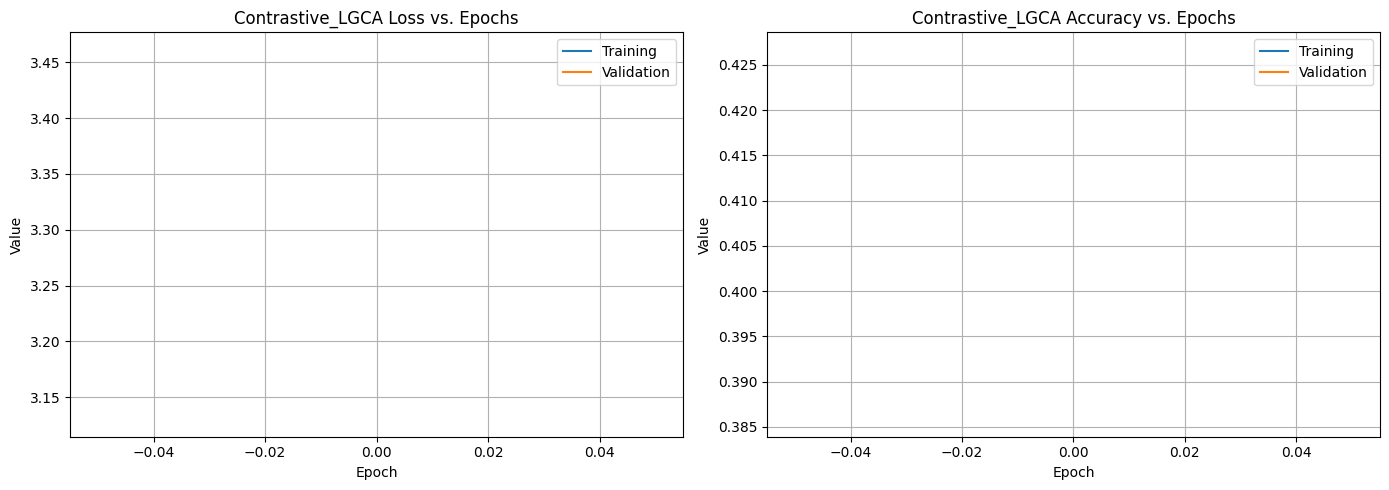

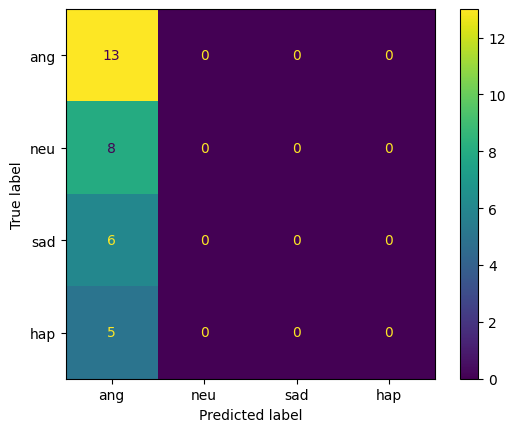

In [2]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Subset # Á°Æ‰øùÂØºÂÖ• Subset


from core.config import CONFIG, device
from scripts.tuning import run_hyperparameter_trial
from dataloaders.dataset import EmotionDataset
from contrastive.collator import ContrastiveDataCollator
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from scripts.get_dataloaders import get_contrastive_dataloaders # Êàë‰ª¨Â∞ÜÂ§çÁî®ÂÆÉÁöÑÈÉ®ÂàÜÈÄªËæë

"""
Â±ÇÊ¨°‰∏ÄÔºöÂÜíÁÉüÊµãËØï„ÄÇ
Âè™Áî®‰∏Ä‰∏™ÊâπÊ¨°ÁöÑÊï∞ÊçÆËÆ≠ÁªÉ‰∏Ä‰∏™Âë®ÊúüÔºåÊ£ÄÊü•‰ª£Á†ÅËÉΩÂê¶Ë∑ëÈÄö„ÄÇ
"""
print("\n========== [Â±ÇÊ¨°‰∏ÄÔºöÂÜí-ÁÉü-Êµã-ËØï] ==========")

# 1. Âä†ËΩΩÈÖçÁΩÆ
CONFIG.load_config("config.yaml")

# 2. ÂáÜÂ§á‰∏Ä‰∏™‚ÄúÂæÆÂûã‚ÄùÊï∞ÊçÆÈõÜ
print("ÂáÜÂ§áÂæÆÂûãÊï∞ÊçÆÈõÜ‰∏≠...")
# ÂÖàËé∑ÂèñÂÆåÊï¥ÁöÑÊï∞ÊçÆÂä†ËΩΩÂô®Ôºå‰ª•‰æø‰ªé‰∏≠ÊèêÂèñÊï∞ÊçÆ
full_dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
full_train_dataset = full_dataloaders['train'].dataset

# ÂàõÂª∫‰∏Ä‰∏™Âè™ÂåÖÂê´32‰∏™Ê†∑Êú¨ÁöÑÂ≠êÈõÜ
micro_dataset = Subset(full_train_dataset, indices=range(32))

# ÂàõÂª∫ÂæÆÂûãÊï∞ÊçÆÂä†ËΩΩÂô®
# Ê≥®ÊÑèÔºöËøôÈáåÁöÑ collate_fn ÈúÄË¶Å‰ªéÂÆåÊï¥Âä†ËΩΩÂô®‰∏≠Ëé∑Âèñ
micro_loader = DataLoader(
    micro_dataset,
    batch_size=CONFIG.dataloader_dict()['batch_size'],
    collate_fn=full_dataloaders['train'].collate_fn
)

# 3. ‰∏¥Êó∂‰øÆÊîπÈÖçÁΩÆÔºåÂè™ËÆ≠ÁªÉ1‰∏™Âë®Êúü
class TempConfig(CONFIG):
    @classmethod
    def training_epochs(cls):
        return 1 # Âè™ËÆ≠ÁªÉ1ËΩÆ
        
# 4. Ë∞ÉÁî®ÂáΩÊï∞ËøõË°åÊµãËØï
try:
    # ÂØπ‰∫éÂÜíÁÉüÊµãËØïÔºåËÆ≠ÁªÉÈõÜÂíåÈ™åËØÅÈõÜÂèØ‰ª•‰ΩøÁî®Âêå‰∏Ä‰∏™ÂæÆÂûãÂä†ËΩΩÂô®
    uar, war = run_hyperparameter_trial(
        alpha_value=0.5,
        train_loader=micro_loader,
        validation_loader=micro_loader,
        config=TempConfig
    )
    print("\n[ÊàêÂäü] ‚úÖ ÂÜíÁÉüÊµãËØïÈÄöËøáÔºÅÂáΩÊï∞ÊàêÂäüÊâßË°åÂπ∂ËøîÂõû‰∫ÜÁªìÊûú„ÄÇ")
    print(f"ËøîÂõûÁöÑÊåáÊ†á: UAR={uar}, WAR={war}")
    
except Exception as e:
    print(f"\n[Â§±Ë¥•] ‚ùå ÂÜíÁÉüÊµãËØïÂ§±Ë¥•ÔºÅ‰ª£Á†ÅÂú®ÊâßË°åËøáÁ®ã‰∏≠Â¥©Ê∫É„ÄÇ")
    print(f"ÈîôËØØ‰ø°ÊÅØ: {e}")


## ÊúâÊïàÊÄßÊµãËØï
end to end validation
- ËßÇÂØüËÆ≠ÁªÉËøáÁ®ã‰∏≠ÁöÑlossÊòØÂê¶Âú®**Á®≥Ê≠•‰∏ãÈôç**„ÄÇ
- Ê£ÄÊü•ÂáΩÊï∞ÁªìÊùüÊó∂ËøîÂõûÁöÑ`uar`Âíå`war`ÊòØÂê¶ÊòØÂêàÁêÜÁöÑÊµÆÁÇπÊï∞ÂÄºÔºà‰æãÂ¶ÇÔºåÂú®0Âíå1‰πãÈó¥Ôºâ„ÄÇ
- Ê£ÄÊü•Ë∞ÉÁî®ÂÆÉÁöÑ‰∏ªÂæ™ÁéØÊòØÂê¶ËÉΩÊ≠£Á°ÆÊé•Êî∂Ëøô‰∏§‰∏™ÂÄºÂπ∂ÊâìÂç∞ÊàñËÆ∞ÂΩï‰∏ãÊù•„ÄÇ

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Subset # Á°Æ‰øùÂØºÂÖ• Subset


from core.config import CONFIG, device
from scripts.tuning import run_hyperparameter_trial
from dataloaders.dataset import EmotionDataset
from contrastive.collator import ContrastiveDataCollator
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from scripts.get_dataloaders import get_contrastive_dataloaders 
"""
Â±ÇÊ¨°‰∫åÔºöÁ´ØÂà∞Á´ØÊúâÊïàÊÄßÈ™åËØÅ„ÄÇ
‰ΩøÁî®ÂÆåÊï¥Êï∞ÊçÆÔºåËÆ≠ÁªÉÂ∞ëÈáèÂë®ÊúüÔºåÈ™åËØÅloss‰∏ãÈôç‰∏îÊåáÊ†áËÉΩË¢´Ê≠£Á°ÆËÆ∞ÂΩï„ÄÇ
"""
print("\n========== [Â±ÇÊ¨°‰∫åÔºöÁ´Ø-Âà∞-Á´Ø-Êúâ-Êïà-ÊÄß-È™å-ËØÅ] ==========")

# 1. Âä†ËΩΩÈÖçÁΩÆÂíåÂÆåÊï¥Êï∞ÊçÆÈõÜ
CONFIG.load_config("config.yaml")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

# # 2. ‰∏¥Êó∂‰øÆÊîπÈÖçÁΩÆÔºåÂè™ËÆ≠ÁªÉ2‰∏™Âë®Êúü
# class TempConfig(CONFIG):
#     @classmethod
#     def training_epochs(cls):
#         return 3 # ËÆ≠ÁªÉ2ËΩÆÔºåË∂≥‰ª•ËßÇÂØüË∂ãÂäø

# 3. ËøêË°åÂçïÊ¨°ËØïÈ™å
try:
    # Áî®‰∏Ä‰∏™Âõ∫ÂÆöÁöÑalphaÂÄºËøõË°åÊµãËØï
    alpha_to_test = 0.5
    uar, war = run_hyperparameter_trial(
        alpha_value=alpha_to_test,
        train_loader=train_loader,
        validation_loader=validation_loader,
        config=CONFIG,
        num_epochs=3,
        gradient_accumulation_steps=1
    )
    
    print("\n[ÊàêÂäü] ‚úÖ Á´ØÂà∞Á´ØÊµãËØïÈÄöËøáÔºÅ")
    
    # 4. Êñ≠Ë®ÄÊ£ÄÊü•ÁªìÊûúÁöÑÊúâÊïàÊÄß
    assert isinstance(uar, float) and 0 <= uar <= 1, "UARÂøÖÈ°ªÊòØ0Âà∞1‰πãÈó¥ÁöÑÊµÆÁÇπÊï∞"
    assert isinstance(war, float) and 0 <= war <= 1, "WARÂøÖÈ°ªÊòØ0Âà∞1‰πãÈó¥ÁöÑÊµÆÁÇπÊï∞"
    print(f"ËøîÂõûÁöÑÊåáÊ†áÁ±ªÂûãÂíåËåÉÂõ¥Ê≠£Á°Æ: UAR={uar:.4f}, WAR={war:.4f}")
    
    # 5. Ê®°ÊãüÊó•ÂøóËÆ∞ÂΩï
    results_df = pd.DataFrame([{'alpha': alpha_to_test, 'uar': uar, 'war': war}])
    print("Êó•ÂøóËÆ∞ÂΩïÊ®°ÊãüÊàêÂäüÔºåÊï∞ÊçÆÂ¶Ç‰∏ã:")
    print(results_df)

except Exception as e:
    print(f"\n[Â§±Ë¥•] ‚ùå Á´ØÂà∞Á´ØÊµãËØïÂ§±Ë¥•ÔºÅ")
    print(f"ÈîôËØØ‰ø°ÊÅØ: {e}")


========== [Â±ÇÊ¨°‰∫åÔºöÁ´Ø-Âà∞-Á´Ø-Êúâ-Êïà-ÊÄß-È™å-ËØÅ] ==========
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ
[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ

--- [ËØïÈ™åÂºÄÂßã] Alpha: 0.5 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 1, ÊçüÂ§±ÊùÉÈáç alpha: 0.5
ÂºÄÂßãËÆ≠ÁªÉ...


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 0/1796 [00:06<?, ?it/s, acc=0, ce=1.43, loss=5.58, sup_con=8.3]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000021614BDA980>
Traceback (most recent call last):
  File "e:\Unitec\SER\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "e:\Unitec\SER\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 32/1796 [00:54<48:32,  1.65s/it, acc=0.5, ce=1.26, loss=2.07, sup_con=1.63]  

## ËøáÊãüÂêàÊµãËØï
overfit test
- ËÆ≠ÁªÉÊçüÂ§±ÔºàTraining LossÔºâÂ∫îËØ•**ÊåÅÁª≠„ÄÅÊòæËëóÂú∞‰∏ãÈôç**ÔºåÊúÄÁªàË∂ãËøë‰∫é0„ÄÇ
- ËÆ≠ÁªÉÂáÜÁ°ÆÁéáÔºàTraining Accuracy/UARÔºâÂ∫îËØ•**Á®≥Ê≠•‰∏äÂçá**ÔºåÊúÄÁªàËææÂà∞**100%ÊàñÈùûÂ∏∏Êé•Ëøë100%**„ÄÇ

e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



========== [Â±ÇÊ¨°‰∏âÔºöËøá-Êãü-Âêà-Êµã-ËØï] ==========
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ
[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
label of this batch:tensor([3, 0])
ÂáÜÂ§áÂçï‰∏™ÊâπÊ¨°Êï∞ÊçÆÂÆåÊàêÔºåÊâπÊ¨°Â§ßÂ∞è: 2

--- [ËØïÈ™åÂºÄÂßã] Alpha: 0.5 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 1, ÊçüÂ§±ÊùÉÈáç alpha: 0.5
ÂºÄÂßãËÆ≠ÁªÉ...


Epoch 100 [ËÆ≠ÁªÉ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  2.66it/s, acc=1, ce=0.216, loss=0.218, sup_con=0.0023]


ËÆ≠ÁªÉÂÆåÊàê„ÄÇ
Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 12.30it/s]

Accuracy (WAR): 1.0000
UAR: 1.0000
ËØïÈ™åÂÆåÊàê: alpha=0.5, UAR=1.0000, WAR=1.0000

[ÊàêÂäü] ‚úÖ ËøáÊãüÂêàÊµãËØïÊâßË°åÂÆåÊØï„ÄÇ
ÊúÄÁªàÂáÜÁ°ÆÁéá (WAR) = 1.0000ÔºåÊ®°ÂûãÊàêÂäüËøáÊãüÂêàÔºåÂÖ∑Â§áÊúâÊïàÂ≠¶‰π†ËÉΩÂäõÔºÅ


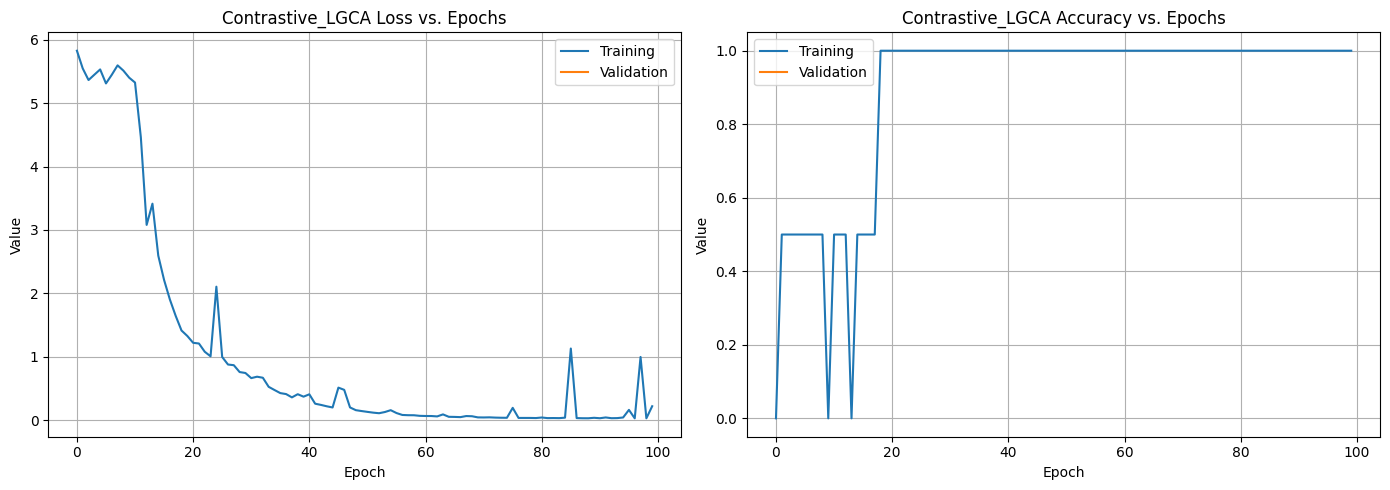

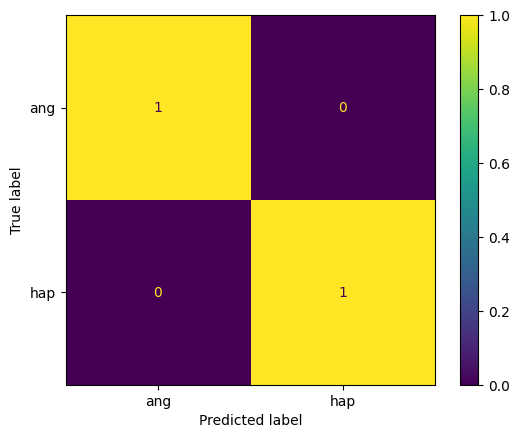

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader, Subset # Á°Æ‰øùÂØºÂÖ• Subset


from core.config import CONFIG, device
from scripts.tuning import run_hyperparameter_trial
from dataloaders.dataset import EmotionDataset
from contrastive.collator import ContrastiveDataCollator
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from scripts.get_dataloaders import get_contrastive_dataloaders 
"""
Â±ÇÊ¨°‰∏âÔºöËøáÊãüÂêàÊµãËØï„ÄÇ
Âú®Âçï‰∏™ÊâπÊ¨°‰∏äËøõË°åÂ§öËΩÆËÆ≠ÁªÉÔºåÈ™åËØÅÊ®°ÂûãÂ≠¶‰π†ËÉΩÂäõ„ÄÇ
"""
print("\n========== [Â±ÇÊ¨°‰∏âÔºöËøá-Êãü-Âêà-Êµã-ËØï] ==========")

# 1. Âä†ËΩΩÈÖçÁΩÆÂπ∂ÂáÜÂ§á‰∏Ä‰∏™‚ÄúÂçïÊâπÊ¨°‚ÄùÊï∞ÊçÆÈõÜ
CONFIG.load_config("config.yaml")
full_dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())

# ‰ªéÂÆåÊï¥ËÆ≠ÁªÉÈõÜ‰∏≠ÂèñÂá∫‰∏Ä‰∏™ÊâπÊ¨°ÁöÑÊï∞ÊçÆ
single_batch = next(iter(full_dataloaders['train']))
print(f"label of this batch:{single_batch['labels']}")

# Â∞ÜËøô‰∏™ÂçïÊâπÊ¨°Êï∞ÊçÆÂåÖË£ÖÊàê‰∏Ä‰∏™‚Äú‰º™‚ÄùÂä†ËΩΩÂô®
# ËøôÊ†∑ÔºåÊØè‰∏™epochÁöÑËÆ≠ÁªÉÂíåÈ™åËØÅÈÉΩÂè™‰ΩøÁî®Ëøô‰∏Ä‰∏™ÊâπÊ¨°
mini_loader = [single_batch] 

print(f"ÂáÜÂ§áÂçï‰∏™ÊâπÊ¨°Êï∞ÊçÆÂÆåÊàêÔºåÊâπÊ¨°Â§ßÂ∞è: {len(single_batch['labels'])}")

# # 2. ‰∏¥Êó∂‰øÆÊîπÈÖçÁΩÆÔºåËøõË°åÂ§öËΩÆËÆ≠ÁªÉ
# class TempConfig(CONFIG):
#     @classmethod
#     def training_epochs(cls):
#         return 100 # ËøõË°åË∂≥Â§üÂ§öÁöÑËΩÆÊ¨°‰ª•ËææÂà∞ËøáÊãüÂêà

# 3. ËøêË°åËøáÊãüÂêàËØïÈ™å
try:
    final_uar, final_war = run_hyperparameter_trial(
        alpha_value=0.5,
        train_loader=mini_loader,
        validation_loader=mini_loader, # ËÆ≠ÁªÉÂíåÈ™åËØÅÈÉΩÁî®Âêå‰∏Ä‰∏™ÊâπÊ¨°
        config=CONFIG,
        num_epochs=100, # ËøõË°åË∂≥Â§üÂ§öÁöÑËΩÆÊ¨°
        gradient_accumulation_steps=1 # <-- ÂÖ≥ÈîÆ‰øÆÊ≠£ÔºöÂº∫Âà∂ËÆæ‰∏∫1ÔºåÁ°Æ‰øùÊùÉÈáçÊõ¥Êñ∞
    )
    
    print("\n[ÊàêÂäü] ‚úÖ ËøáÊãüÂêàÊµãËØïÊâßË°åÂÆåÊØï„ÄÇ")
    
    # 4. È™åËØÅÊòØÂê¶ËææÂà∞‰∫ÜËøáÊãüÂêàÊ†áÂáÜ
    # ÂØπ‰∫éËøáÊãüÂêàÊµãËØïÔºåWARÔºàÂáÜÁ°ÆÁéáÔºâÊòØÊõ¥Áõ¥ËßÇÁöÑÊåáÊ†á
    assert final_war > 0.98, f"ËøáÊãüÂêàÂ§±Ë¥•ÔºÅÊúÄÁªàÂáÜÁ°ÆÁéá {final_war:.4f} Êú™ËææÂà∞98%‰ª•‰∏ä„ÄÇ"
    print(f"ÊúÄÁªàÂáÜÁ°ÆÁéá (WAR) = {final_war:.4f}ÔºåÊ®°ÂûãÊàêÂäüËøáÊãüÂêàÔºåÂÖ∑Â§áÊúâÊïàÂ≠¶‰π†ËÉΩÂäõÔºÅ")

except Exception as e:
    print(f"\n[Â§±Ë¥•] ‚ùå ËøáÊãüÂêàÊµãËØïÂ§±Ë¥•ÔºÅ")
    print(f"ÈîôËØØ‰ø°ÊÅØ: {e}")

# Ë∂ÖÂèÇÊï∞alphaÁΩëÊ†ºÊêúÁ¥¢

## [0.1, 0.5, 1.0, 2.0, 5.0]

### [0.1]Â∑ÆÂàÜÂ≠¶‰π†Áéá

GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñ] ---
ÂÆûÈ™åÁªìÊûúÂ∞ÜÂÆûÊó∂‰øùÂ≠òÂú®: D:/Unitec/SER\tables\alpha_tuning_results_0.1.csv
base_size := 8

--- [Èò∂ÊÆµ‰∫åÔºöÈ¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ] ---
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-11 13:46:24,940 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-11 13:46:24,940 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-11 13:46:24,940 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ

--- [Èò∂ÊÆµ‰∏âÔºöÂºÄÂßãalphaÁΩëÊ†ºÊêúÁ¥¢Âæ™ÁéØ] ---

--- [ËØïÈ™åÂºÄÂßã] Alpha: 0.1 ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-11 13:46:29,489 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Contrastive_LGCA Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 0.1
ÂºÄÂßãËÆ≠ÁªÉ...


Epoch 1 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 113/113 [00:15<00:00,  7.43it/s]
2025-10-11 13:48:00,091 - INFO - Epoch 1 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 1.3826, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.5198, È™åËØÅÊçüÂ§±: 1.1328, È™åËØÅÂáÜÁ°ÆÁéá: 0.5310, È™åËØÅUAR: 0.4674
Epoch 1 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 113/113 [00:15<00:00,  7.43it/s]
2025-10-11 13:48:00,091 - INFO - Epoch 1 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 1.3826, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.5198, È™åËØÅÊçüÂ§±: 1.1328, È™åËØÅÂáÜÁ°ÆÁéá: 0.5310, È™åËØÅUAR: 0.4674
2025-10-11 13:48:01,271 - INFO - Êñ∞ÁöÑÊúÄ‰Ω≥UARÊ®°ÂûãÂ∑≤‰øùÂ≠ò: 0.4674 (Epoch 1) -> D:/Unitec/SER\checkpoints\Contrastive_LGCA_uar_model_epoch_1.pt
2025-10-11 13:48:01,271 - INFO - Êñ∞ÁöÑÊúÄ‰Ω≥UARÊ®°ÂûãÂ∑≤‰øùÂ≠ò: 0.4674 (Epoch 1) -> D:/Unitec/SER\checkpoints\Contrastive_LGCA_uar_model_epoch_1.pt


ËÆ≠ÁªÉÂÆåÊàê„ÄÇ
Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 113/113 [00:15<00:00,  7.47it/s]

Accuracy (WAR): 0.5278
UAR: 0.4674
ËØïÈ™åÂÆåÊàê: alpha=0.1, UAR=0.4674, WAR=0.5278
--- Alpha = 0.1 ÁöÑËØïÈ™åÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---

--- [Èò∂ÊÆµÂõõÔºöÊâÄÊúâËØïÈ™åÂÆåÊàê] ---
ÊúÄÁªàÁöÑË∂ÖÂèÇÊï∞ÊêúÁ¥¢ÁªìÊûú:
   alpha  validation_uar  validation_war
0    0.1         0.46743         0.52784


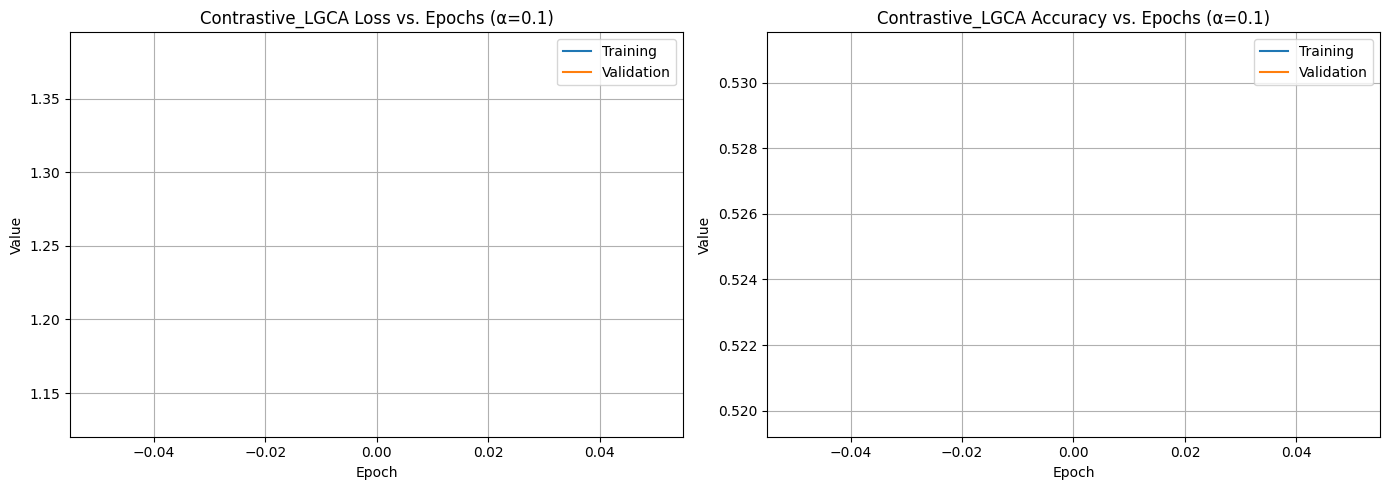

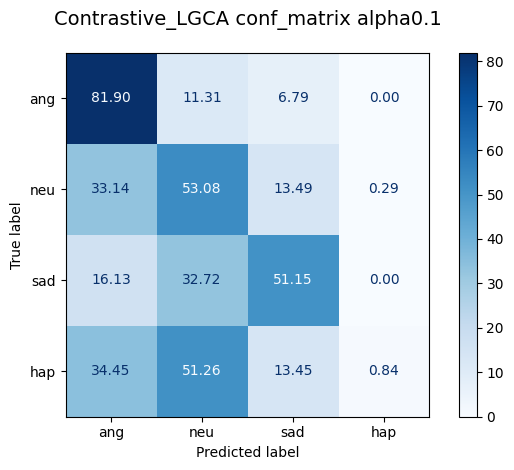

In [ ]:
# main_tuning.py

import torch
import pandas as pd
import os
import gc

# ‰ªéÊÇ®ÁöÑÊ®°Âùó‰∏≠ÂØºÂÖ•ÊâÄÈúÄÁöÑÂ∑•ÂÖ∑
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # <-- ‰ªéÊÇ®ÁöÑÂ∑•ÂÖ∑ÁÆ±ÂØºÂÖ•ÂáΩÊï∞
from contrastive.model import setup_memory_optimization

setup_memory_optimization()

print("--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñ] ---")
CONFIG.load_config("config.yaml")

# alpha_values_to_test = [0.1, 0.5, 1.0, 2.0, 5.0]
alpha_values_to_test = [0.1]
results_list = []
results_filepath = os.path.join(CONFIG.save_tables_location(), "alpha_tuning_results_0.1.csv")
print(f"ÂÆûÈ™åÁªìÊûúÂ∞ÜÂÆûÊó∂‰øùÂ≠òÂú®: {results_filepath}")
print(f"base_size := {CONFIG.dataloader_dict()['batch_size']}")
print("\n--- [Èò∂ÊÆµ‰∫åÔºöÈ¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ] ---")
# ËøôÈáåÁöÑË∞ÉÁî®‰øùÊåÅ‰∏çÂèòÔºåÂÆÉ‰ºöËá™Âä®‰ΩøÁî® use_audio_augmentation=False
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

print("\n--- [Èò∂ÊÆµ‰∏âÔºöÂºÄÂßãalphaÁΩëÊ†ºÊêúÁ¥¢Âæ™ÁéØ] ---")
for alpha in alpha_values_to_test:
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        val_uar, val_war = run_hyperparameter_trial(
            alpha_value=alpha,
            train_loader=train_loader,
            validation_loader=validation_loader,
            config=CONFIG,
            num_epochs=CONFIG.training_epochs(),
            gradient_accumulation_steps=2
        )
        result_entry = {'alpha': alpha, 'validation_uar': val_uar, 'validation_war': val_war}
    except Exception as e:
        print(f"Ë≠¶ÂëäÔºöalpha = {alpha} ÁöÑËØïÈ™åÂõ†ÈîôËØØËÄåÂ§±Ë¥•: {e}")
        result_entry = {'alpha': alpha, 'validation_uar': "Failed", 'validation_war': "Failed"}

    results_list.append(result_entry)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- Alpha = {alpha} ÁöÑËØïÈ™åÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---")

print("\n--- [Èò∂ÊÆµÂõõÔºöÊâÄÊúâËØïÈ™åÂÆåÊàê] ---")
print("ÊúÄÁªàÁöÑË∂ÖÂèÇÊï∞ÊêúÁ¥¢ÁªìÊûú:")
final_results = pd.read_csv(results_filepath)
print(final_results)


### 1.0
ÊâÄÊúâÈü≥È¢ëÈÉΩËØÜÂà´Êàê‰∫Üneu, ‰∏∫‰ªÄ‰πà‰ºöÊòØËøôÊ†∑ÁöÑÁªìÊûúÔºü
Accuracy (WAR): 0.3797
UAR: 0.2500

e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñ] ---
ÂÆûÈ™åÁªìÊûúÂ∞ÜÂÆûÊó∂‰øùÂ≠òÂú®: E:/Unitec/SER/audio\tables\alpha_tuning_results_1.csv
base_size := 4

--- [Èò∂ÊÆµ‰∫åÔºöÈ¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ] ---
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ
[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ

--- [Èò∂ÊÆµ‰∏âÔºöÂºÄÂßãalphaÁΩëÊ†ºÊêúÁ¥¢Âæ™ÁéØ] ---

--- [ËØïÈ™åÂºÄÂßã] Alpha: 1.0 ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
ÂºÄÂßãËÆ≠ÁªÉ...


Epoch 15 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [00:53<00:00,  4.24it/s]


ËÆ≠ÁªÉÂÆåÊàê„ÄÇ
Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [01:35<00:00,  2.36it/s]


Accuracy (WAR): 0.7973
UAR: 0.7793
ËØïÈ™åÂÆåÊàê: alpha=1.0, UAR=0.7793, WAR=0.7973
--- Alpha = 1.0 ÁöÑËØïÈ™åÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---

--- [Èò∂ÊÆµÂõõÔºöÊâÄÊúâËØïÈ™åÂÆåÊàê] ---
ÊúÄÁªàÁöÑË∂ÖÂèÇÊï∞ÊêúÁ¥¢ÁªìÊûú:
   alpha  validation_uar  validation_war
0    1.0        0.779297        0.797327


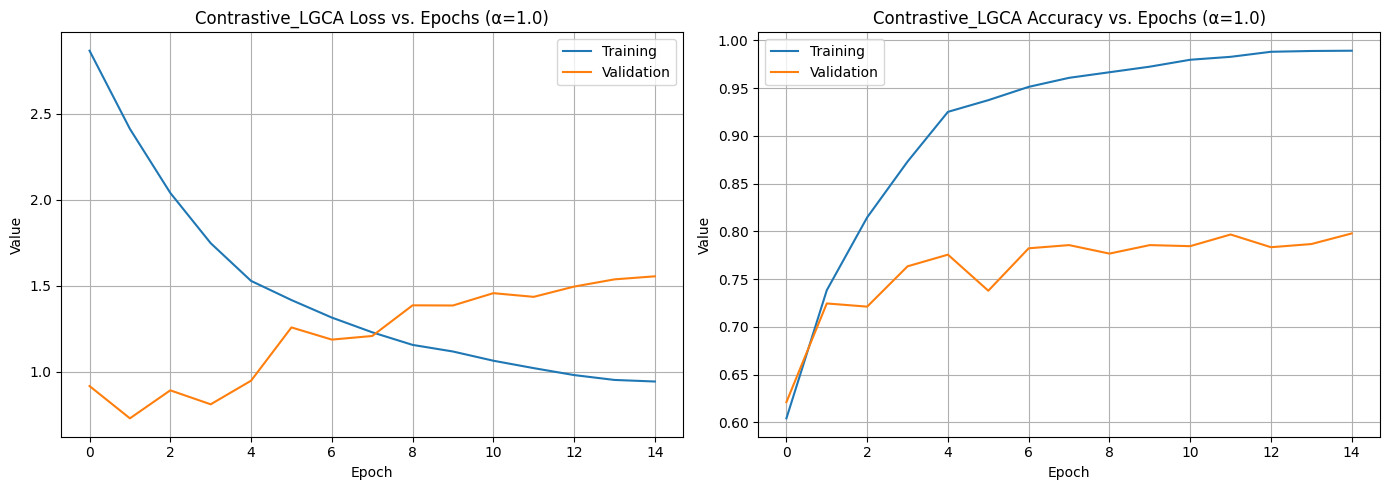

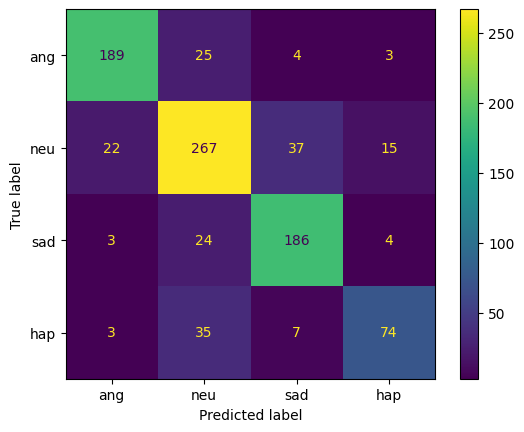

In [1]:
# main_tuning.py

import torch
import pandas as pd
import os
import gc

# ‰ªéÊÇ®ÁöÑÊ®°Âùó‰∏≠ÂØºÂÖ•ÊâÄÈúÄÁöÑÂ∑•ÂÖ∑
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # <-- ‰ªéÊÇ®ÁöÑÂ∑•ÂÖ∑ÁÆ±ÂØºÂÖ•ÂáΩÊï∞
from contrastive.model import setup_memory_optimization

setup_memory_optimization()

# def main_tuning_loop():
"""
ÊâßË°åÂÆåÊï¥ÁöÑË∂ÖÂèÇÊï∞alphaÁΩëÊ†ºÊêúÁ¥¢ÁöÑ‰∏ªÂáΩÊï∞„ÄÇ
"""
# (ËøôÈáåÁöÑ‰ª£Á†ÅÂ∞±ÊòØÊàë‰∏ä‰∏ÄÊù°ÂõûÂ§ç‰∏≠Êèê‰æõÁªôÊÇ®ÁöÑ‰∏ªÂæ™ÁéØ‰ª£Á†Å)
print("--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñ] ---")
CONFIG.load_config("config.yaml")

# alpha_values_to_test = [0.1, 0.5, 1.0, 2.0, 5.0]
alpha_values_to_test = [1.0]
results_list = []
results_filepath = os.path.join(CONFIG.save_tables_location(), "alpha_tuning_results_1.csv")
print(f"ÂÆûÈ™åÁªìÊûúÂ∞ÜÂÆûÊó∂‰øùÂ≠òÂú®: {results_filepath}")
print(f"base_size := {CONFIG.dataloader_dict()['batch_size']}")
print("\n--- [Èò∂ÊÆµ‰∫åÔºöÈ¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

print("\n--- [Èò∂ÊÆµ‰∏âÔºöÂºÄÂßãalphaÁΩëÊ†ºÊêúÁ¥¢Âæ™ÁéØ] ---")
for alpha in alpha_values_to_test:
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        val_uar, val_war = run_hyperparameter_trial(
            alpha_value=alpha,
            train_loader=train_loader,
            validation_loader=validation_loader,
            config=CONFIG,
            num_epochs=CONFIG.training_epochs(),
            gradient_accumulation_steps=2
        )
        result_entry = {'alpha': alpha, 'validation_uar': val_uar, 'validation_war': val_war}
    except Exception as e:
        print(f"Ë≠¶ÂëäÔºöalpha = {alpha} ÁöÑËØïÈ™åÂõ†ÈîôËØØËÄåÂ§±Ë¥•: {e}")
        result_entry = {'alpha': alpha, 'validation_uar': "Failed", 'validation_war': "Failed"}

    results_list.append(result_entry)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- Alpha = {alpha} ÁöÑËØïÈ™åÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---")

print("\n--- [Èò∂ÊÆµÂõõÔºöÊâÄÊúâËØïÈ™åÂÆåÊàê] ---")
print("ÊúÄÁªàÁöÑË∂ÖÂèÇÊï∞ÊêúÁ¥¢ÁªìÊûú:")
final_results = pd.read_csv(results_filepath)
print(final_results)

# # --- ËÑöÊú¨ÊâßË°åÂÖ•Âè£ ---
# if __name__ == '__main__':
#     main_tuning_loop()

### [2.0, 5.0]

--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñ] ---
ÂÆûÈ™åÁªìÊûúÂ∞ÜÂÆûÊó∂‰øùÂ≠òÂú®: E:/Unitec/SER/audio\alpha_tuning_results_2-5.csv
base_size := 4

--- [Èò∂ÊÆµ‰∫åÔºöÈ¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ] ---
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ
[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ

--- [Èò∂ÊÆµ‰∏âÔºöÂºÄÂßãalphaÁΩëÊ†ºÊêúÁ¥¢Âæ™ÁéØ] ---

--- [ËØïÈ™åÂºÄÂßã] Alpha: 2.0 ---
--- [‰øÆÊîπ] Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- [‰øÆÊîπ] Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- [‰øÆÊîπ] Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 1, ÊçüÂ§±ÊùÉÈáç alpha: 2.0
ÂºÄÂßãËÆ≠ÁªÉ...


Epoch 15 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [16:26<00:00,  4.38s/it]


ËÆ≠ÁªÉÂÆåÊàê„ÄÇ
Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [16:46<00:00,  4.48s/it]


Accuracy (WAR): 0.8073
UAR: 0.7779
ËØïÈ™åÂÆåÊàê: alpha=2.0, UAR=0.7779, WAR=0.8073
--- Alpha = 2.0 ÁöÑËØïÈ™åÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---

--- [ËØïÈ™åÂºÄÂßã] Alpha: 5.0 ---
--- [‰øÆÊîπ] Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- [‰øÆÊîπ] Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- [‰øÆÊîπ] Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 1, ÊçüÂ§±ÊùÉÈáç alpha: 5.0
ÂºÄÂßãËÆ≠ÁªÉ...


Epoch 15 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [40:32<00:00, 10.81s/it] 


ËÆ≠ÁªÉÂÆåÊàê„ÄÇ
Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [52:06<00:00, 13.90s/it]  

Accuracy (WAR): 0.7929
UAR: 0.7581
ËØïÈ™åÂÆåÊàê: alpha=5.0, UAR=0.7581, WAR=0.7929
--- Alpha = 5.0 ÁöÑËØïÈ™åÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---

--- [Èò∂ÊÆµÂõõÔºöÊâÄÊúâËØïÈ™åÂÆåÊàê] ---
ÊúÄÁªàÁöÑË∂ÖÂèÇÊï∞ÊêúÁ¥¢ÁªìÊûú:
   alpha  validation_uar  validation_war
0    2.0        0.777880        0.807350
1    5.0        0.758123        0.792873


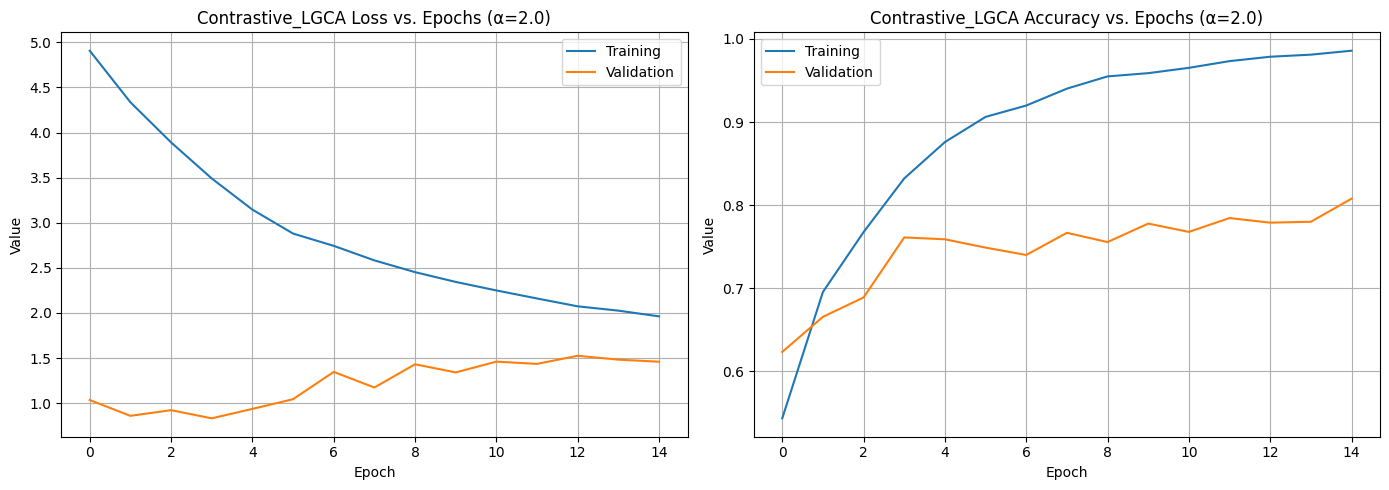

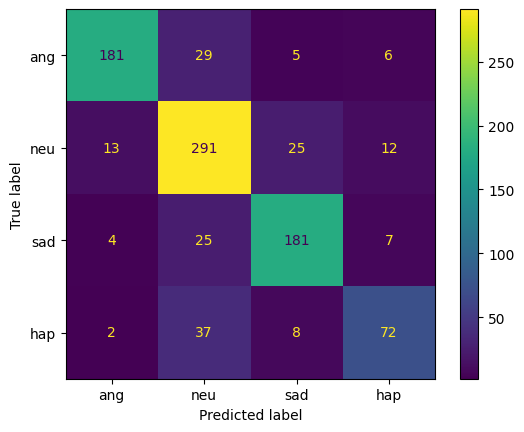

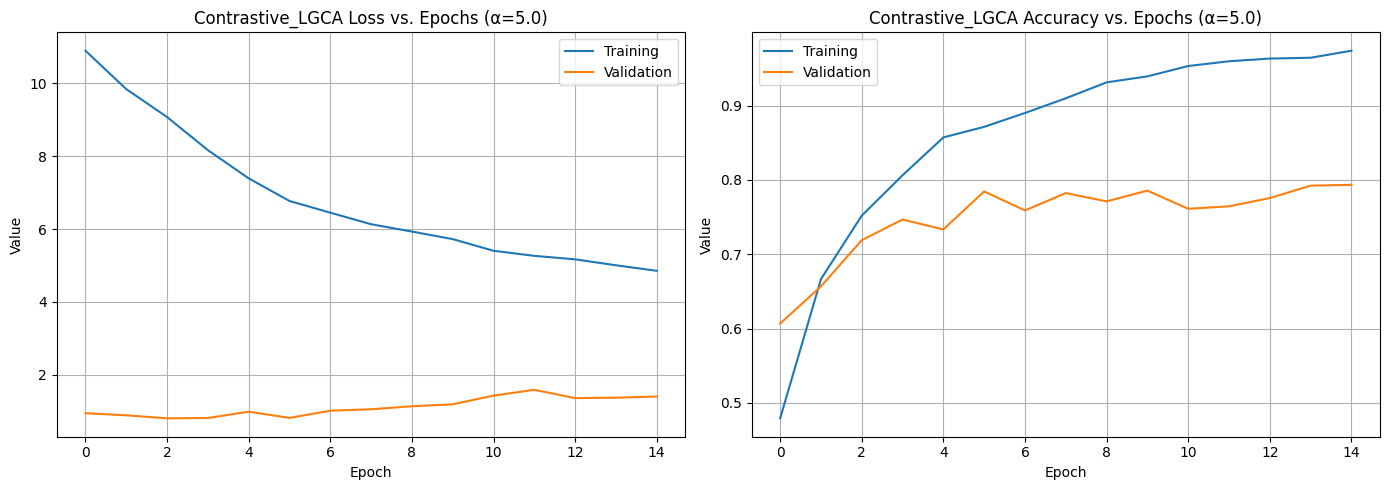

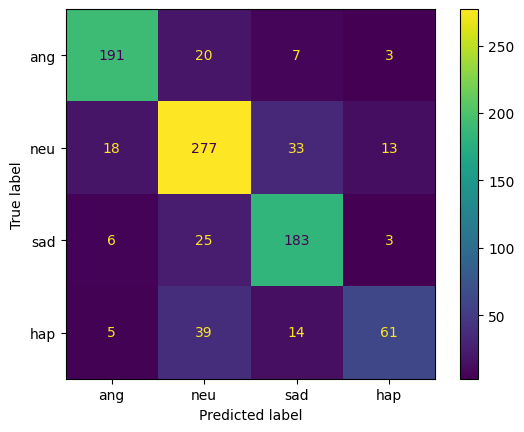

In [2]:
# main_tuning.py

import torch
import pandas as pd
import os
import gc

# ‰ªéÊÇ®ÁöÑÊ®°Âùó‰∏≠ÂØºÂÖ•ÊâÄÈúÄÁöÑÂ∑•ÂÖ∑
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # <-- ‰ªéÊÇ®ÁöÑÂ∑•ÂÖ∑ÁÆ±ÂØºÂÖ•ÂáΩÊï∞

# def main_tuning_loop():
"""
ÊâßË°åÂÆåÊï¥ÁöÑË∂ÖÂèÇÊï∞alphaÁΩëÊ†ºÊêúÁ¥¢ÁöÑ‰∏ªÂáΩÊï∞„ÄÇ
"""
# (ËøôÈáåÁöÑ‰ª£Á†ÅÂ∞±ÊòØÊàë‰∏ä‰∏ÄÊù°ÂõûÂ§ç‰∏≠Êèê‰æõÁªôÊÇ®ÁöÑ‰∏ªÂæ™ÁéØ‰ª£Á†Å)
print("--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñ] ---")
CONFIG.load_config("config.yaml")

# alpha_values_to_test = [0.1, 0.5, 1.0, 2.0, 5.0]
alpha_values_to_test = [2.0, 5.0]
results_list = []
results_filepath = os.path.join(CONFIG.project_root(), "alpha_tuning_results_2-5.csv")
print(f"ÂÆûÈ™åÁªìÊûúÂ∞ÜÂÆûÊó∂‰øùÂ≠òÂú®: {results_filepath}")
print(f"base_size := {CONFIG.dataloader_dict()['batch_size']}")
print("\n--- [Èò∂ÊÆµ‰∫åÔºöÈ¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

print("\n--- [Èò∂ÊÆµ‰∏âÔºöÂºÄÂßãalphaÁΩëÊ†ºÊêúÁ¥¢Âæ™ÁéØ] ---")
for alpha in alpha_values_to_test:
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        val_uar, val_war = run_hyperparameter_trial(
            alpha_value=alpha,
            train_loader=train_loader,
            validation_loader=validation_loader,
            config=CONFIG,
            num_epochs=CONFIG.training_epochs(),
            gradient_accumulation_steps=1
        )
        result_entry = {'alpha': alpha, 'validation_uar': val_uar, 'validation_war': val_war}
    except Exception as e:
        print(f"Ë≠¶ÂëäÔºöalpha = {alpha} ÁöÑËØïÈ™åÂõ†ÈîôËØØËÄåÂ§±Ë¥•: {e}")
        result_entry = {'alpha': alpha, 'validation_uar': "Failed", 'validation_war': "Failed"}

    results_list.append(result_entry)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- Alpha = {alpha} ÁöÑËØïÈ™åÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---")

print("\n--- [Èò∂ÊÆµÂõõÔºöÊâÄÊúâËØïÈ™åÂÆåÊàê] ---")
print("ÊúÄÁªàÁöÑË∂ÖÂèÇÊï∞ÊêúÁ¥¢ÁªìÊûú:")
final_results = pd.read_csv(results_filepath)
print(final_results)

# # --- ËÑöÊú¨ÊâßË°åÂÖ•Âè£ ---
# if __name__ == '__main__':
#     main_tuning_loop()

### Ë∂ÖÂèÇÊï∞1.0Á®≥ÂÆöÊÄßÈ™åËØÅ
1. ÂÆûÈ™åËÆæÁΩÆ
ÊÄùËÄÉËøáÁ®ãÔºöÊàë‰ª¨ÈúÄË¶ÅÊòéÁ°ÆÂÆö‰πâÂÆûÈ™åÁöÑÂõ∫ÂÆöÂèÇÊï∞ÂíåÂèØÂèòÂèÇÊï∞„ÄÇ
ÂéüÁêÜÔºöËøôÊòØÊéßÂà∂ÂèòÈáèÊ≥ï„ÄÇalphaÊòØÂõ∫ÂÆöÁöÑÔºåËÄåÈöèÊú∫ÁßçÂ≠êÊòØÂîØ‰∏ÄÁöÑÂèòÈáè„ÄÇ
2. È¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ ====================
ÊÄùËÄÉËøáÁ®ãÔºö‰∏é‰∏äÊ¨°‰∏ÄÊ†∑Ôºå‰∏∫‰∫ÜÊïàÁéáÔºåÊï∞ÊçÆÂè™ÈúÄÂä†ËΩΩ‰∏ÄÊ¨°„ÄÇ
ÂéüÁêÜÔºöÂàÜÁ¶ªÂáÜÂ§á‰∏éÊâßË°åÔºåÈÅøÂÖçÂú®Âæ™ÁéØ‰∏≠ËøõË°åÈáçÂ§çÁöÑI/OÊìç‰Ωú„ÄÇ
3. ÊâßË°åÈáçÂ§çÂÆûÈ™åÂæ™ÁéØ ====================
ÊÄùËÄÉËøáÁ®ãÔºöÂ¶Ç‰ΩïËÆ©ÊØèÊ¨°ËøêË°åÈÉΩ‚Äú‰∏çÂêå‚Äù‰ΩÜÂèà‚ÄúÂèØÂ§çÁé∞‚ÄùÔºüÁ≠îÊ°àÊòØ‰ΩøÁî®‰∏çÂêåÁöÑÈöèÊú∫ÁßçÂ≠ê„ÄÇ
ÂéüÁêÜÔºöËÆæÁΩÆÈöèÊú∫ÁßçÂ≠êÂèØ‰ª•Âõ∫ÂÆöÊâÄÊúâ‰º™ÈöèÊú∫ËøáÁ®ãÔºàÊùÉÈáçÂàùÂßãÂåñ„ÄÅÊï∞ÊçÆÊâì‰π±Á≠âÔºâÔºå‰ΩøÂæóÂÆûÈ™åËøáÁ®ãÂèòÂæóÁ°ÆÂÆö„ÄÇ
ÊØèÊ¨°‰ΩøÁî®‰∏çÂêåÁöÑÁßçÂ≠êÔºåÂ∞±ËÉΩÊ®°Êãü‰∏ÄÊ¨°Áã¨Á´ãÁöÑÈöèÊú∫ÂÆûÈ™å„ÄÇ
4. ÁªìÊûúÂàÜÊûê‰∏éÊÄªÁªì
ÊÄùËÄÉËøáÁ®ãÔºöÂ¶Ç‰Ωï‰ªéÂ§öÊ¨°ËøêË°åÁöÑÁªìÊûú‰∏≠ÂæóÂá∫‰∏Ä‰∏™ÊúâÊÑè‰πâÁöÑÁªìËÆ∫Ôºü
ÂéüÁêÜÔºö‰ΩøÁî®ÊèèËø∞ÊÄßÁªüËÆ°ÔºàÂùáÂÄºÂíåÊ†áÂáÜÂ∑ÆÔºâÊù•ÊÄªÁªìÁªìÊûúÁöÑÈõÜ‰∏≠Ë∂ãÂäøÂíåÁ¶ªÊï£Á®ãÂ∫¶„ÄÇ

GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñÂÆûÈ™åËÆæÁΩÆ] ---
ÊúÄ‰ºò Alpha: 1.0
Áã¨Á´ãËøêË°åÊ¨°Êï∞: 3
ÁªìÊûúÂ∞Ü‰øùÂ≠òÂú®: E:/Unitec/SER/audio\tables\alpha_1.0_stability_results.csv

--- [Èò∂ÊÆµ‰∫åÔºöÈ¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ] ---
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ
[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ

--- [Èò∂ÊÆµ‰∏âÔºöÂºÄÂßãÁ®≥ÂÆöÊÄßÈ™åËØÅÂæ™ÁéØ] ---

--- [ËøêË°å 1/3] ‰ΩøÁî®ÈöèÊú∫ÁßçÂ≠ê: 42 ---

--- [ËØïÈ™åÂºÄÂßã] Alpha: 1.0 ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
ÂºÄÂßãËÆ≠ÁªÉ...


Epoch 15 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [00:24<00:00,  9.31it/s]


ËÆ≠ÁªÉÂÆåÊàê„ÄÇ
Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [00:23<00:00,  9.40it/s]


Accuracy (WAR): 0.8129
UAR: 0.7864
ËØïÈ™åÂÆåÊàê: alpha=1.0, UAR=0.7864, WAR=0.8129
--- ËøêË°å 1 ÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---

--- [ËøêË°å 2/3] ‰ΩøÁî®ÈöèÊú∫ÁßçÂ≠ê: 43 ---

--- [ËØïÈ™åÂºÄÂßã] Alpha: 1.0 ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
ÂºÄÂßãËÆ≠ÁªÉ...


Epoch 15 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [00:25<00:00,  8.98it/s]


ËÆ≠ÁªÉÂÆåÊàê„ÄÇ
Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [00:25<00:00,  8.89it/s]


Accuracy (WAR): 0.7996
UAR: 0.7719
ËØïÈ™åÂÆåÊàê: alpha=1.0, UAR=0.7719, WAR=0.7996
--- ËøêË°å 2 ÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---

--- [ËøêË°å 3/3] ‰ΩøÁî®ÈöèÊú∫ÁßçÂ≠ê: 44 ---

--- [ËØïÈ™åÂºÄÂßã] Alpha: 1.0 ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
ÂºÄÂßãËÆ≠ÁªÉ...


Epoch 15 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [00:16<00:00, 14.05it/s]


ËÆ≠ÁªÉÂÆåÊàê„ÄÇ
Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 225/225 [00:15<00:00, 14.27it/s]

Accuracy (WAR): 0.7895
UAR: 0.7660
ËØïÈ™åÂÆåÊàê: alpha=1.0, UAR=0.7660, WAR=0.7895
--- ËøêË°å 3 ÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---

--- [Èò∂ÊÆµÂõõÔºöÊâÄÊúâËøêË°åÂÆåÊàêÔºåËøõË°åÁªüËÆ°ÂàÜÊûê] ---
ÊúÄÁªàÁ®≥ÂÆöÊÄßÈ™åËØÅÁªìÊûúÊ±áÊÄª:
   run  seed       uar       war
0    1    42  0.786430  0.812918
1    2    43  0.771920  0.799555
2    3    44  0.765956  0.789532

ÁªüËÆ°ÂàÜÊûê:
Âπ≥Âùá UAR: 0.7748 ¬± 0.0105
Âπ≥Âùá WAR: 0.8007 ¬± 0.0117

[ÁªìËÆ∫] ‚úÖ ÁªìÊûúÈùûÂ∏∏Á®≥ÂÆö„ÄÇÂèØ‰ª•Êª°ÊÄÄ‰ø°ÂøÉÂú∞ËøõÂÖ•‰∏ã‰∏ÄÈò∂ÊÆµ„ÄÇ


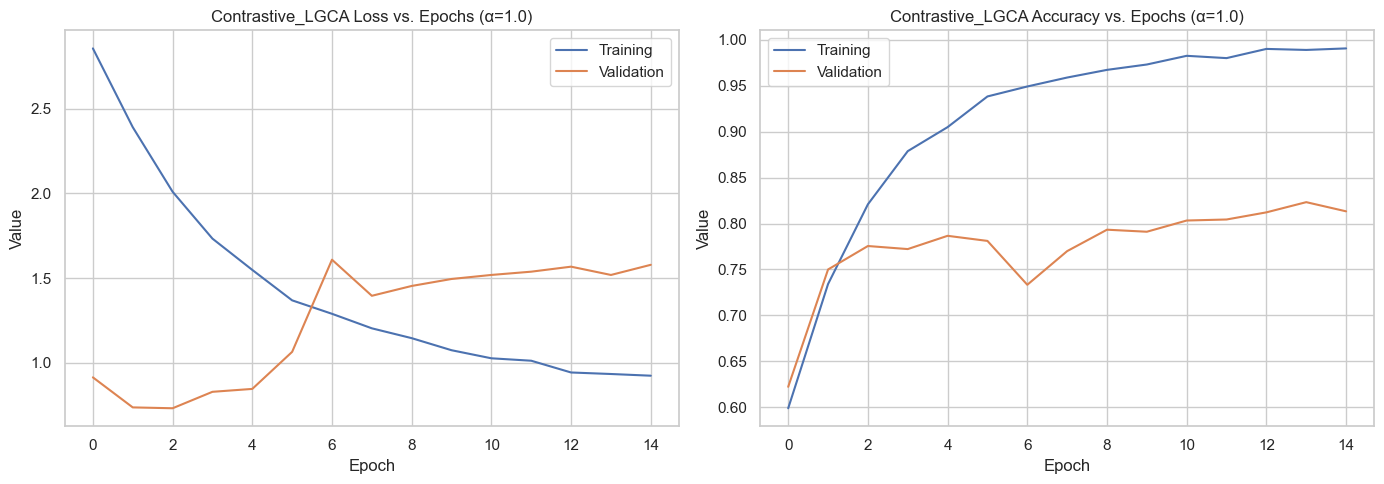

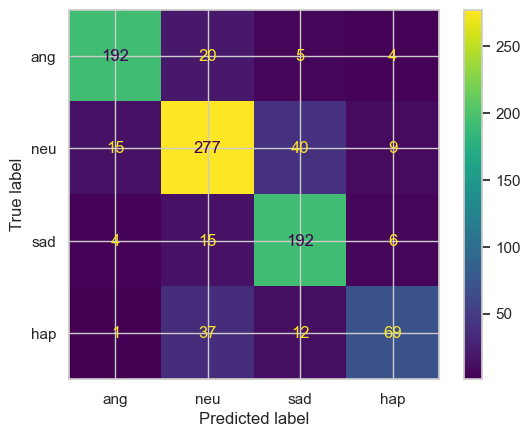

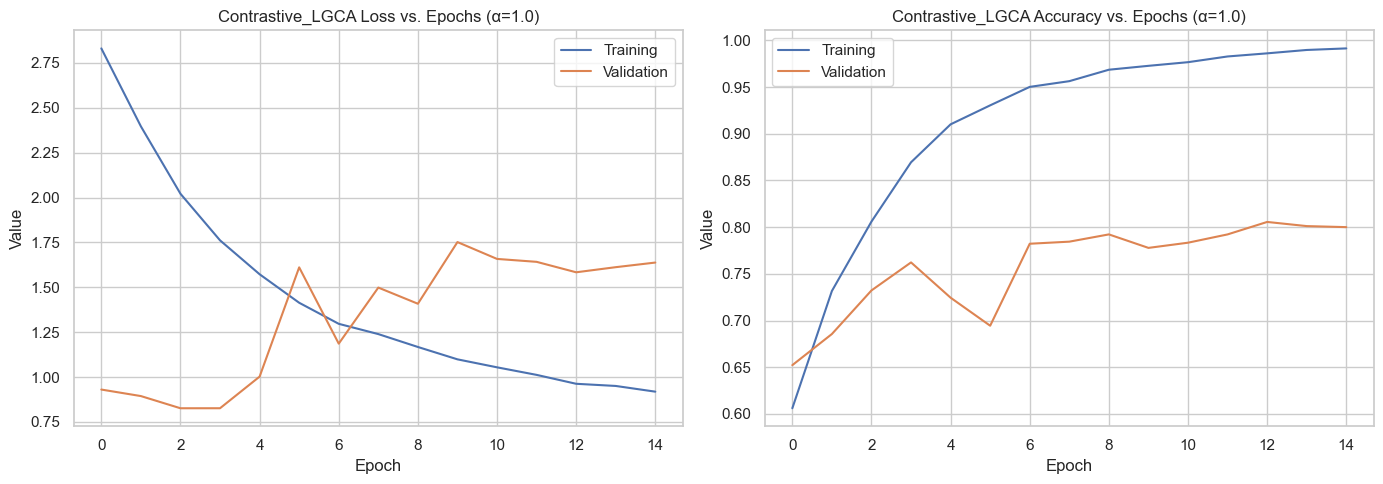

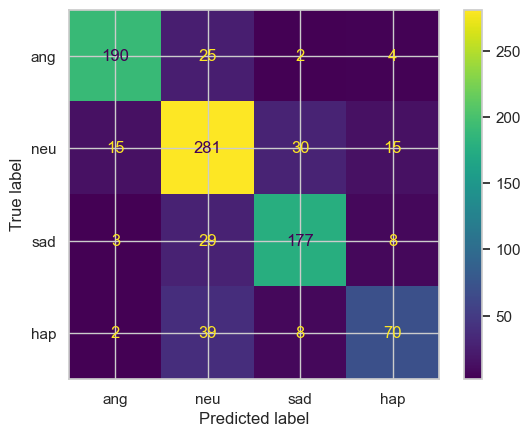

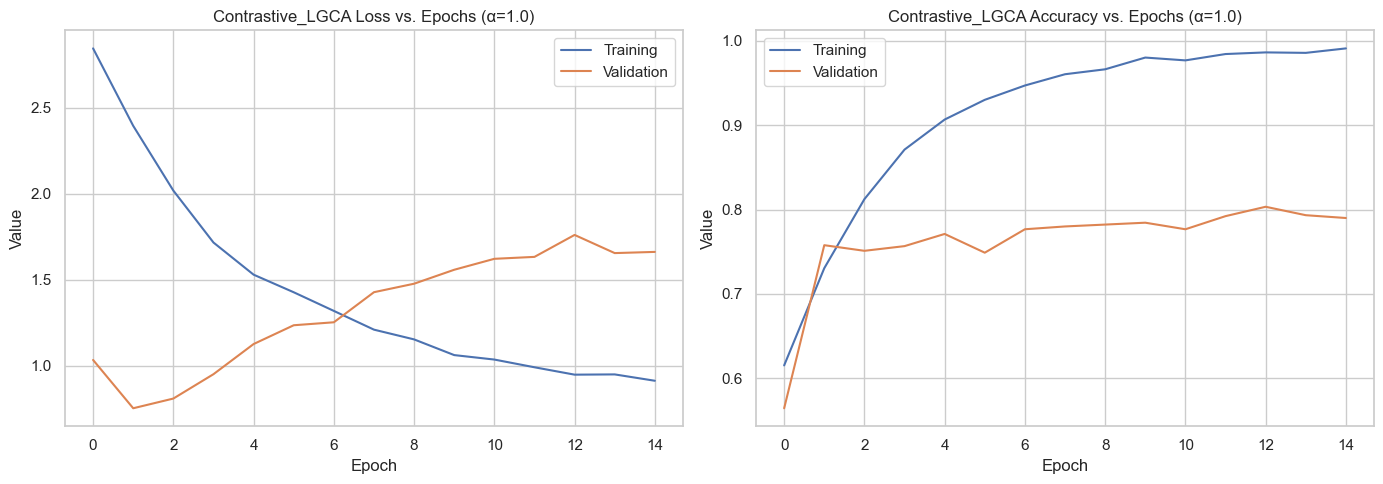

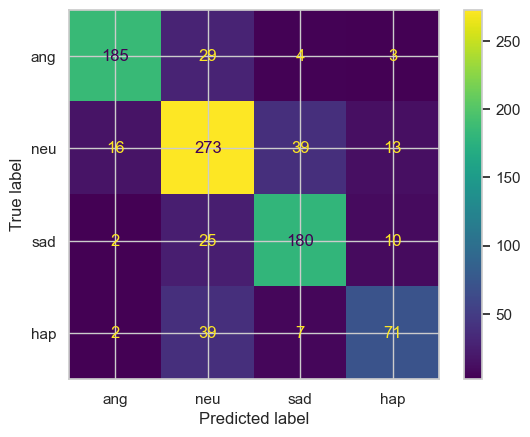

In [ ]:
# main_stability_test.py

import torch
import pandas as pd
import numpy as np
import os
import gc

# ÂØºÂÖ•ÊÇ®È°πÁõÆ‰∏≠ÁöÑÊ†∏ÂøÉÊ®°Âùó
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # Â§çÁî®Êàë‰ª¨Â∑≤ÁªèÈ™åËØÅËøáÁöÑÂÆûÈ™åÂáΩÊï∞
from contrastive.model import setup_memory_optimization

setup_memory_optimization()
def setup_mixed_precision_environment():
    """ËÆæÁΩÆÊ∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉÁéØÂ¢É"""
    print("--- ËÆæÁΩÆÊ∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉÁéØÂ¢É ---")
    
    # ËÆæÁΩÆCUDA‰ºòÂåñ
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512,expandable_segments:True'
    
    # Ê∏ÖÁêÜÊòæÂ≠ò
    torch.cuda.empty_cache()
    gc.collect()
    
    # Ê£ÄÊü•ÊòæÂ≠ò
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"GPUÊÄªÊòæÂ≠ò: {total_memory:.2f}GB")
        print(f"ÂΩìÂâçÂèØÁî®ÊòæÂ≠ò: {(total_memory - torch.cuda.memory_allocated()/1e9):.2f}GB")
    
    print("Ê∑∑ÂêàÁ≤æÂ∫¶ÁéØÂ¢ÉËÆæÁΩÆÂÆåÊàê")

setup_mixed_precision_environment()
"""
ÂØπÊúÄ‰ºòalphaÂÄºËøõË°åÂ§öÊ¨°Áã¨Á´ãÈáçÂ§çÂÆûÈ™åÔºå‰ª•È™åËØÅÂÖ∂ÊÄßËÉΩÁöÑÁ®≥ÂÆöÊÄß„ÄÇ
"""
# ==================== 1. ÂÆûÈ™åËÆæÁΩÆ ====================
print("--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñÂÆûÈ™åËÆæÁΩÆ] ---")
CONFIG.load_config("config.yaml")

OPTIMAL_ALPHA = 1.0  # ËøôÊòØÊàë‰ª¨‰ªéÁΩëÊ†ºÊêúÁ¥¢‰∏≠Á°ÆÂÆöÁöÑÊúÄ‰ºòalpha
NUM_RUNS = 3         # Áã¨Á´ãÈáçÂ§çÂÆûÈ™åÁöÑÊ¨°Êï∞„ÄÇ3-5Ê¨°ÊòØÂ≠¶ÊúØÁïåÊôÆÈÅçÊé•ÂèóÁöÑÊäòË°∑ÊñπÊ°à„ÄÇ

results_list = []
results_filepath = os.path.join(CONFIG.save_tables_location(), f"alpha_{OPTIMAL_ALPHA}_stability_results.csv")
print(f"ÊúÄ‰ºò Alpha: {OPTIMAL_ALPHA}")
print(f"Áã¨Á´ãËøêË°åÊ¨°Êï∞: {NUM_RUNS}")
print(f"ÁªìÊûúÂ∞Ü‰øùÂ≠òÂú®: {results_filepath}")

# ==================== 2. È¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ ====================
print("\n--- [Èò∂ÊÆµ‰∫åÔºöÈ¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

# ==================== 3. ÊâßË°åÈáçÂ§çÂÆûÈ™åÂæ™ÁéØ ====================
print("\n--- [Èò∂ÊÆµ‰∏âÔºöÂºÄÂßãÁ®≥ÂÆöÊÄßÈ™åËØÅÂæ™ÁéØ] ---")
for i in range(NUM_RUNS):
    # ‰∏∫Êú¨Ê¨°ËøêË°åËÆæÁΩÆ‰∏Ä‰∏™ÂîØ‰∏ÄÁöÑ„ÄÅÂèØÂ§çÁé∞ÁöÑÈöèÊú∫ÁßçÂ≠ê
    seed = 42 + i  # ‰ΩøÁî®‰∏Ä‰∏™Âü∫Êï∞ÔºàÂ¶Ç42ÔºâÂä†‰∏äÂæ™ÁéØÂèòÈáèÔºåÊòØÁÆÄÂçïÊúâÊïàÁöÑÂÅöÊ≥ï
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    print(f"\n--- [ËøêË°å {i+1}/{NUM_RUNS}] ‰ΩøÁî®ÈöèÊú∫ÁßçÂ≠ê: {seed} ---")
    
    # Ë∞ÉÁî®Êàë‰ª¨Â∑≤ÁªèÈ™åËØÅËøáÁöÑÂÆûÈ™åÂáΩÊï∞
    val_uar, val_war = run_hyperparameter_trial(
        alpha_value=OPTIMAL_ALPHA,
        train_loader=train_loader,
        validation_loader=validation_loader,
        config=CONFIG,
        num_epochs=CONFIG.training_epochs(),
        gradient_accumulation_steps=2 # ‰ΩøÁî®ÊÇ®Ê≠£Â∏∏ÁöÑÊ¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞
    )

    

    # ËÆ∞ÂΩïÊú¨Ê¨°ËøêË°åÁöÑÁªìÊûú
    result_entry = {'run': i+1, 'seed': seed, 'uar': val_uar, 'war': val_war}
    results_list.append(result_entry)

    # ÊØèÊ¨°ËøêË°åÂêéÈÉΩ‰øùÂ≠òÔºåÁ°Æ‰øùÊï∞ÊçÆÂÆâÂÖ®
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- ËøêË°å {i+1} ÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---")

# ==================== 4. ÁªìÊûúÂàÜÊûê‰∏éÊÄªÁªì ====================0.
print("\n--- [Èò∂ÊÆµÂõõÔºöÊâÄÊúâËøêË°åÂÆåÊàêÔºåËøõË°åÁªüËÆ°ÂàÜÊûê] ---")
final_results = pd.read_csv(results_filepath)

mean_uar = final_results['uar'].mean()
std_uar = final_results['uar'].std()

mean_war = final_results['war'].mean()
std_war = final_results['war'].std()

print("ÊúÄÁªàÁ®≥ÂÆöÊÄßÈ™åËØÅÁªìÊûúÊ±áÊÄª:")
print(final_results)
print("\nÁªüËÆ°ÂàÜÊûê:")
print(f"Âπ≥Âùá UAR: {mean_uar:.4f} ¬± {std_uar:.4f}")
print(f"Âπ≥Âùá WAR: {mean_war:.4f} ¬± {std_war:.4f}")

if std_uar < 0.02: # ËÆæÁΩÆ‰∏Ä‰∏™ÈòàÂÄºÔºå‰æãÂ¶ÇÊ†áÂáÜÂ∑ÆÂ∞è‰∫é2%
    print("\n[ÁªìËÆ∫] ‚úÖ ÁªìÊûúÈùûÂ∏∏Á®≥ÂÆö„ÄÇÂèØ‰ª•Êª°ÊÄÄ‰ø°ÂøÉÂú∞ËøõÂÖ•‰∏ã‰∏ÄÈò∂ÊÆµ„ÄÇ")
else:
    print("\n[ÁªìËÆ∫] ‚ö†Ô∏è ÁªìÊûúÊ≥¢Âä®ËæÉÂ§ßÔºåÂèØËÉΩÈúÄË¶ÅÊ£ÄÊü•ÂÆûÈ™åËÆæÁΩÆÊàñÂ¢ûÂä†ËøêË°åÊ¨°Êï∞„ÄÇ")


### ÊµãËØïÂ§öÊ£ÄÊü•ÁÇπ

In [1]:
# main_stability_test.py

import torch
import pandas as pd
import numpy as np
import os
import gc

# ÂØºÂÖ•ÊÇ®È°πÁõÆ‰∏≠ÁöÑÊ†∏ÂøÉÊ®°Âùó
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # Â§çÁî®Êàë‰ª¨Â∑≤ÁªèÈ™åËØÅËøáÁöÑÂÆûÈ™åÂáΩÊï∞
from contrastive.model import setup_memory_optimization

setup_memory_optimization()
def setup_mixed_precision_environment():
    """ËÆæÁΩÆÊ∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉÁéØÂ¢É"""
    print("--- ËÆæÁΩÆÊ∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉÁéØÂ¢É ---")
    
    # ËÆæÁΩÆCUDA‰ºòÂåñ
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512,expandable_segments:True'
    
    # Ê∏ÖÁêÜÊòæÂ≠ò
    torch.cuda.empty_cache()
    gc.collect()
    
    # Ê£ÄÊü•ÊòæÂ≠ò
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"GPUÊÄªÊòæÂ≠ò: {total_memory:.2f}GB")
        print(f"ÂΩìÂâçÂèØÁî®ÊòæÂ≠ò: {(total_memory - torch.cuda.memory_allocated()/1e9):.2f}GB")
    
    print("Ê∑∑ÂêàÁ≤æÂ∫¶ÁéØÂ¢ÉËÆæÁΩÆÂÆåÊàê")

setup_mixed_precision_environment()
"""
ÂØπÊúÄ‰ºòalphaÂÄºËøõË°åÂ§öÊ¨°Áã¨Á´ãÈáçÂ§çÂÆûÈ™åÔºå‰ª•È™åËØÅÂÖ∂ÊÄßËÉΩÁöÑÁ®≥ÂÆöÊÄß„ÄÇ
"""
# ==================== 1. ÂÆûÈ™åËÆæÁΩÆ ====================
print("--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñÂÆûÈ™åËÆæÁΩÆ] ---")
CONFIG.load_config("config.yaml")

OPTIMAL_ALPHA = 1.0  # ËøôÊòØÊàë‰ª¨‰ªéÁΩëÊ†ºÊêúÁ¥¢‰∏≠Á°ÆÂÆöÁöÑÊúÄ‰ºòalpha
NUM_RUNS = 1         # Áã¨Á´ãÈáçÂ§çÂÆûÈ™åÁöÑÊ¨°Êï∞„ÄÇ3-5Ê¨°ÊòØÂ≠¶ÊúØÁïåÊôÆÈÅçÊé•ÂèóÁöÑÊäòË°∑ÊñπÊ°à„ÄÇ

results_list = []
results_filepath = os.path.join(CONFIG.save_tables_location(), f"alpha_{OPTIMAL_ALPHA}_stability_results_1.csv")
print(f"ÊúÄ‰ºò Alpha: {OPTIMAL_ALPHA}")
print(f"Áã¨Á´ãËøêË°åÊ¨°Êï∞: {NUM_RUNS}")
print(f"ÁªìÊûúÂ∞Ü‰øùÂ≠òÂú®: {results_filepath}")

# ==================== 2. È¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ ====================
print("\n--- [Èò∂ÊÆµ‰∫åÔºöÈ¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

# ==================== 3. ÊâßË°åÈáçÂ§çÂÆûÈ™åÂæ™ÁéØ ====================
print("\n--- [Èò∂ÊÆµ‰∏âÔºöÂºÄÂßãÁ®≥ÂÆöÊÄßÈ™åËØÅÂæ™ÁéØ] ---")
for i in range(NUM_RUNS):
    # ‰∏∫Êú¨Ê¨°ËøêË°åËÆæÁΩÆ‰∏Ä‰∏™ÂîØ‰∏ÄÁöÑ„ÄÅÂèØÂ§çÁé∞ÁöÑÈöèÊú∫ÁßçÂ≠ê
    seed = 42 + i  # ‰ΩøÁî®‰∏Ä‰∏™Âü∫Êï∞ÔºàÂ¶Ç42ÔºâÂä†‰∏äÂæ™ÁéØÂèòÈáèÔºåÊòØÁÆÄÂçïÊúâÊïàÁöÑÂÅöÊ≥ï
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    print(f"\n--- [ËøêË°å {i+1}/{NUM_RUNS}] ‰ΩøÁî®ÈöèÊú∫ÁßçÂ≠ê: {seed} ---")
    
    # Ë∞ÉÁî®Êàë‰ª¨Â∑≤ÁªèÈ™åËØÅËøáÁöÑÂÆûÈ™åÂáΩÊï∞
    val_uar, val_war = run_hyperparameter_trial(
        alpha_value=OPTIMAL_ALPHA,
        train_loader=train_loader,
        validation_loader=validation_loader,
        config=CONFIG,
        num_epochs=CONFIG.training_epochs(),
        gradient_accumulation_steps=2 # ‰ΩøÁî®ÊÇ®Ê≠£Â∏∏ÁöÑÊ¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞
    )

    

    # ËÆ∞ÂΩïÊú¨Ê¨°ËøêË°åÁöÑÁªìÊûú
    result_entry = {'run': i+1, 'seed': seed, 'uar': val_uar, 'war': val_war}
    results_list.append(result_entry)

    # ÊØèÊ¨°ËøêË°åÂêéÈÉΩ‰øùÂ≠òÔºåÁ°Æ‰øùÊï∞ÊçÆÂÆâÂÖ®
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- ËøêË°å {i+1} ÂÆåÊàê„ÄÇÁªìÊûúÂ∑≤Êõ¥Êñ∞Ëá≥CSVÊñá‰ª∂„ÄÇ ---")

# ==================== 4. ÁªìÊûúÂàÜÊûê‰∏éÊÄªÁªì ====================0.
print("\n--- [Èò∂ÊÆµÂõõÔºöÊâÄÊúâËøêË°åÂÆåÊàêÔºåËøõË°åÁªüËÆ°ÂàÜÊûê] ---")
final_results = pd.read_csv(results_filepath)

mean_uar = final_results['uar'].mean()
std_uar = final_results['uar'].std()

mean_war = final_results['war'].mean()
std_war = final_results['war'].std()

print("ÊúÄÁªàÁ®≥ÂÆöÊÄßÈ™åËØÅÁªìÊûúÊ±áÊÄª:")
print(final_results)
print("\nÁªüËÆ°ÂàÜÊûê:")
print(f"Âπ≥Âùá UAR: {mean_uar:.4f} ¬± {std_uar:.4f}")
print(f"Âπ≥Âùá WAR: {mean_war:.4f} ¬± {std_war:.4f}")

if std_uar < 0.02: # ËÆæÁΩÆ‰∏Ä‰∏™ÈòàÂÄºÔºå‰æãÂ¶ÇÊ†áÂáÜÂ∑ÆÂ∞è‰∫é2%
    print("\n[ÁªìËÆ∫] ‚úÖ ÁªìÊûúÈùûÂ∏∏Á®≥ÂÆö„ÄÇÂèØ‰ª•Êª°ÊÄÄ‰ø°ÂøÉÂú∞ËøõÂÖ•‰∏ã‰∏ÄÈò∂ÊÆµ„ÄÇ")
else:
    print("\n[ÁªìËÆ∫] ‚ö†Ô∏è ÁªìÊûúÊ≥¢Âä®ËæÉÂ§ßÔºåÂèØËÉΩÈúÄË¶ÅÊ£ÄÊü•ÂÆûÈ™åËÆæÁΩÆÊàñÂ¢ûÂä†ËøêË°åÊ¨°Êï∞„ÄÇ")


e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- ËÆæÁΩÆÊ∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉÁéØÂ¢É ---
GPUÊÄªÊòæÂ≠ò: 8.59GB
ÂΩìÂâçÂèØÁî®ÊòæÂ≠ò: 8.59GB
Ê∑∑ÂêàÁ≤æÂ∫¶ÁéØÂ¢ÉËÆæÁΩÆÂÆåÊàê
--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñÂÆûÈ™åËÆæÁΩÆ] ---
ÊúÄ‰ºò Alpha: 1.0
Áã¨Á´ãËøêË°åÊ¨°Êï∞: 1
ÁªìÊûúÂ∞Ü‰øùÂ≠òÂú®: E:/Unitec/SER/audio\tables\alpha_1.0_stability_results_1.csv

--- [Èò∂ÊÆµ‰∫åÔºöÈ¢ÑÂä†ËΩΩÊï∞ÊçÆÈõÜ] ---
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ
[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ

--- [Èò∂ÊÆµ‰∏âÔºöÂºÄÂßãÁ®≥ÂÆöÊÄßÈ™åËØÅÂæ™ÁéØ] ---

--- [ËøêË°å 1/1] ‰ΩøÁî®ÈöèÊú∫ÁßçÂ≠ê: 42 ---

--- [ËØïÈ™åÂºÄÂßã] Alpha: 1.0 ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, Êçü

Epoch 6 [ËÆ≠ÁªÉ‰∏≠]:  23%|‚ñà‚ñà‚ñé       | 211/898 [01:05<03:33,  3.21it/s, acc=1, ce=0.000801, loss=0.664, sup_con=0.663]


KeyboardInterrupt: 

### Ë∂ÖÂèÇÊï∞ÂèØËßÜÂåñ

In [1]:
import pandas as pd
import os

# ÂÅáËÆæÊÇ®ÁöÑCONFIGÁ±ªÂ∑≤ÁªèÂÆö‰πâÂπ∂Âä†ËΩΩ
from core.config import CONFIG
CONFIG.load_config("config.yaml")
# file_name = "alpha_tuning_results.csv"
file_name = "alpha_tuning_results_0.1.csv"

# ÊûÑÂª∫ÁªìÊûúÊñá‰ª∂ÁöÑÂÆåÊï¥Ë∑ØÂæÑ
results_filepath = os.path.join(CONFIG.save_tables_location(), file_name)

# ‰ΩøÁî®PandasÂä†ËΩΩCSVÊñá‰ª∂
try:
    results_df = pd.read_csv(results_filepath)
    print("ÁªìÊûúÊó•ÂøóÊñá‰ª∂Âä†ËΩΩÊàêÂäüÔºÅ")
    display(results_df)
except FileNotFoundError:
    print(f"ÈîôËØØÔºöÊâæ‰∏çÂà∞ÁªìÊûúÊñá‰ª∂ '{results_filepath}'„ÄÇËØ∑Á°ÆËÆ§Êñá‰ª∂ÂêçÂíåË∑ØÂæÑÊòØÂê¶Ê≠£Á°Æ„ÄÇ")

ÁªìÊûúÊó•ÂøóÊñá‰ª∂Âä†ËΩΩÊàêÂäüÔºÅ


alpha  validation_uar  validation_war
0    0.5        0.771740        0.793987
1    0.8        0.773281        0.795100
2    1.0        0.777368        0.805122
3    1.3        0.753742        0.781737
4    1.5        0.775744        0.801782
5    1.8        0.768576        0.798441
6    2.0        0.774753        0.799555

ÁßëÂ≠¶Êä•Âëä‰∏≠ÁöÑÊï∞Â≠ó‰∏çÈúÄË¶Å10‰ΩçÂ∞èÊï∞„ÄÇ‰øùÁïô3Âà∞4‰ΩçÊúâÊïàÊï∞Â≠óË∂≥Â§ü‰∫Ü„ÄÇÂèØ‰ª•‰ΩøÁî®.map()Êàñ.style.format()Êù•Ê†ºÂºèÂåñËæìÂá∫„ÄÇ

In [2]:
# 1. ÊåâalphaÂÄºËøõË°åÊéíÂ∫èÔºå‰ΩøË∂ãÂäøÊõ¥Ê∏ÖÊô∞
sorted_df = results_df.sort_values(by='alpha').reset_index(drop=True)

# 2. Ê†ºÂºèÂåñÊµÆÁÇπÊï∞Ôºå‰ΩøÂÖ∂Êõ¥ÊòìËØªÔºà‰æãÂ¶ÇÔºå‰øùÁïô4‰ΩçÂ∞èÊï∞Ôºâ
# Ê≥®ÊÑèÔºöËøô‰ºöÊîπÂèòÂàóÁöÑÊï∞ÊçÆÁ±ªÂûã‰∏∫Â≠óÁ¨¶‰∏≤ÔºåÊâÄ‰ª•ÈÄöÂ∏∏Âú®ÊúÄÂêéÂ±ïÁ§∫Êó∂ÊâçÂÅö
formatted_df = sorted_df.copy()
formatted_df['validation_uar'] = formatted_df['validation_uar'].map('{:.4f}'.format)
formatted_df['validation_war'] = formatted_df['validation_war'].map('{:.4f}'.format)

print("\n--- Ë∂ÖÂèÇÊï∞alphaÊÄßËÉΩÂØπÊØîË°® ---")
display(formatted_df)


--- Ë∂ÖÂèÇÊï∞alphaÊÄßËÉΩÂØπÊØîË°® ---


alpha validation_uar validation_war
0    0.5         0.7717         0.7940
1    0.8         0.7733         0.7951
2    1.0         0.7774         0.8051
3    1.3         0.7537         0.7817
4    1.5         0.7757         0.8018
5    1.8         0.7686         0.7984
6    2.0         0.7748         0.7996


ÂõæË°®Â∑≤‰øùÂ≠òËá≥: E:/Unitec/SER/audio\pictures\alpha_vs_uar_plot_epoch15.png


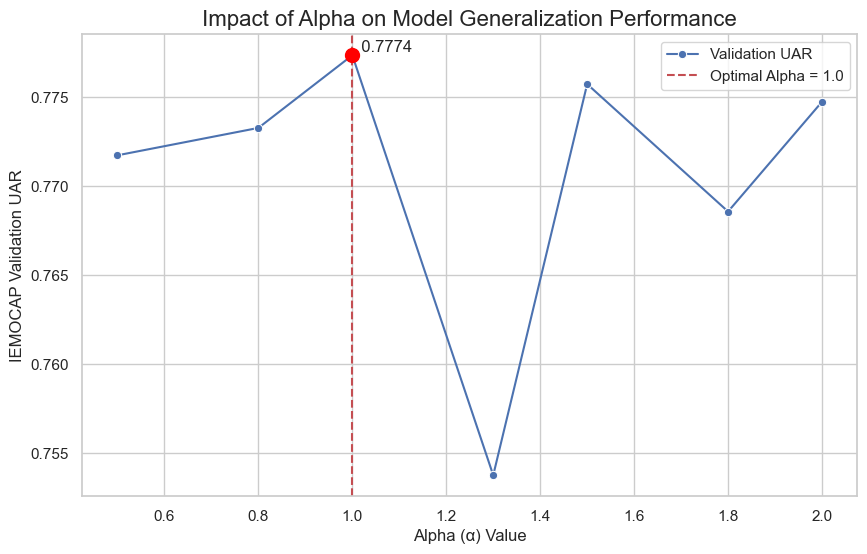

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# ‰ΩøÁî®Á¨¨‰∫åÊ≠•‰∏≠ÊéíÂ•ΩÂ∫è‰ΩÜÊú™Ê†ºÂºèÂåñÁöÑDataFrame (sorted_df)

# ËÆæÁΩÆÂõæË°®È£éÊ†º
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# ÁªòÂà∂ÊäòÁ∫øÂõæÔºåÂπ∂Ê∑ªÂä†Ê†áËÆ∞ÁÇπ
ax = sns.lineplot(data=sorted_df, x='alpha', y='validation_uar', marker='o', label='Validation UAR')

# ÊâæÂà∞UARÊúÄÈ´òÁöÑÁÇπ
best_alpha_row = sorted_df.loc[sorted_df['validation_uar'].idxmax()]
best_alpha = best_alpha_row['alpha']
best_uar = best_alpha_row['validation_uar']

# Âú®Âõæ‰∏äÁ™ÅÂá∫ÊòæÁ§∫Ëøô‰∏™ÊúÄÈ´òÁÇπ
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Optimal Alpha = {best_alpha}')
plt.scatter(best_alpha, best_uar, s=100, color='red', zorder=5) # ÊîæÂ§ßÊúÄ‰ºòÁöÑÁÇπ
plt.text(best_alpha, best_uar, f'  {best_uar:.4f}', verticalalignment='bottom')

# Ê∑ªÂä†Ê†áÈ¢òÂíåÂùêÊ†áËΩ¥Ê†áÁ≠æ
plt.title('Impact of Alpha on Model Generalization Performance', fontsize=16)
plt.xlabel('Alpha (Œ±) Value', fontsize=12)
plt.ylabel('IEMOCAP Validation UAR', fontsize=12)
plt.legend()

# ‰øùÂ≠òÂõæË°®Âà∞Êñá‰ª∂
plot_filepath = os.path.join(CONFIG.save_plots_location(), "alpha_vs_uar_plot_epoch15.png")
plt.savefig(plot_filepath)
print(f"\nÂõæË°®Â∑≤‰øùÂ≠òËá≥: {plot_filepath}")

plt.show()

## select checkpoint
‰ªéÊ®°Âûã‰øùÂ≠òÁöÑÊñá‰ª∂Ë∑ØÂæÑÈáåÔºåÂä†ËΩΩÊâÄÊúâÊ®°ÂûãÊñá‰ª∂Ôºå
Âú®È™åËØÅÈõÜ‰∏äËØÑ‰º∞ÊØè‰∏Ä‰∏™Ê®°ÂûãÔºàÂç≥ÊØè‰∏™Ê£ÄÊü•ÁÇπÔºâ
Âú®È™åËØÅÈõÜ‰∏äËøõË°åÂÖ¨Âπ≥ÁöÑÊ®™ÂêëÊØîËæÉÔºåÂÆ¢ËßÇÂú∞ÈÄâÊãîÂá∫Ê≥õÂåñËÉΩÂäõÊúÄÂº∫ÁöÑÂçï‰∏™Ê®°ÂûãÊ£ÄÊü•ÁÇπ„ÄÇ

### ËÆ≠ÁªÉ

d:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-11 13:43:36,818 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-11 13:43:36,818 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-11 13:43:36,931 - INFO - --- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-11 13:43:36,931 - INFO - --- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Êú¨Ê¨°Â∞Ü‰∏∫ËÆ≠ÁªÉÈõÜÂêØÁî®Èü≥È¢ëÊï∞ÊçÆÂ¢ûÂº∫„ÄÇ
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-11 13:43:38,889 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-11 13:43:38,889 - INFO - Êï∞ÊçÆÈõÜ 'train' Â∑≤ÂêØÁî®Èü≥È¢ëÊï∞ÊçÆÂ¢ûÂº∫„ÄÇ
2025-10-11 13:43:38,895 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-11 13:43:38,895 - INFO - --- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---
2025-10-11 13:43:38,889 - INFO - Êï∞ÊçÆÈõÜ 'train' Â∑≤ÂêØÁî®Èü≥È¢ëÊï∞ÊçÆÂ¢ûÂº∫„ÄÇ
2025-10-11 13:43:38,895 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-11 13:43:38,895 - INFO - --- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
[INFO] Â∑≤‰∏∫ 'train' ÂàíÂàÜÂêØÁî®Êï∞ÊçÆÂ¢ûÂº∫Âπ∂ÂàõÂª∫ Dataset„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-11 13:43:43,948 - INFO - --- ‰ΩøÁî®ÊúÄ‰ºò alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉÔºåÂÖ± 2 ‰∏™ Epochs ---
2025-10-11 13:43:43,948 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Contrastive_LGCA Ê®°Âûã...
2025-10-11 13:43:43,948 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Contrastive_LGCA Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0


Epoch 1 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 113/113 [00:15<00:00,  7.16it/s]
2025-10-11 13:45:45,700 - INFO - Epoch 1 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 6.3932, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.5156, È™åËØÅÊçüÂ§±: 1.0105, È™åËØÅÂáÜÁ°ÆÁéá: 0.5819, È™åËØÅUAR: 0.5013
Epoch 1 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 113/113 [00:15<00:00,  7.16it/s]
2025-10-11 13:45:45,700 - INFO - Epoch 1 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 6.3932, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.5156, È™åËØÅÊçüÂ§±: 1.0105, È™åËØÅÂáÜÁ°ÆÁéá: 0.5819, È™åËØÅUAR: 0.5013
2025-10-11 13:45:46,914 - INFO - Êñ∞ÁöÑÊúÄ‰Ω≥UARÊ®°ÂûãÂ∑≤‰øùÂ≠ò: 0.5013 (Epoch 1) -> D:/Unitec/SER\checkpoints\Contrastive_LGCA_uar_model_epoch_1.pt
2025-10-11 13:45:46,914 - INFO - Êñ∞ÁöÑÊúÄ‰Ω≥UARÊ®°ÂûãÂ∑≤‰øùÂ≠ò: 0.5013 (Epoch 1) -> D:/Unitec/SER\checkpoints\Contrastive_LGCA_uar_model_epoch_1.pt
2025-10-11 13:45:47,073 - INFO - --- ËÆ≠ÁªÉÂÆåÊàê ---
2025-10-11 13:45:47,073 - INFO - --- ËÆ≠ÁªÉÂÆåÊàê ---


Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 113/113 [00:15<00:00,  7.17it/s]



Accuracy (WAR): 0.5791
UAR: 0.5013


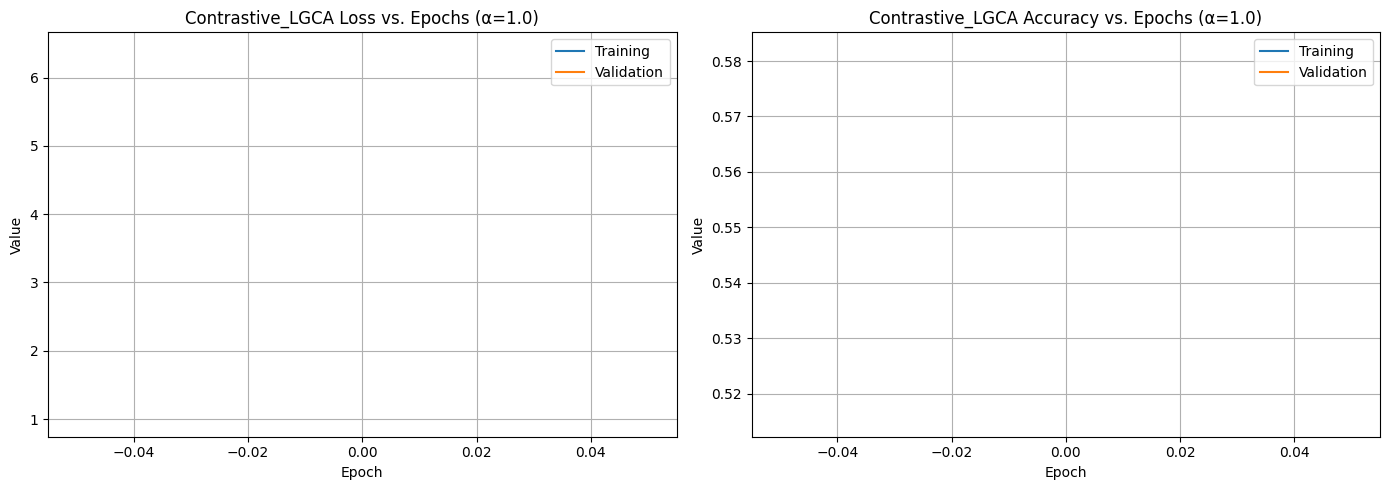

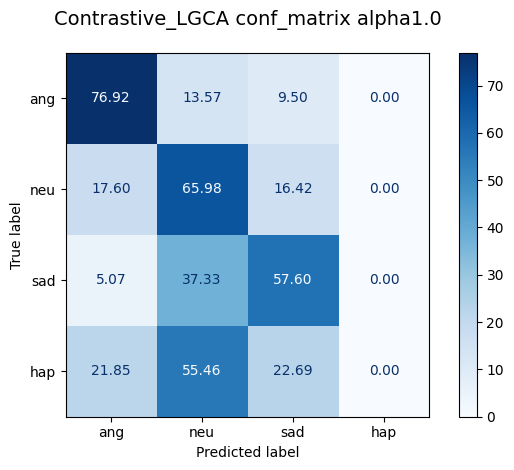

In [1]:
# main_contrastive.py

import torch
import gc
import os
import logging
import numpy as np
from tqdm.contrib.logging import _TqdmLoggingHandler
import warnings # <-- Êñ∞Â¢û

warnings.filterwarnings("ignore", category=UserWarning)

# ÈÖçÁΩÆÊó•ÂøóËÆ∞ÂΩï
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# ÂØºÂÖ•ÊâÄÊúâÂøÖË¶ÅÁöÑÊ®°Âùó
from core.config import CONFIG, device
from contrastive.model import ContrastiveModel, MemoryOptimizedContrastiveModel
from contrastive.trainer import ContrastiveTrainer
# Á°Æ‰øùÊÇ®Â∑≤ÁªèÂàõÂª∫‰∫ÜËøô‰∏™Êñ∞ÁöÑÊï∞ÊçÆÂä†ËΩΩÂô®ËÑöÊú¨
from scripts.get_dataloaders import get_contrastive_dataloaders
from contrastive.model import setup_memory_optimization

setup_memory_optimization()

def run_experiment():
    """
    ÊâßË°åÂÆåÊï¥ÁöÑLGCAÊ°ÜÊû∂ËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆûÈ™å„ÄÇ
    """
    # --- 1. Âä†ËΩΩÈÖçÁΩÆÂπ∂ËÆæÁΩÆÁéØÂ¢É ---
    try:
        CONFIG.load_config("config.yaml")
        logging.info("ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ")
    except FileNotFoundError:
        logging.error("ÈîôËØØÔºöÊâæ‰∏çÂà∞ 'config.yaml' Êñá‰ª∂„ÄÇËØ∑Á°Æ‰øùËØ•Êñá‰ª∂Â≠òÂú®‰∫éÈ°πÁõÆÊ†πÁõÆÂΩï„ÄÇ")
        return

    # ‰∏∫ÂèØÂ§çÁé∞ÊÄßËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    torch.cuda.empty_cache()
    gc.collect()

    # --- 2. Âä†ËΩΩÊï∞ÊçÆÈõÜ ---
    try:
        training_dataset_name = CONFIG.training_dataset_name()
        logging.info(f"--- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ '{training_dataset_name}' ÂáÜÂ§áDataloaders ---")
        iemocap_loaders = get_contrastive_dataloaders(training_dataset_name, use_audio_augmentation=True)
        train_loader = iemocap_loaders['train']
        validation_loader = iemocap_loaders['validation']

    except Exception as e:
        logging.error(f"Êï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")
        return

    # --- 3. ÂÆû‰æãÂåñÊ®°ÂûãÂíåËÆ≠ÁªÉÂô® ---
    logging.info("--- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---")
    try:
        num_labels = len(CONFIG.dataset_emotions(training_dataset_name))
        model = MemoryOptimizedContrastiveModel(num_labels=num_labels).to(device)


        trainer = ContrastiveTrainer(
            model=model,
            num_epochs=1,
            learning_rate=CONFIG.learning_rate(),
            alpha=CONFIG.llgca_loss_alpha(),
            optimizer_type=CONFIG.optimizer_type(),
            gradient_accumulation_steps=2
        )
    except Exception as e:
        logging.error(f"Ê®°ÂûãÊàñËÆ≠ÁªÉÂô®ÂÆû‰æãÂåñÂ§±Ë¥•: {e}")
        return

    # --- 4. ÂºÄÂßãËÆ≠ÁªÉ ---
    logging.info(f"--- ‰ΩøÁî®ÊúÄ‰ºò alpha = {trainer.alpha} ÂºÄÂßãÂú® '{training_dataset_name}' ‰∏äËøõË°åËÆ≠ÁªÉÔºåÂÖ± {CONFIG.training_epochs()} ‰∏™ Epochs ---")
    # Ëøô‰ºöÁîüÊàêÊçüÂ§±ÂíåÂáÜÁ°ÆÁéáÊõ≤Á∫øÂõæ
    trainer.train(train_loader, validation_loader) 
    
    logging.info("--- ËÆ≠ÁªÉÂÆåÊàê ---")

    # Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞
    print("Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...")
    iemocap_emotions = CONFIG.dataset_emotions(CONFIG.training_dataset_name())
    # evalÊñπÊ≥ïËøîÂõû‰∏â‰∏™ÂÄºÔºöuar, warÂíåÊ∑∑Ê∑ÜÁü©Èòµ
    eval_results = trainer.eval(validation_loader, labels=iemocap_emotions)


if __name__ == '__main__':
    run_experiment()

### È™åËØÅ

2025-10-11 10:15:10,208 - INFO - --- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñÁéØÂ¢ÉÂíåÈÖçÁΩÆ] ---
2025-10-11 10:15:10,212 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-11 10:15:10,213 - INFO - 
--- [Èò∂ÊÆµ‰∫åÔºöÂä†ËΩΩÊµãËØïÊï∞ÊçÆÈõÜ] ---
2025-10-11 10:15:10,213 - INFO - --- Ê≠£Âú®‰∏∫ÊµãËØïÈõÜ 'CREMA-D' ÂáÜÂ§áDataloader ---
2025-10-11 10:15:10,212 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-11 10:15:10,213 - INFO - 
--- [Èò∂ÊÆµ‰∫åÔºöÂä†ËΩΩÊµãËØïÊï∞ÊçÆÈõÜ] ---
2025-10-11 10:15:10,213 - INFO - --- Ê≠£Âú®‰∏∫ÊµãËØïÈõÜ 'CREMA-D' ÂáÜÂ§áDataloader ---


GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'CREMA-D' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\CREMA-D\Preprocessed\crema-d_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-11 10:15:12,229 - INFO - Â∑≤Âä†ËΩΩ 'CREMA-D' Êï∞ÊçÆÈõÜÁî®‰∫é 'evaluation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 4900
2025-10-11 10:15:12,230 - INFO - ÊµãËØïÈõÜ 'CREMA-D' Âä†ËΩΩÂÆåÊØï„ÄÇÂÖ± 4900 ‰∏™Ê†∑Êú¨„ÄÇ
2025-10-11 10:15:12,230 - INFO - 
--- [Èò∂ÊÆµ‰∏âÔºöÊü•ÊâæÊâÄÊúâÊ®°ÂûãÊ£ÄÊü•ÁÇπ] ---
2025-10-11 10:15:12,231 - INFO - ÊâæÂà∞‰∫Ü 2 ‰∏™Ê£ÄÊü•ÁÇπÊñá‰ª∂ÔºåÂ∞ÜÈÄê‰∏ÄËøõË°åËØÑ‰º∞„ÄÇ
2025-10-11 10:15:12,231 - INFO - 
--- [Èò∂ÊÆµÂõõÔºöÂºÄÂßãÂú®ÊµãËØïÈõÜ‰∏äËØÑ‰º∞ÊâÄÊúâÊ£ÄÊü•ÁÇπ] ---
2025-10-11 10:15:12,230 - INFO - ÊµãËØïÈõÜ 'CREMA-D' Âä†ËΩΩÂÆåÊØï„ÄÇÂÖ± 4900 ‰∏™Ê†∑Êú¨„ÄÇ
2025-10-11 10:15:12,230 - INFO - 
--- [Èò∂ÊÆµ‰∏âÔºöÊü•ÊâæÊâÄÊúâÊ®°ÂûãÊ£ÄÊü•ÁÇπ] ---
2025-10-11 10:15:12,231 - INFO - ÊâæÂà∞‰∫Ü 2 ‰∏™Ê£ÄÊü•ÁÇπÊñá‰ª∂ÔºåÂ∞ÜÈÄê‰∏ÄËøõË°åËØÑ‰º∞„ÄÇ
2025-10-11 10:15:12,231 - INFO - 
--- [Èò∂ÊÆµÂõõÔºöÂºÄÂßãÂú®ÊµãËØïÈõÜ‰∏äËØÑ‰º∞ÊâÄÊúâÊ£ÄÊü•ÁÇπ] ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ


ËØÑ‰º∞ÊâÄÊúâÊ£ÄÊü•ÁÇπ:   0%|          | 0/2 [00:00<?, ?it/s]

--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


C:\Users\felix\AppData\Local\Temp\ipykernel_12972\3238553519.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locat

--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 1e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 4, ÊçüÂ§±ÊùÉÈáç alpha: 1.0


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 613/613 [00:32<00:00, 18.86it/s]



Accuracy (WAR): 0.4920
UAR: 0.4988


ËØÑ‰º∞ÊâÄÊúâÊ£ÄÊü•ÁÇπ:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 1/2 [00:37<00:37, 37.68s/it]

--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


C:\Users\felix\AppData\Local\Temp\ipykernel_12972\3238553519.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locat

--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 1e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 4, ÊçüÂ§±ÊùÉÈáç alpha: 1.0


ËØÑ‰º∞ÊâÄÊúâÊ£ÄÊü•ÁÇπ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [01:13<00:00, 36.76s/it]

Accuracy (WAR): 0.5090
UAR: 0.5147


ËØÑ‰º∞ÊâÄÊúâÊ£ÄÊü•ÁÇπ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [01:13<00:00, 36.90s/it]
2025-10-11 10:16:26,035 - INFO - 
--- [Èò∂ÊÆµ‰∫îÔºöÊâÄÊúâÊ£ÄÊü•ÁÇπËØÑ‰º∞ÂÆåÊàêÔºåÊ±áÊÄªÁªìÊûú] ---

2025-10-11 10:16:26,035 - INFO - 
--- [Èò∂ÊÆµ‰∫îÔºöÊâÄÊúâÊ£ÄÊü•ÁÇπËØÑ‰º∞ÂÆåÊàêÔºåÊ±áÊÄªÁªìÊûú] ---



==================== ÊúÄÁªàÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÊ±áÊÄª ====================
                                   checkpoint  test_uar  test_war
0  Contrastive_LGCA_best_uar_model_epoch_2.pt  0.514664  0.508980
1  Contrastive_LGCA_best_uar_model_epoch_1.pt  0.498772  0.492041

ËØÑ‰º∞ÁªìÊûúÂ∑≤‰øùÂ≠òËá≥: D:/Unitec/SER\tables\final_test_evaluation_results.csv

==================== ÊúÄ‰Ω≥Ê®°ÂûãË°®Áé∞ ====================
üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÊ£ÄÊü•ÁÇπ: Contrastive_LGCA_best_uar_model_epoch_2.pt
   - ÊúÄ‰Ω≥ÊµãËØïÈõÜ UAR: 0.5147
   - ÂØπÂ∫îÁöÑÊµãËØïÈõÜ WAR: 0.5090


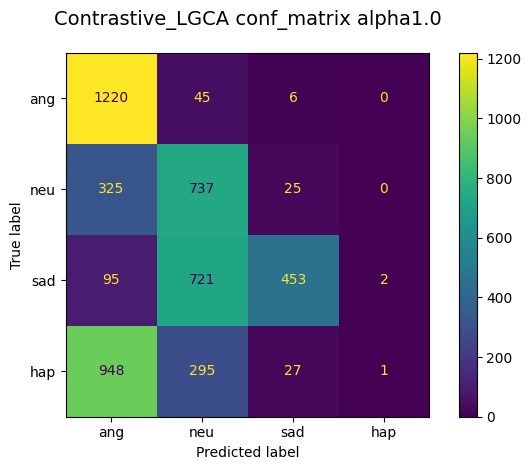

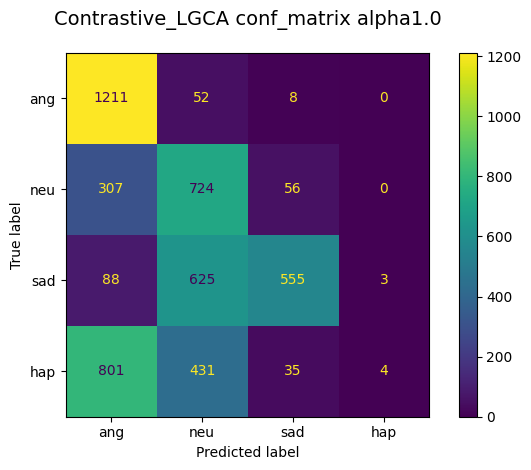

In [ ]:
# evaluate_checkpoints.py

import torch
import gc
import os
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# ÂØºÂÖ•‰Ω†È°πÁõÆ‰∏≠ÁöÑÊ†∏ÂøÉÊ®°Âùó
from core.config import CONFIG, device
from contrastive.model import MemoryOptimizedContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from scripts.get_dataloaders import get_contrastive_dataloaders
from contrastive.model import setup_memory_optimization

def evaluate_all_checkpoints():
    """
    Âä†ËΩΩ 'checkpoints/' ÁõÆÂΩï‰∏ãÁöÑÊâÄÊúâÊ®°ÂûãÊ£ÄÊü•ÁÇπÔºåÂπ∂Âú®ÊµãËØïÈõÜ‰∏äËøõË°åËØÑ‰º∞„ÄÇ
    """
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    
    # --- 1. ÁéØÂ¢ÉÂíåÈÖçÁΩÆÂàùÂßãÂåñ ---
    logging.info("--- [Èò∂ÊÆµ‰∏ÄÔºöÂàùÂßãÂåñÁéØÂ¢ÉÂíåÈÖçÁΩÆ] ---")
    setup_memory_optimization()
    try:
        CONFIG.load_config("config.yaml")
        logging.info("ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ")
    except FileNotFoundError:
        logging.error("ÈîôËØØÔºöÊâæ‰∏çÂà∞ 'config.yaml' Êñá‰ª∂„ÄÇ")
        return

    # --- 2. Âä†ËΩΩÊµãËØïÊï∞ÊçÆÈõÜ ---
    logging.info("\n--- [Èò∂ÊÆµ‰∫åÔºöÂä†ËΩΩÊµãËØïÊï∞ÊçÆÈõÜ] ---")
    try:
        evaluation_dataset_name = CONFIG.evaluation_dataset_name()
        logging.info(f"--- Ê≠£Âú®‰∏∫ÊµãËØïÈõÜ '{evaluation_dataset_name}' ÂáÜÂ§áDataloader ---")
        cremad_loaders = get_contrastive_dataloaders(evaluation_dataset_name)
        evaluation_loader = cremad_loaders['evaluation']
        cremad_emotions = CONFIG.dataset_emotions(evaluation_dataset_name)
        logging.info(f"ÊµãËØïÈõÜ '{evaluation_dataset_name}' Âä†ËΩΩÂÆåÊØï„ÄÇÂÖ± {len(evaluation_loader.dataset)} ‰∏™Ê†∑Êú¨„ÄÇ")
    except Exception as e:
        logging.error(f"ÊµãËØïÊï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")
        return

    # --- 3. Êü•ÊâæÊâÄÊúâÊ®°ÂûãÊ£ÄÊü•ÁÇπ ---
    logging.info("\n--- [Èò∂ÊÆµ‰∏âÔºöÊü•ÊâæÊâÄÊúâÊ®°ÂûãÊ£ÄÊü•ÁÇπ] ---")
    checkpoint_dir = CONFIG.saved_ckpt_location()
    if not os.path.exists(checkpoint_dir):
        logging.error(f"ÈîôËØØÔºöÊâæ‰∏çÂà∞Ê£ÄÊü•ÁÇπÁõÆÂΩï '{checkpoint_dir}'„ÄÇ")
        return
        
    # Á≠õÈÄâÂá∫ÊâÄÊúâ .pt Êñá‰ª∂ÔºåÂπ∂ÊåâepochÁºñÂè∑ÊéíÂ∫è
    checkpoint_files = [f for f in os.listdir(checkpoint_dir)
                       if f.lower().startswith('contrastive_lgca') and f.lower().endswith('.pt')]
    try:
        checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    except ValueError:
        logging.warning("ÈÉ®ÂàÜÊ£ÄÊü•ÁÇπÊñá‰ª∂Âêç‰∏çËßÑËåÉÔºåÂ∞ÜÊåâÈªòËÆ§Â≠óÊØçÈ°∫Â∫èÊéíÂ∫è„ÄÇ")

    if not checkpoint_files:
        logging.error(f"Âú® '{checkpoint_dir}' ÁõÆÂΩï‰∏≠Ê≤°ÊúâÊâæÂà∞‰ªª‰ΩïÊ£ÄÊü•ÁÇπÊñá‰ª∂ (.pt)„ÄÇ")
        return
    
    logging.info(f"ÊâæÂà∞‰∫Ü {len(checkpoint_files)} ‰∏™Ê£ÄÊü•ÁÇπÊñá‰ª∂ÔºåÂ∞ÜÈÄê‰∏ÄËøõË°åËØÑ‰º∞„ÄÇ")

    # --- 4. Âæ™ÁéØËØÑ‰º∞ÊØè‰∏™Ê£ÄÊü•ÁÇπ ---
    logging.info("\n--- [Èò∂ÊÆµÂõõÔºöÂºÄÂßãÂú®ÊµãËØïÈõÜ‰∏äËØÑ‰º∞ÊâÄÊúâÊ£ÄÊü•ÁÇπ] ---")
    results_list = []
    
    # Ëé∑ÂèñÊ†áÁ≠æÊï∞ÈáèÁî®‰∫éÊ®°ÂûãÂàùÂßãÂåñ
    training_dataset_name = CONFIG.training_dataset_name()
    num_labels = len(CONFIG.dataset_emotions(training_dataset_name))

    for checkpoint_file in tqdm(checkpoint_files, desc="ËØÑ‰º∞ÊâÄÊúâÊ£ÄÊü•ÁÇπ"):
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        
        # ÂÆû‰æãÂåñ‰∏Ä‰∏™ÂÖ®Êñ∞ÁöÑÊ®°Âûã
        model = MemoryOptimizedContrastiveModel(num_labels=num_labels).to(device)
        
        # Âä†ËΩΩÊ£ÄÊü•ÁÇπÁöÑÊùÉÈáç
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        
        # ÂÆû‰æãÂåñ‰∏Ä‰∏™TrainerÁî®‰∫éËØÑ‰º∞
        # Ê≥®ÊÑèÔºöËøôÈáåÁöÑ num_epochs, learning_rate Á≠âÂèÇÊï∞Âú®ËØÑ‰º∞Êó∂‰∏ç‰ºöË¢´‰ΩøÁî®ÔºåÂèØ‰ª•ÈöèÊÑèÂ°´ÂÜô
        trainer = ContrastiveTrainer(
            model=model,
            num_epochs=1,
            learning_rate=CONFIG.learning_rate(),
            alpha=CONFIG.llgca_loss_alpha(),
            optimizer_type=CONFIG.optimizer_type(),
        )
        
        # Ë∞ÉÁî® eval ÊñπÊ≥ïËøõË°åËØÑ‰º∞
        logging.info(f"\n--- Ê≠£Âú®ËØÑ‰º∞: {checkpoint_file} ---")
        test_uar, test_war = trainer.eval(evaluation_loader, labels=cremad_emotions)
        
        # ËÆ∞ÂΩïÁªìÊûú
        result = {
            'checkpoint': checkpoint_file,
            'test_uar': test_uar,
            'test_war': test_war
        }
        results_list.append(result)
        
        # Ê∏ÖÁêÜÂÜÖÂ≠ò
        del model, trainer
        gc.collect()
        torch.cuda.empty_cache()

    # --- 5. ÁªìÊûúÊ±áÊÄª‰∏éÂàÜÊûê ---
    logging.info("\n--- [Èò∂ÊÆµ‰∫îÔºöÊâÄÊúâÊ£ÄÊü•ÁÇπËØÑ‰º∞ÂÆåÊàêÔºåÊ±áÊÄªÁªìÊûú] ---")
    if not results_list:
        logging.warning("Ê≤°ÊúâËØÑ‰º∞‰ªª‰ΩïÊ®°ÂûãÔºåÊó†Ê≥ïÁîüÊàêÊä•Âëä„ÄÇ")
        return

    # Â∞ÜÁªìÊûúËΩ¨Êç¢‰∏∫DataFrameÊñπ‰æøÊü•Áúã
    results_df = pd.DataFrame(results_list)
    
    # ÊåâÁÖßUARÈôçÂ∫èÊéíÂàó
    results_df = results_df.sort_values(by='test_uar', ascending=False).reset_index(drop=True)
    
    # Â∞ÜÁªìÊûú‰øùÂ≠òÂà∞CSVÊñá‰ª∂
    save_path = os.path.join(CONFIG.save_tables_location(), "final_test_evaluation_results.csv")
    results_df.to_csv(save_path, index=False)
    
    print("\n==================== ÊúÄÁªàÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûúÊ±áÊÄª ====================")
    print(results_df)
    print(f"\nËØÑ‰º∞ÁªìÊûúÂ∑≤‰øùÂ≠òËá≥: {save_path}")
    
    # ÊâæÂà∞Âπ∂È´ò‰∫ÆÊòæÁ§∫ÊúÄ‰Ω≥Ê®°Âûã
    best_model_stats = results_df.iloc[0]
    print("\n==================== ÊúÄ‰Ω≥Ê®°ÂûãË°®Áé∞ ====================")
    print(f"üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÊ£ÄÊü•ÁÇπ: {best_model_stats['checkpoint']}")
    print(f"   - ÊúÄ‰Ω≥ÊµãËØïÈõÜ UAR: {best_model_stats['test_uar']:.4f}")
    print(f"   - ÂØπÂ∫îÁöÑÊµãËØïÈõÜ WAR: {best_model_stats['test_war']:.4f}")
    print("==========================================================")


if __name__ == '__main__':
    evaluate_all_checkpoints()

In [ ]:
from core.config import CONFIG, device

setup_memory_optimization()


"""
ÊâßË°åÂÆåÊï¥ÁöÑLGCAÊ°ÜÊû∂ËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆûÈ™å„ÄÇ
"""
# --- 1. Âä†ËΩΩÈÖçÁΩÆÂπ∂ËÆæÁΩÆÁéØÂ¢É ---
try:
    CONFIG.load_config("config.yaml")
    logging.info("ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ")
except FileNotFoundError:
    logging.error("ÈîôËØØÔºöÊâæ‰∏çÂà∞ 'config.yaml' Êñá‰ª∂„ÄÇËØ∑Á°Æ‰øùËØ•Êñá‰ª∂Â≠òÂú®‰∫éÈ°πÁõÆÊ†πÁõÆÂΩï„ÄÇ")

# ‰∏∫ÂèØÂ§çÁé∞ÊÄßËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

torch.cuda.empty_cache()
gc.collect()

# --- 2. Âä†ËΩΩÊï∞ÊçÆÈõÜ ---
try:
    training_dataset_name = CONFIG.training_dataset_name()
    logging.info(f"--- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ '{training_dataset_name}' ÂáÜÂ§áDataloaders ---")
    iemocap_loaders = get_contrastive_dataloaders(training_dataset_name)
    train_loader = iemocap_loaders['train']
    validation_loader = iemocap_loaders['validation']

    evaluation_dataset_name = CONFIG.evaluation_dataset_name()
    logging.info(f"--- Ê≠£Âú®‰∏∫ËØÑ‰º∞ÈõÜ '{evaluation_dataset_name}' ÂáÜÂ§áDataloaders ---")
    cremad_loaders = get_contrastive_dataloaders(evaluation_dataset_name)
    evaluation_loader = cremad_loaders['evaluation']
except Exception as e:
    logging.error(f"Êï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")

# --- 6. ËøõË°åËØÑ‰º∞ ---
iemocap_emotions = CONFIG.dataset_emotions(training_dataset_name)
cremad_emotions = CONFIG.dataset_emotions(evaluation_dataset_name)

logging.info(f"--- Âú® '{training_dataset_name}' È™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞ ---")
trainer.eval(validation_loader, labels=iemocap_emotions)

logging.info(f"--- Âú® '{evaluation_dataset_name}' ÊµãËØïÈõÜ‰∏äËøõË°åÈõ∂Ê†∑Êú¨ËØÑ‰º∞ ---")
trainer.eval(evaluation_loader, labels=cremad_emotions)

logging.info("--- ÂÆûÈ™åÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ ---")

# 6. ÊúÄÁªàÊ®°ÂûãËÆ≠ÁªÉ

### ÂêàÂπ∂Êï∞ÊçÆÈõÜ‰∫ÜÁöÑ

In [ ]:
# train_final_model.py

import torch
import os
import gc
import numpy as np

# ÂØºÂÖ•ÊÇ®È°πÁõÆ‰∏≠ÁöÑÊ†∏ÂøÉÊ®°Âùó
from core.config import CONFIG, device
from scripts.get_dataloaders import get_contrastive_dataloaders
from contrastive.model import ContrastiveModel, MemoryOptimizedContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from torch.utils.data import ConcatDataset # <-- ÂØºÂÖ•Áî®‰∫éÂêàÂπ∂Êï∞ÊçÆÈõÜÁöÑÂ∑•ÂÖ∑

def train_final_lgca_model():
    """
    ‰ΩøÁî®ÊúÄ‰ºòË∂ÖÂèÇÊï∞ÂíåÂÖ®ÈÉ®ËÆ≠ÁªÉÊï∞ÊçÆÔºåËÆ≠ÁªÉÂπ∂‰øùÂ≠òÊúÄÁªàÁöÑLGCAÊ®°Âûã„ÄÇ
    """
    print("--- [ÊúÄÁªàÊ®°ÂûãËÆ≠ÁªÉÂºÄÂßã] ---")

    # 1. Âä†ËΩΩÈÖçÁΩÆ
    CONFIG.load_config("config.yaml")

    # ‰∏∫ÂèØÂ§çÁé∞ÊÄßËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # 2. Âä†ËΩΩÂπ∂ÂêàÂπ∂Êï∞ÊçÆÈõÜ, ÊúÄÂ§ßÂåñËÆ≠ÁªÉÊï∞ÊçÆÂà©Áî®Áéá
    print("Âä†ËΩΩÂπ∂ÂêàÂπ∂IEMOCAPËÆ≠ÁªÉÈõÜ‰∏éÈ™åËØÅÈõÜ...")
    # Ê≥®ÊÑèÔºöget_contrastive_dataloaders ÂÜÖÈÉ®‰ºöËøõË°å train/val ÂàíÂàÜ
    # Êàë‰ª¨ÈúÄË¶ÅËé∑ÂèñÂÆÉÂàíÂàÜÂá∫ÁöÑ‰∏§‰∏™Êï∞ÊçÆÈõÜÂØπË±°
    dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
    train_dataset = dataloaders['train'].dataset
    validation_dataset = dataloaders['validation'].dataset

    # ‰ΩøÁî® ConcatDataset Â∞ÜËÆ≠ÁªÉÈõÜÂíåÈ™åËØÅÈõÜÂêàÂπ∂
    full_train_dataset = ConcatDataset([train_dataset, validation_dataset])

    # Áî®ÂêàÂπ∂ÂêéÁöÑÂÆåÊï¥Êï∞ÊçÆÈõÜÂàõÂª∫‰∏Ä‰∏™Êñ∞ÁöÑ DataLoader
    full_train_loader = torch.utils.data.DataLoader(
        full_train_dataset,
        batch_size=CONFIG.dataloader_dict()['batch_size'],
        collate_fn=dataloaders['train'].collate_fn, # collate_fn ‰øùÊåÅ‰∏çÂèò
        num_workers=CONFIG.dataloader_dict()['num_workers'],
        shuffle=True # Âú®ÊúÄÁªàËÆ≠ÁªÉÊó∂Êâì‰π±Êï∞ÊçÆ
    )
    print(f"Êï∞ÊçÆÂáÜÂ§áÂÆåÊàê„ÄÇÊÄªËÆ≠ÁªÉÊ†∑Êú¨Êï∞: {len(full_train_dataset)}")

    # 3. ÂàùÂßãÂåñÊ®°ÂûãÂíåËÆ≠ÁªÉÂô®
    print("ÂàùÂßãÂåñÊ®°ÂûãÂíåËÆ≠ÁªÉÂô®...")
    num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
    model = ContrastiveModel(num_labels=num_labels).to(device)
    model = MemoryOptimizedContrastiveModel(num_labels=num_labels).to(device)

    trainer = ContrastiveTrainer(
        model=model,
        num_epochs=CONFIG.training_epochs(),
        learning_rate=CONFIG.learning_rate(),
        alpha=CONFIG.llgca_loss_alpha(), # ‰ªéconfig‰∏≠ËØªÂèñÊúÄ‰ºòalpha (Â∫î‰∏∫2.0)
        optimizer_type=CONFIG.optimizer_type(),
        gradient_accumulation_steps=1
    )

    # 4. ÊâßË°åËÆ≠ÁªÉ
    print(f"‰ΩøÁî®ÊúÄ‰ºò alpha = {trainer.alpha} ÂºÄÂßãÂú®ÂÆåÊï¥Êï∞ÊçÆ‰∏äËøõË°åÊúÄÁªàËÆ≠ÁªÉ...")
    trainer.train(full_train_loader)
    print("ÊúÄÁªàËÆ≠ÁªÉÂÆåÊàê„ÄÇ")

    # 5. ‰øùÂ≠òÊ®°ÂûãÊùÉÈáç
    model_save_path = os.path.join(
        CONFIG.saved_models_location(), 
        f"lgca_final_alpha_{trainer.alpha}_seed_{seed}.pth"
    )
    torch.save(model.state_dict(), model_save_path)
    print(f"Ê®°ÂûãÂ∑≤ÊàêÂäü‰øùÂ≠òËá≥: {model_save_path}")

# --- ËÑöÊú¨ÊâßË°åÂÖ•Âè£ ---
if __name__ == '__main__':
    train_final_lgca_model()



## LGCA Œ±2.0Ê®°ÂûãÂä†ËΩΩÈ™åËØÅ
lgca_final_alpha_2.0_seed_42

In [7]:
# ÂàõÂª∫‰∏Ä‰∏™Êñ∞ÁöÑËÑöÊú¨ÊàñNotebookÂçïÂÖÉÊ†º

from core.config import CONFIG, device
from contrastive.model import ContrastiveModel
import torch

CONFIG.load_config("config.yaml")

# 1. ÈáçÊñ∞ÂàõÂª∫‰∏Ä‰∏™‰∏é‰øùÂ≠òÊó∂ÁªìÊûÑÂÆåÂÖ®Áõ∏ÂêåÁöÑÊ®°ÂûãÂÆû‰æã
num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
model_to_load = ContrastiveModel(num_labels=num_labels).to(device)

# 2. ÂÆö‰πâÊ®°ÂûãÊñá‰ª∂ÁöÑË∑ØÂæÑ
model_path = "E:/Unitec/SER/audio/saved_models/lgca_final_alpha_2.0_seed_42.pth"

# 3. Â∞ùËØïÂä†ËΩΩÁä∂ÊÄÅÂ≠óÂÖ∏
try:
    model_to_load.load_state_dict(torch.load(model_path, weights_only=True))
    model_to_load.eval() # ÂàáÊç¢Âà∞ËØÑ‰º∞Ê®°Âºè
    print("‚úÖ Ê®°ÂûãÊùÉÈáçÂä†ËΩΩÊàêÂäüÂπ∂ÈÄöËøáÈ™åËØÅÔºÅ")
except Exception as e:
    print(f"‚ùå Ê®°ÂûãÊùÉÈáçÂä†ËΩΩÂ§±Ë¥•ÔºÅËØ∑Ê£ÄÊü•Ë∑ØÂæÑÊàñÊ®°ÂûãÊû∂ÊûÑ„ÄÇ")
    print(f"ÈîôËØØ‰ø°ÊÅØ: {e}")

‚úÖ Ê®°ÂûãÊùÉÈáçÂä†ËΩΩÊàêÂäüÂπ∂ÈÄöËøáÈ™åËØÅÔºÅ


### Œ± = 5.0

2025-09-04 10:21:22,333 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-09-04 10:21:22,542 - INFO - --- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
--- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-09-04 10:21:23,872 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-09-04 10:21:23,876 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-09-04 10:21:23,877 - INFO - --- Ê≠£Âú®‰∏∫ËØÑ‰º∞ÈõÜ 'CREMA-D' ÂáÜÂ§áDataloaders ---
--- Ê≠£Âú®‰∏∫ËØÑ‰º∞ÈõÜ 'CREMA-D' ÂáÜÂ§áDataloaders ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®‰∏∫ 'CREMA-D' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\CREMA-D\Preprocessed\crema-d_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-09-04 10:21:25,138 - INFO - Â∑≤Âä†ËΩΩ 'CREMA-D' Êï∞ÊçÆÈõÜÁî®‰∫é 'evaluation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 4900
Â∑≤Âä†ËΩΩ 'CREMA-D' Êï∞ÊçÆÈõÜÁî®‰∫é 'evaluation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 4900
2025-09-04 10:21:25,139 - INFO - --- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---
--- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ


2025-09-04 10:21:29,653 - INFO - --- ‰ΩøÁî®ÊúÄ‰ºò alpha = 5.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉÔºåÂÖ± 10 ‰∏™ Epochs ---
--- ‰ΩøÁî®ÊúÄ‰ºò alpha = 5.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉÔºåÂÖ± 10 ‰∏™ Epochs ---
2025-09-04 10:21:29,654 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Contrastive_LGCA Ê®°Âûã...
ÂºÄÂßãËÆ≠ÁªÉ Contrastive_LGCA Ê®°Âûã...


[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 4, ÊçüÂ§±ÊùÉÈáç alpha: 5.0


Epoch 1 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 449/449 [00:39<00:00, 11.46it/s]
2025-09-04 10:29:51,028 - INFO - Epoch 1 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 6.6859, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.3872, È™åËØÅÊçüÂ§±: 5.0648, È™åËØÅÂáÜÁ°ÆÁéá: 0.5122
Epoch 1 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 6.6859, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.3872, È™åËØÅÊçüÂ§±: 5.0648, È™åËØÅÂáÜÁ°ÆÁéá: 0.5122
Epoch 2 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 449/449 [00:38<00:00, 11.68it/s]
2025-09-04 10:36:15,207 - INFO - Epoch 2 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 4.7824, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.5192, È™åËØÅÊçüÂ§±: 4.9641, È™åËØÅÂáÜÁ°ÆÁéá: 0.5423
Epoch 2 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 4.7824, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.5192, È™åËØÅÊçüÂ§±: 4.9641, È™åËØÅÂáÜÁ°ÆÁéá: 0.5423
Epoch 3 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 449/449 [00:38<00:00, 11.64it/s]
2025-09-04 10:42:43,854 - INFO - Epoch 3 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 4.0473, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.6203, È™åËØÅÊçüÂ§±: 4.9565, È™åËØÅÂáÜÁ°ÆÁéá: 0.6425
Epoch 3 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 4.0473, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.6203, È™åËØÅÊçüÂ§±: 4.9565

Accuracy (WAR): 0.7238
UAR: 0.6899


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2450/2450 [02:24<00:00, 16.96it/s]
2025-09-04 11:50:53,308 - INFO - --- ÂÆûÈ™åÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ ---
--- ÂÆûÈ™åÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ ---


Accuracy (WAR): 0.5500
UAR: 0.5510


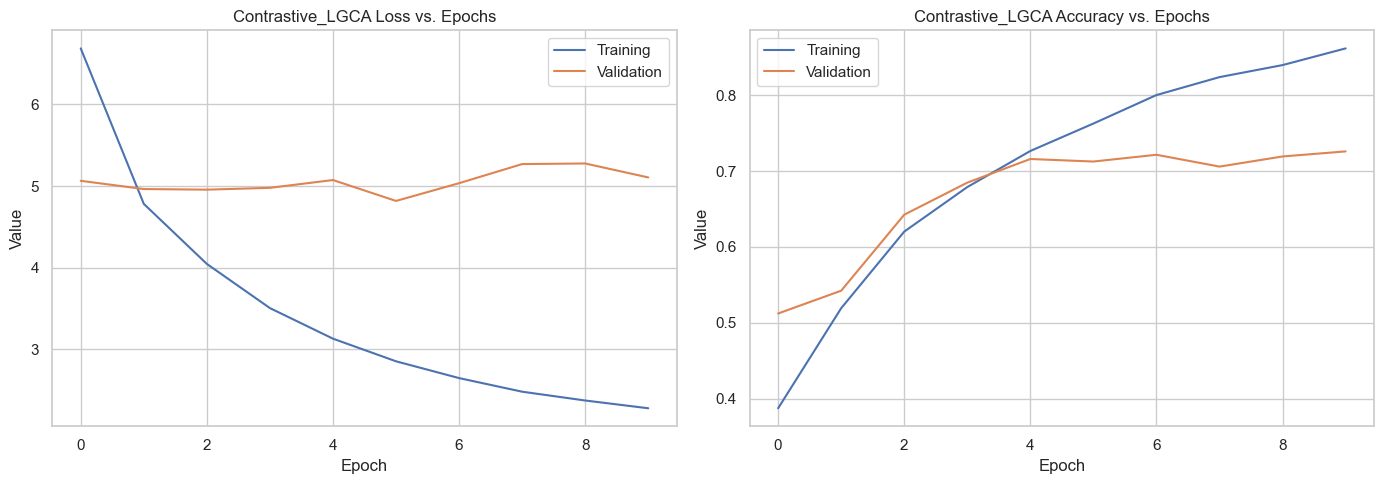

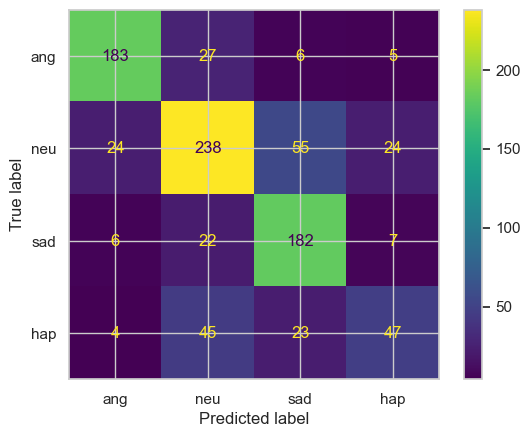

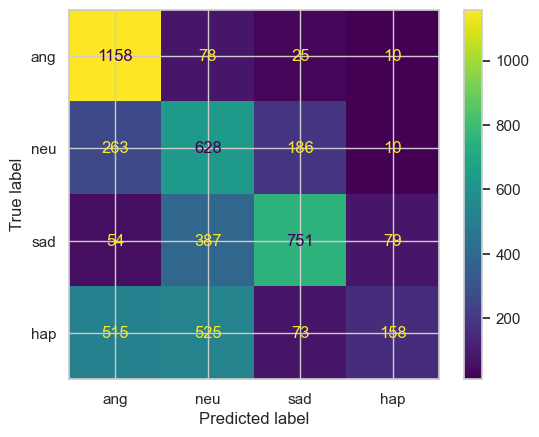

In [ ]:
# main_contrastive.py

import torch
import gc
import os
import logging
from tqdm.contrib.logging import _TqdmLoggingHandler
import warnings # <-- Êñ∞Â¢û

warnings.filterwarnings("ignore", category=UserWarning)

# ÈÖçÁΩÆÊó•ÂøóËÆ∞ÂΩï
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Ê∑ªÂä† tqdm ÁöÑÊó•ÂøóÂ§ÑÁêÜÂô®Ôºå‰ª•Á°Æ‰øùÊó•Âøó‰∏ç‰ºöÁ†¥ÂùèËøõÂ∫¶Êù°
logging.getLogger().addHandler(_TqdmLoggingHandler())


# ÂØºÂÖ•ÊâÄÊúâÂøÖË¶ÅÁöÑÊ®°Âùó
from core.config import CONFIG, device
from contrastive.model import ContrastiveModel, MemoryOptimizedContrastiveModel
from contrastive.trainer import ContrastiveTrainer
# Á°Æ‰øùÊÇ®Â∑≤ÁªèÂàõÂª∫‰∫ÜËøô‰∏™Êñ∞ÁöÑÊï∞ÊçÆÂä†ËΩΩÂô®ËÑöÊú¨
from scripts.get_dataloaders import get_contrastive_dataloaders
from contrastive.model import setup_memory_optimization

setup_memory_optimization()

def run_experiment():
    """
    ÊâßË°åÂÆåÊï¥ÁöÑLGCAÊ°ÜÊû∂ËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆûÈ™å„ÄÇ
    """
    # --- 1. Âä†ËΩΩÈÖçÁΩÆÂπ∂ËÆæÁΩÆÁéØÂ¢É ---
    try:
        CONFIG.load_config("config.yaml")
        logging.info("ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ")
    except FileNotFoundError:
        logging.error("ÈîôËØØÔºöÊâæ‰∏çÂà∞ 'config.yaml' Êñá‰ª∂„ÄÇËØ∑Á°Æ‰øùËØ•Êñá‰ª∂Â≠òÂú®‰∫éÈ°πÁõÆÊ†πÁõÆÂΩï„ÄÇ")
        return

    # ‰∏∫ÂèØÂ§çÁé∞ÊÄßËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    torch.cuda.empty_cache()
    gc.collect()

    # --- 2. Âä†ËΩΩÊï∞ÊçÆÈõÜ ---
    try:
        training_dataset_name = CONFIG.training_dataset_name()
        logging.info(f"--- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ '{training_dataset_name}' ÂáÜÂ§áDataloaders ---")
        iemocap_loaders = get_contrastive_dataloaders(training_dataset_name)
        train_loader = iemocap_loaders['train']
        validation_loader = iemocap_loaders['validation']

        evaluation_dataset_name = CONFIG.evaluation_dataset_name()
        logging.info(f"--- Ê≠£Âú®‰∏∫ËØÑ‰º∞ÈõÜ '{evaluation_dataset_name}' ÂáÜÂ§áDataloaders ---")
        cremad_loaders = get_contrastive_dataloaders(evaluation_dataset_name)
        evaluation_loader = cremad_loaders['evaluation']
    except Exception as e:
        logging.error(f"Êï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")
        return

    # --- 3. ÂÆû‰æãÂåñÊ®°ÂûãÂíåËÆ≠ÁªÉÂô® ---
    logging.info("--- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---")
    try:
        num_labels = len(CONFIG.dataset_emotions(training_dataset_name))
        model = ContrastiveModel(num_labels=num_labels).to(device)
        
        # # ÂêØÁî®Ê¢ØÂ∫¶Ê£ÄÊü•ÁÇπ‰ª•ËäÇÁúÅÊòæÂ≠ò
        # model.audio_encoder.gradient_checkpointing_enable()
        # model.text_encoder.gradient_checkpointing_enable()
        # logging.info("Â∑≤‰∏∫Â£∞Â≠¶ÂíåÊñáÊú¨ÁºñÁ†ÅÂô®ÂêØÁî®Ê¢ØÂ∫¶Ê£ÄÊü•ÁÇπ„ÄÇ")


        trainer = ContrastiveTrainer(
            model=model,
            num_epochs=CONFIG.training_epochs(),
            learning_rate=CONFIG.learning_rate(),
            alpha=CONFIG.llgca_loss_alpha(), # ‰ªéconfig‰∏≠ËØªÂèñÊúÄ‰ºòalpha (Â∫î‰∏∫5.0)
            optimizer_type=CONFIG.optimizer_type(),
            gradient_accumulation_steps=1
        )
    except Exception as e:
        logging.error(f"Ê®°ÂûãÊàñËÆ≠ÁªÉÂô®ÂÆû‰æãÂåñÂ§±Ë¥•: {e}")
        return

    # --- 4. ÂºÄÂßãËÆ≠ÁªÉ ---
    logging.info(f"--- ‰ΩøÁî®ÊúÄ‰ºò alpha = {trainer.alpha} ÂºÄÂßãÂú® '{training_dataset_name}' ‰∏äËøõË°åËÆ≠ÁªÉÔºåÂÖ± {CONFIG.training_epochs()} ‰∏™ Epochs ---")
    # trainer.train(train_loader)
        # *** Ê†∏ÂøÉ‰øÆÊîπÁÇπÔºöÂ∞Ü validation_loader ‰º†ÈÄíÁªô train ÊñπÊ≥ï ***
    trainer.train(train_loader, validation_loader) 
    
    logging.info("--- ËÆ≠ÁªÉÂÆåÊàê ---")

    # --- 5. ‰øùÂ≠òÊ®°Âûã ---
    model_save_path = os.path.join(CONFIG.saved_models_location(),
                                   f"lgca_final_alpha_{trainer.alpha}_seed_{seed}.pth")
    torch.save(model.state_dict(), model_save_path)
    logging.info(f"Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: {model_save_path}")

    # --- 6. ËøõË°åËØÑ‰º∞ ---
    iemocap_emotions = CONFIG.dataset_emotions(training_dataset_name)
    cremad_emotions = CONFIG.dataset_emotions(evaluation_dataset_name)

    logging.info(f"--- Âú® '{training_dataset_name}' È™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞ ---")
    trainer.eval(validation_loader, labels=iemocap_emotions)

    logging.info(f"--- Âú® '{evaluation_dataset_name}' ÊµãËØïÈõÜ‰∏äËøõË°åÈõ∂Ê†∑Êú¨ËØÑ‰º∞ ---")
    trainer.eval(evaluation_loader, labels=cremad_emotions)

    logging.info("--- ÂÆûÈ™åÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ ---")


if __name__ == '__main__':
    run_experiment()

### Œ± = 4.0

In [2]:
# main_contrastive.py

import torch
import gc
import os
import logging
import numpy as np
from tqdm.contrib.logging import _TqdmLoggingHandler
import warnings # <-- Êñ∞Â¢û

warnings.filterwarnings("ignore", category=UserWarning)

# ÈÖçÁΩÆÊó•ÂøóËÆ∞ÂΩï
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Ê∑ªÂä† tqdm ÁöÑÊó•ÂøóÂ§ÑÁêÜÂô®Ôºå‰ª•Á°Æ‰øùÊó•Âøó‰∏ç‰ºöÁ†¥ÂùèËøõÂ∫¶Êù°
logging.getLogger().addHandler(_TqdmLoggingHandler())


# ÂØºÂÖ•ÊâÄÊúâÂøÖË¶ÅÁöÑÊ®°Âùó
from core.config import CONFIG, device
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
# Á°Æ‰øùÊÇ®Â∑≤ÁªèÂàõÂª∫‰∫ÜËøô‰∏™Êñ∞ÁöÑÊï∞ÊçÆÂä†ËΩΩÂô®ËÑöÊú¨
from scripts.get_dataloaders import get_contrastive_dataloaders

def run_experiment():
    """
    ÊâßË°åÂÆåÊï¥ÁöÑLGCAÊ°ÜÊû∂ËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆûÈ™å„ÄÇ
    """
    # --- 1. Âä†ËΩΩÈÖçÁΩÆÂπ∂ËÆæÁΩÆÁéØÂ¢É ---
    try:
        CONFIG.load_config("config.yaml")
        logging.info("ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ")
    except FileNotFoundError:
        logging.error("ÈîôËØØÔºöÊâæ‰∏çÂà∞ 'config.yaml' Êñá‰ª∂„ÄÇËØ∑Á°Æ‰øùËØ•Êñá‰ª∂Â≠òÂú®‰∫éÈ°πÁõÆÊ†πÁõÆÂΩï„ÄÇ")
        return

    # ‰∏∫ÂèØÂ§çÁé∞ÊÄßËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    torch.cuda.empty_cache()
    gc.collect()

    # --- 2. Âä†ËΩΩÊï∞ÊçÆÈõÜ ---
    try:
        training_dataset_name = CONFIG.training_dataset_name()
        logging.info(f"--- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ '{training_dataset_name}' ÂáÜÂ§áDataloaders ---")
        iemocap_loaders = get_contrastive_dataloaders(training_dataset_name)
        train_loader = iemocap_loaders['train']
        validation_loader = iemocap_loaders['validation']

        evaluation_dataset_name = CONFIG.evaluation_dataset_name()
        logging.info(f"--- Ê≠£Âú®‰∏∫ËØÑ‰º∞ÈõÜ '{evaluation_dataset_name}' ÂáÜÂ§áDataloaders ---")
        cremad_loaders = get_contrastive_dataloaders(evaluation_dataset_name)
        evaluation_loader = cremad_loaders['evaluation']
    except Exception as e:
        logging.error(f"Êï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")
        return

    # --- 3. ÂÆû‰æãÂåñÊ®°ÂûãÂíåËÆ≠ÁªÉÂô® ---
    logging.info("--- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---")
    try:
        num_labels = len(CONFIG.dataset_emotions(training_dataset_name))
        model = ContrastiveModel(num_labels=num_labels).to(device)
        
        # # ÂêØÁî®Ê¢ØÂ∫¶Ê£ÄÊü•ÁÇπ‰ª•ËäÇÁúÅÊòæÂ≠ò
        # model.audio_encoder.gradient_checkpointing_enable()
        # model.text_encoder.gradient_checkpointing_enable()
        # logging.info("Â∑≤‰∏∫Â£∞Â≠¶ÂíåÊñáÊú¨ÁºñÁ†ÅÂô®ÂêØÁî®Ê¢ØÂ∫¶Ê£ÄÊü•ÁÇπ„ÄÇ")


        trainer = ContrastiveTrainer(
            model=model,
            num_epochs=CONFIG.training_epochs(),
            learning_rate=CONFIG.learning_rate(),
            alpha=CONFIG.llgca_loss_alpha(), # ‰ªéconfig‰∏≠ËØªÂèñÊúÄ‰ºòalpha
            optimizer_type=CONFIG.optimizer_type(),
            gradient_accumulation_steps=4
        )
    except Exception as e:
        logging.error(f"Ê®°ÂûãÊàñËÆ≠ÁªÉÂô®ÂÆû‰æãÂåñÂ§±Ë¥•: {e}")
        return

    # --- 4. ÂºÄÂßãËÆ≠ÁªÉ ---
    logging.info(f"--- ‰ΩøÁî®ÊúÄ‰ºò alpha = {trainer.alpha} ÂºÄÂßãÂú® '{training_dataset_name}' ‰∏äËøõË°åËÆ≠ÁªÉÔºåÂÖ± {CONFIG.training_epochs()} ‰∏™ Epochs ---")
    # trainer.train(train_loader)
        # *** Ê†∏ÂøÉ‰øÆÊîπÁÇπÔºöÂ∞Ü validation_loader ‰º†ÈÄíÁªô train ÊñπÊ≥ï ***
    trainer.train(train_loader, validation_loader) 
    
    logging.info("--- ËÆ≠ÁªÉÂÆåÊàê ---")

    # --- 5. ‰øùÂ≠òÊ®°Âûã ---
    model_save_path = os.path.join(CONFIG.saved_models_location(),
                                   f"lgca_final_alpha_{trainer.alpha}_seed_{seed}.pth")
    torch.save(model.state_dict(), model_save_path)
    logging.info(f"Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: {model_save_path}")

    # --- 6. ËøõË°åËØÑ‰º∞ ---
    iemocap_emotions = CONFIG.dataset_emotions(training_dataset_name)
    cremad_emotions = CONFIG.dataset_emotions(evaluation_dataset_name)

    logging.info(f"--- Âú® '{training_dataset_name}' È™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞ ---")
    trainer.eval(validation_loader, labels=iemocap_emotions)

    logging.info(f"--- Âú® '{evaluation_dataset_name}' ÊµãËØïÈõÜ‰∏äËøõË°åÈõ∂Ê†∑Êú¨ËØÑ‰º∞ ---")
    trainer.eval(evaluation_loader, labels=cremad_emotions)

    logging.info("--- ÂÆûÈ™åÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ ---")


if __name__ == '__main__':
    run_experiment()

2025-09-09 17:51:27,718 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-09-09 17:51:27,820 - INFO - --- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
--- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
--- Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-09-09 17:51:29,133 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-09-09 17:51:29,137 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-09-09 17:51:29,138 - INFO - --- Ê≠£Âú®‰∏∫ËØÑ‰º∞ÈõÜ 'CREMA-D' ÂáÜÂ§áDataloaders ---
--- Ê≠£Âú®‰∏∫ËØÑ‰º∞ÈõÜ 'CREMA-D' ÂáÜÂ§áDataloaders ---
--- Ê≠£Âú®‰∏∫ËØÑ‰º∞ÈõÜ 'CREMA-D' ÂáÜÂ§áDataloaders ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®‰∏∫ 'CREMA-D' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé E:/Unitec/SER/audio\dataset\CREMA-D\Preprocessed\crema-d_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-09-09 17:51:30,380 - INFO - Â∑≤Âä†ËΩΩ 'CREMA-D' Êï∞ÊçÆÈõÜÁî®‰∫é 'evaluation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 4900
Â∑≤Âä†ËΩΩ 'CREMA-D' Êï∞ÊçÆÈõÜÁî®‰∫é 'evaluation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 4900
Â∑≤Âä†ËΩΩ 'CREMA-D' Êï∞ÊçÆÈõÜÁî®‰∫é 'evaluation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 4900
2025-09-09 17:51:30,381 - INFO - --- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---
--- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---
--- Ê≠£Âú®ÂàùÂßãÂåñ ContrastiveModel Âíå ContrastiveTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ


2025-09-09 17:51:34,979 - INFO - --- ‰ΩøÁî®ÊúÄ‰ºò alpha = 4.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉÔºåÂÖ± 15 ‰∏™ Epochs ---
--- ‰ΩøÁî®ÊúÄ‰ºò alpha = 4.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉÔºåÂÖ± 15 ‰∏™ Epochs ---
--- ‰ΩøÁî®ÊúÄ‰ºò alpha = 4.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉÔºåÂÖ± 15 ‰∏™ Epochs ---
2025-09-09 17:51:34,980 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Contrastive_LGCA Ê®°Âûã...
ÂºÄÂßãËÆ≠ÁªÉ Contrastive_LGCA Ê®°Âûã...
ÂºÄÂßãËÆ≠ÁªÉ Contrastive_LGCA Ê®°Âûã...


[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 4, ÊçüÂ§±ÊùÉÈáç alpha: 4.0


Epoch 1 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 449/449 [00:21<00:00, 20.75it/s]
2025-09-09 17:57:43,479 - INFO - Epoch 1 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 5.5345, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.3987, È™åËØÅÊçüÂ§±: 1.2705, È™åËØÅÂáÜÁ°ÆÁéá: 0.4655
Epoch 1 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 5.5345, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.3987, È™åËØÅÊçüÂ§±: 1.2705, È™åËØÅÂáÜÁ°ÆÁéá: 0.4655
Epoch 1 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 5.5345, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.3987, È™åËØÅÊçüÂ§±: 1.2705, È™åËØÅÂáÜÁ°ÆÁéá: 0.4655
Epoch 2 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 449/449 [00:21<00:00, 20.98it/s]
2025-09-09 18:04:37,244 - INFO - Epoch 2 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 4.0417, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.5312, È™åËØÅÊçüÂ§±: 1.0906, È™åËØÅÂáÜÁ°ÆÁéá: 0.5234
Epoch 2 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 4.0417, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.5312, È™åËØÅÊçüÂ§±: 1.0906, È™åËØÅÂáÜÁ°ÆÁéá: 0.5234
Epoch 2 ÊÄªÁªì: ËÆ≠ÁªÉÊçüÂ§±: 4.0417, ËÆ≠ÁªÉÂáÜÁ°ÆÁéá: 0.5312, È™åËØÅÊçüÂ§±: 1.0906, È™åËØÅÂáÜÁ°ÆÁéá: 0.5234
Epoch 3 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 449/449 [00:21<00:00, 20.99it/s]
2025-09

Accuracy (WAR): 0.7372
UAR: 0.7155


Evaluating the model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2450/2450 [02:12<00:00, 18.46it/s]
2025-09-09 19:49:53,766 - INFO - --- ÂÆûÈ™åÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ ---


Accuracy (WAR): 0.5551
UAR: 0.5541


--- ÂÆûÈ™åÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ ---
--- ÂÆûÈ™åÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ ---


# LGCA Ablation

## No Label

In [ ]:
# file: main_ablation_no_label.py

import torch
import os
import gc
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# ÂØºÂÖ•ÊÇ®È°πÁõÆ‰∏≠ÁöÑÊ†∏ÂøÉÊ®°Âùó
from core.config import CONFIG, device
from scripts.get_dataloaders import get_contrastive_dataloaders
from contrastive.model import ContrastiveModel, MemoryOptimizedContrastiveModel, setup_memory_optimization
from contrastive.trainer import ContrastiveTrainer, AblationNoLabelTrainer
from torch.utils.data import ConcatDataset # <-- ÂØºÂÖ•Áî®‰∫éÂêàÂπ∂Êï∞ÊçÆÈõÜÁöÑÂ∑•ÂÖ∑

# def train_ablation_lgca_model():


import torch
import gc
import os
import logging
import numpy as np



# ÈÖçÁΩÆÊó•Âøó
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def run_ablation_no_label_experiment():
    """
    ËÆ≠ÁªÉÂπ∂‰øùÂ≠òÊ∂àËûçÊ®°ÂûãA (LGCA w/o Label-Guidance)„ÄÇ
    """
    print("--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---")
    # --- 2. ÁéØÂ¢ÉËÆæÁΩÆ (ËøôÈÉ®ÂàÜ‰∏é‰∏ªÂÆûÈ™åÂÆåÂÖ®Áõ∏ÂêåÔºåÁõ¥Êé•Â§çÁî®) ---
    try:
        CONFIG.load_config("config.yaml")
        logging.info("ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ")
    except FileNotFoundError:
        logging.error("ÈîôËØØÔºöÊâæ‰∏çÂà∞ 'config.yaml' Êñá‰ª∂„ÄÇ")
        return

    # ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê‰ª•‰øùËØÅÂèØÂ§çÁé∞ÊÄß
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    setup_memory_optimization()
    torch.cuda.empty_cache()
    gc.collect()

    # --- 3. Âä†ËΩΩÊï∞ÊçÆÈõÜ (‰ΩøÁî®Êñ∞ÁöÑ‰∏ìÁî®Êï∞ÊçÆÂä†ËΩΩÂô®) ---
    try:
        training_dataset_name = CONFIG.training_dataset_name()
        logging.info(f"--- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ '{training_dataset_name}' ÂáÜÂ§áDataloaders ---")
        
        # [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: Ë∞ÉÁî®Êñ∞ÁöÑÊï∞ÊçÆÂä†ËΩΩÂáΩÊï∞
        dataloaders = get_contrastive_dataloaders(training_dataset_name)
        train_loader = dataloaders['train']
        validation_loader = dataloaders['validation']
    except Exception as e:
        logging.error(f"Ê∂àËûçÂÆûÈ™åÊï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")
        return

    # --- 4. ÂÆû‰æãÂåñÊ®°ÂûãÂíåËÆ≠ÁªÉÂô® (‰ΩøÁî®Êñ∞ÁöÑ‰∏ìÁî®ÁªÑ‰ª∂) ---
    logging.info("--- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---")
    try:
        num_labels = len(CONFIG.dataset_emotions(training_dataset_name))
        
        # [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: ÂÆû‰æãÂåñÊñ∞ÁöÑÊ∂àËûçÊ®°Âûã
        model = MemoryOptimizedContrastiveModel(num_labels=num_labels).to(device)

        # [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: ÂÆû‰æãÂåñÊñ∞ÁöÑÊ∂àËûçËÆ≠ÁªÉÂô®
        trainer = AblationNoLabelTrainer(
            model=model,
            num_epochs=CONFIG.training_epochs(), # ‰ªéconfigËØªÂèñ
            learning_rate=CONFIG.learning_rate(),
            alpha=CONFIG.llgca_loss_alpha(), # ‰∏é‰∏ªÂÆûÈ™å‰ΩøÁî®Áõ∏ÂêåÁöÑalpha‰ª•‰øùËØÅÂÖ¨Âπ≥ÂØπÊØî
            optimizer_type=CONFIG.optimizer_type(),
            gradient_accumulation_steps=2 # Ê†πÊçÆ‰Ω†ÁöÑGPUÊòæÂ≠òË∞ÉÊï¥
        )

    except Exception as e:
        logging.error(f"Ê∂àËûçÂÆûÈ™åÁöÑÊ®°ÂûãÊàñËÆ≠ÁªÉÂô®ÂÆû‰æãÂåñÂ§±Ë¥•: {e}")
        return

    # --- 5. ÂºÄÂßãËÆ≠ÁªÉ ---
    logging.info(f"--- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = {trainer.alpha} ÂºÄÂßãÂú® '{training_dataset_name}' ‰∏äËøõË°åËÆ≠ÁªÉ ---")
    trainer.train(train_loader, validation_loader) 
    
    logging.info("--- Ê∂àËûçÊ®°ÂûãËÆ≠ÁªÉÂÆåÊàê ---")

    # Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞
    print("Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...")
    iemocap_emotions = CONFIG.dataset_emotions(CONFIG.training_dataset_name())
    # evalÊñπÊ≥ïËøîÂõû‰∏â‰∏™ÂÄºÔºöuar, warÂíåÊ∑∑Ê∑ÜÁü©Èòµ
    eval_results = trainer.eval(validation_loader, labels=iemocap_emotions)
    
if __name__ == '__main__':
    run_ablation_no_label_experiment()



2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 19 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 21/898 [00:13<02:53,  5.06it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 19 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 21/898 [00:13<02:53,  5.06it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 20 Âá∫Èîô: labels and indices_tuple cannot both be None


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 19 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 21/898 [00:13<02:53,  5.06it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 20 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 22/898 [00:14<04:07,  3.54it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 19 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 21/898 [00:13<02:53,  5.06it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 20 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 22/898 [00:14<04:07,  3.54it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 21 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 22 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 24/898 [00:14<03:18,  4.40it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 19 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 21/898 [00:13<02:53,  5.06it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 20 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 22/898 [00:14<04:07,  3.54it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 21 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 22 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 24/898 [00:14<03:18,  4.40it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 23 Âá∫Èîô: labels and indices_tuple cannot both be None


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 19 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 21/898 [00:13<02:53,  5.06it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 20 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 22/898 [00:14<04:07,  3.54it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 21 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 22 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 24/898 [00:14<03:18,  4.40it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 23 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 25/898 [00:14<04:15,  3.42it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 19 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 21/898 [00:13<02:53,  5.06it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 20 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 22/898 [00:14<04:07,  3.54it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 21 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 22 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 24/898 [00:14<03:18,  4.40it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 23 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 25/898 [00:14<04:15,  3.42it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 24 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 26/898 [00:15<03:47,  3.83it/s]   

2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 19 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 21/898 [00:13<02:53,  5.06it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 20 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 22/898 [00:14<04:07,  3.54it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 21 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 22 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 24/898 [00:14<03:18,  4.40it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 23 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 25/898 [00:14<04:15,  3.42it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 24 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 26/898 [00:15<03:47,  3.83it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 25 Âá∫Èîô: labels and indices_tuple cannot both be None


2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 19 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 21/898 [00:13<02:53,  5.06it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 20 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 22/898 [00:14<04:07,  3.54it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 21 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 22 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 24/898 [00:14<03:18,  4.40it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 23 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 25/898 [00:14<04:15,  3.42it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 24 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 26/898 [00:15<03:47,  3.83it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 25 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 26/898 [00:15<08:50,  1.64it/s]



2025-10-08 17:28:27,032 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---
2025-10-08 17:28:27,135 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---
GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-08 17:28:28,943 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---
2025-10-08 17:28:28,948 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-08 17:28:28,949 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ MemoryOptimizedContrastiveModel Âíå AblationNoLabelTrainer ---


[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---


2025-10-08 17:28:34,198 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...
2025-10-08 17:28:34,198 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Label Ê®°Âûã...


--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 1.0
--- [ÊçüÂ§±ÂáΩÊï∞‰øÆÊîπ] ‰ΩøÁî®Êó†ÁõëÁù£ÂØπÊØîÊçüÂ§± NTXentLoss (InfoNCE) ---


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 1/898 [00:08<1:59:39,  8.00s/it]

ËÆ≠ÁªÉÊ≠•È™§ 0 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 2/898 [00:08<52:51,  3.54s/it]     

ËÆ≠ÁªÉÊ≠•È™§ 1 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 3/898 [00:08<31:09,  2.09s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 2 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   0%|          | 4/898 [00:09<23:17,  1.56s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 3 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 5/898 [00:09<15:52,  1.07s/it]   

ËÆ≠ÁªÉÊ≠•È™§ 4 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 5 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 7/898 [00:10<08:28,  1.75it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 6 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 8/898 [00:10<07:49,  1.89it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 7 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 9/898 [00:10<06:13,  2.38it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 8 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|          | 10/898 [00:11<06:24,  2.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 9 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 10 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 12/898 [00:11<05:23,  2.74it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 11 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   1%|‚ñè         | 13/898 [00:12<05:27,  2.71it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 12 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 14/898 [00:12<04:35,  3.21it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 13 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 14 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 16/898 [00:12<04:26,  3.31it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 15 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 16 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 18/898 [00:13<03:28,  4.23it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 17 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 18 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 20/898 [00:13<03:00,  4.86it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 19 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 21/898 [00:13<02:53,  5.06it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 20 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   2%|‚ñè         | 22/898 [00:14<04:07,  3.54it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 21 Âá∫Èîô: labels and indices_tuple cannot both be None
ËÆ≠ÁªÉÊ≠•È™§ 22 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 24/898 [00:14<03:18,  4.40it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 23 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 25/898 [00:14<04:15,  3.42it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 24 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 26/898 [00:15<03:47,  3.83it/s]   

ËÆ≠ÁªÉÊ≠•È™§ 25 Âá∫Èîô: labels and indices_tuple cannot both be None


Epoch 1 [ËÆ≠ÁªÉ‰∏≠]:   3%|‚ñé         | 26/898 [00:15<08:50,  1.64it/s]



KeyboardInterrupt: 

## No Text

### ËÆ≠ÁªÉ

d:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-10 17:20:59,229 - INFO - ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ
2025-10-10 17:20:59,319 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ 'IEMOCAP' ÂáÜÂ§áDataloaders ---


GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÁ∫ØÂ£∞Â≠¶ÂØπÊØîÂ≠¶‰π† Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-10 17:21:00,146 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'train' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 3592
2025-10-10 17:21:00,146 - INFO - EmotionDatasetAblation ÂàùÂßãÂåñÂÆåÊàêÔºåÂ∑≤ÈÖçÁΩÆÈü≥È¢ëÊï∞ÊçÆÂ¢ûÂº∫„ÄÇ
2025-10-10 17:21:00,146 - INFO - Â∑≤Âä†ËΩΩ 'IEMOCAP' Êï∞ÊçÆÈõÜÁî®‰∫é 'validation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 898
2025-10-10 17:21:00,146 - INFO - --- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ AcousticSupConModel Âíå AblationNoTextTrainer ---


[INFO] Èü≥È¢ëÁâπÂæÅÊèêÂèñÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
[INFO] Â∑≤‰∏∫ 'train' ÂàíÂàÜÂàõÂª∫ Dataloader (‰ΩøÁî® EmotionDatasetAblation Âíå AblationCollator)„ÄÇ
[INFO] Â∑≤‰∏∫ 'validation' ÂàíÂàÜÂàõÂª∫ Dataloader (‰ΩøÁî®Ê†áÂáÜÁöÑ EmotionDataset Âíå AudioDataCollator)„ÄÇ


2025-10-10 17:21:02,504 - INFO - --- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = 1.0 ÂºÄÂßãÂú® 'IEMOCAP' ‰∏äËøõË°åËÆ≠ÁªÉ ---
2025-10-10 17:21:02,504 - INFO - ÂºÄÂßãËÆ≠ÁªÉ Ablation_LGCA_no_Text (Ablation w/o Text) Ê®°Âûã...


--- [Ê∂àËûç‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ÂàùÂßãÂåñ Ablation_LGCA_no_Text ËÆ≠ÁªÉÂô®ÂÆåÊàê„ÄÇÊ¢ØÂ∫¶Á¥ØÁßØ: 2, Alpha: 1.0


Epoch 1 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 113/113 [00:10<00:00, 11.26it/s]
2025-10-10 17:22:32,709 - INFO - Epoch 1 ÊÄªÁªì: Train Loss: 3.5339, Train Acc: 0.5649, Val Loss: 0.8960, Val Acc: 0.5985, Val UAR: 0.5113
2025-10-10 17:22:32,991 - INFO - Êñ∞ÁöÑÊúÄ‰Ω≥UARÊ®°ÂûãÂ∑≤‰øùÂ≠ò: 0.5113 (Epoch 1) -> D:/Unitec/SER\checkpoints\Ablation_LGCA_no_Text_best_uar_model_epoch_1.pt
Epoch 2 [È™åËØÅ‰∏≠]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 113/113 [00:09<00:00, 11.35it/s]
2025-10-10 17:24:03,705 - INFO - Epoch 2 ÊÄªÁªì: Train Loss: 3.1968, Train Acc: 0.6514, Val Loss: 0.8569, Val Acc: 0.6294, Val UAR: 0.5550
2025-10-10 17:24:03,974 - INFO - Êñ∞ÁöÑÊúÄ‰Ω≥UARÊ®°ÂûãÂ∑≤‰øùÂ≠ò: 0.5550 (Epoch 2) -> D:/Unitec/SER\checkpoints\Ablation_LGCA_no_Text_best_uar_model_epoch_2.pt
2025-10-10 17:24:04,226 - INFO - --- Ê∂àËûçÊ®°ÂûãËÆ≠ÁªÉÂÆåÊàê ---


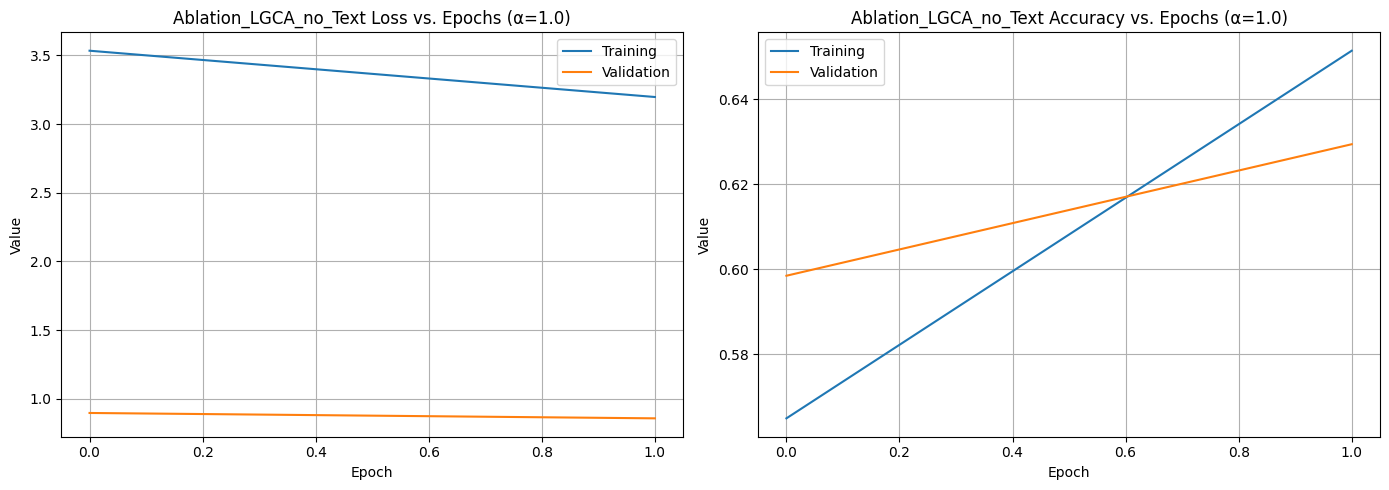

In [ ]:
# file: main_ablation_no_text.py

import torch
import gc
import os
import logging
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. ÂØºÂÖ•Êàë‰ª¨‰∏∫Ê∂àËûçÂÆûÈ™åÂàõÂª∫ÁöÑ *ÊâÄÊúâ* Êñ∞ÁªÑ‰ª∂ ---
from core.config import CONFIG, device
from contrastive.model import setup_memory_optimization

# [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: ÂØºÂÖ•Êñ∞ÁöÑÊ®°Âûã„ÄÅËÆ≠ÁªÉÂô®ÂíåÊï∞ÊçÆÂä†ËΩΩÂô®ÂáΩÊï∞
from contrastive.model import AcousticSupConModel
from contrastive.trainer import AblationNoTextTrainer
from scripts.get_dataloaders import get_ablation_no_text_dataloaders

# ÈÖçÁΩÆÊó•Âøó
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def run_ablation_no_text_experiment():
    """
    ÊâßË°åÂÆåÊï¥ÁöÑ "LGCA w/o Text Anchor" Ê∂àËûçÂÆûÈ™å„ÄÇ
    ËØ•ËÑöÊú¨ÊòØÁã¨Á´ãÁöÑÔºå‰∏ìÈó®Áî®‰∫éËÆ≠ÁªÉÁ∫ØÂ£∞Â≠¶ÁõëÁù£ÂØπÊØîÂ≠¶‰π†Ê®°Âûã„ÄÇ
    """
    # --- 2. ÁéØÂ¢ÉËÆæÁΩÆ (ËøôÈÉ®ÂàÜ‰∏é‰∏ªÂÆûÈ™åÂÆåÂÖ®Áõ∏ÂêåÔºåÁõ¥Êé•Â§çÁî®) ---
    try:
        CONFIG.load_config("config.yaml")
        logging.info("ÈÖçÁΩÆÊñá‰ª∂ 'config.yaml' Âä†ËΩΩÊàêÂäü„ÄÇ")
    except FileNotFoundError:
        logging.error("ÈîôËØØÔºöÊâæ‰∏çÂà∞ 'config.yaml' Êñá‰ª∂„ÄÇ")
        return

    # ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê‰ª•‰øùËØÅÂèØÂ§çÁé∞ÊÄß
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    setup_memory_optimization()
    torch.cuda.empty_cache()
    gc.collect()

    # --- 3. Âä†ËΩΩÊï∞ÊçÆÈõÜ (‰ΩøÁî®Êñ∞ÁöÑ‰∏ìÁî®Êï∞ÊçÆÂä†ËΩΩÂô®) ---
    try:
        training_dataset_name = CONFIG.training_dataset_name()
        logging.info(f"--- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ËÆ≠ÁªÉÈõÜ '{training_dataset_name}' ÂáÜÂ§áDataloaders ---")
        
        # [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: Ë∞ÉÁî®Êñ∞ÁöÑÊï∞ÊçÆÂä†ËΩΩÂáΩÊï∞
        dataloaders = get_ablation_no_text_dataloaders(training_dataset_name)
        train_loader = dataloaders['train']
        validation_loader = dataloaders['validation']
    except Exception as e:
        logging.error(f"Ê∂àËûçÂÆûÈ™åÊï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")
        return

    # --- 4. ÂÆû‰æãÂåñÊ®°ÂûãÂíåËÆ≠ÁªÉÂô® (‰ΩøÁî®Êñ∞ÁöÑ‰∏ìÁî®ÁªÑ‰ª∂) ---
    logging.info("--- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®ÂàùÂßãÂåñ AcousticSupConModel Âíå AblationNoTextTrainer ---")
    try:
        num_labels = len(CONFIG.dataset_emotions(training_dataset_name))
        
        # [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: ÂÆû‰æãÂåñÊñ∞ÁöÑÊ∂àËûçÊ®°Âûã
        model = AcousticSupConModel(num_labels=num_labels).to(device)

        # [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: ÂÆû‰æãÂåñÊñ∞ÁöÑÊ∂àËûçËÆ≠ÁªÉÂô®
        trainer = AblationNoTextTrainer(
            model=model,
            num_epochs=CONFIG.training_epochs(), # ‰ªéconfigËØªÂèñ
            learning_rate=CONFIG.learning_rate(),
            alpha=CONFIG.llgca_loss_alpha(), # ‰∏é‰∏ªÂÆûÈ™å‰ΩøÁî®Áõ∏ÂêåÁöÑalpha‰ª•‰øùËØÅÂÖ¨Âπ≥ÂØπÊØî
            optimizer_type=CONFIG.optimizer_type(),
            gradient_accumulation_steps=2 # Ê†πÊçÆ‰Ω†ÁöÑGPUÊòæÂ≠òË∞ÉÊï¥
        )

    except Exception as e:
        logging.error(f"Ê∂àËûçÂÆûÈ™åÁöÑÊ®°ÂûãÊàñËÆ≠ÁªÉÂô®ÂÆû‰æãÂåñÂ§±Ë¥•: {e}")
        return

    # --- 5. ÂºÄÂßãËÆ≠ÁªÉ ---
    logging.info(f"--- [Ê∂àËûçÂÆûÈ™å] ‰ΩøÁî® alpha = {trainer.alpha} ÂºÄÂßãÂú® '{training_dataset_name}' ‰∏äËøõË°åËÆ≠ÁªÉ ---")
    trainer.train(train_loader, validation_loader) 
    
    logging.info("--- Ê∂àËûçÊ®°ÂûãËÆ≠ÁªÉÂÆåÊàê ---")

    # Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞
    print("Âú®IEMOCAPÈ™åËØÅÈõÜ‰∏äËøõË°åËØÑ‰º∞...")
    iemocap_emotions = CONFIG.dataset_emotions(CONFIG.training_dataset_name())
    # evalÊñπÊ≥ïËøîÂõû‰∏â‰∏™ÂÄºÔºöuar, warÂíåÊ∑∑Ê∑ÜÁü©Èòµ
    eval_results = trainer.eval(validation_loader, labels=iemocap_emotions)

if __name__ == '__main__':
    run_ablation_no_text_experiment()

### È™åËØÅ

2025-10-10 17:24:14,954 - INFO - 
--- [Ê∂àËûçËØÑ‰º∞] Ê≠£Âú®Âä†ËΩΩÊµãËØïÊï∞ÊçÆÈõÜ ---


GPUÊÄªÂÜÖÂ≠ò: 8.59 GB
ÂÜÖÂ≠ò‰ºòÂåñËÆæÁΩÆÂÆåÊàê
--- [Ê∂àËûçÂÆûÈ™å] Ê≠£Âú®‰∏∫ 'CREMA-D' ÂáÜÂ§áÁ∫ØÂ£∞Â≠¶ÂØπÊØîÂ≠¶‰π† Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\CREMA-D\Preprocessed\crema-d_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ


2025-10-10 17:24:15,470 - INFO - Â∑≤Âä†ËΩΩ 'CREMA-D' Êï∞ÊçÆÈõÜÁî®‰∫é 'evaluation' ÂàíÂàÜ„ÄÇÂ§ßÂ∞è: 4900
2025-10-10 17:24:15,470 - INFO - ÊâæÂà∞‰∫Ü 3 ‰∏™Ê∂àËûçÊ£ÄÊü•ÁÇπÔºåÂ∞ÜÈÄê‰∏ÄËØÑ‰º∞„ÄÇ


[INFO] Èü≥È¢ëÁâπÂæÅÊèêÂèñÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
[INFO] Â∑≤‰∏∫ 'evaluation' ÂàíÂàÜÂàõÂª∫ Dataloader (‰ΩøÁî®Ê†áÂáÜÁöÑ EmotionDataset Âíå AudioDataCollator)„ÄÇ


ËØÑ‰º∞ÊâÄÊúâÊ∂àËûçÊ£ÄÊü•ÁÇπ:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\felix\AppData\Local\Temp\ipykernel_17116\3307021826.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

--- [Ê∂àËûç‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 1e-05, Head LR: 0.001 ---
[INFO] ÂàùÂßãÂåñ Ablation_LGCA_no_Text ËÆ≠ÁªÉÂô®ÂÆåÊàê„ÄÇÊ¢ØÂ∫¶Á¥ØÁßØ: 4, Alpha: 1.0


ËØÑ‰º∞ÊâÄÊúâÊ∂àËûçÊ£ÄÊü•ÁÇπ:  33%|‚ñà‚ñà‚ñà‚ñé      | 1/3 [00:32<01:05, 32.82s/it]

Accuracy (WAR): 0.4804
UAR: 0.4934


C:\Users\felix\AppData\Local\Temp\ipykernel_17116\3307021826.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locat

--- [Ê∂àËûç‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 1e-05, Head LR: 0.001 ---
[INFO] ÂàùÂßãÂåñ Ablation_LGCA_no_Text ËÆ≠ÁªÉÂô®ÂÆåÊàê„ÄÇÊ¢ØÂ∫¶Á¥ØÁßØ: 4, Alpha: 1.0


ËØÑ‰º∞ÊâÄÊúâÊ∂àËûçÊ£ÄÊü•ÁÇπ:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2/3 [01:02<00:30, 30.84s/it]

Accuracy (WAR): 0.4653
UAR: 0.4749


C:\Users\felix\AppData\Local\Temp\ipykernel_17116\3307021826.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locat

--- [Ê∂àËûç‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 1e-05, Head LR: 0.001 ---
[INFO] ÂàùÂßãÂåñ Ablation_LGCA_no_Text ËÆ≠ÁªÉÂô®ÂÆåÊàê„ÄÇÊ¢ØÂ∫¶Á¥ØÁßØ: 4, Alpha: 1.0


ËØÑ‰º∞ÊâÄÊúâÊ∂àËûçÊ£ÄÊü•ÁÇπ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [01:32<00:00, 30.35s/it]

Accuracy (WAR): 0.5173
UAR: 0.5103


ËØÑ‰º∞ÊâÄÊúâÊ∂àËûçÊ£ÄÊü•ÁÇπ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [01:32<00:00, 30.68s/it]


==================== Ê∂àËûçÂÆûÈ™åÊúÄÁªàÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûú ====================
                                        checkpoint  test_uar  test_war
2  Ablation_LGCA_no_Text_best_uar_model_epoch_3.pt  0.510310  0.517347
0  Ablation_LGCA_no_Text_best_uar_model_epoch_1.pt  0.493387  0.480408
1  Ablation_LGCA_no_Text_best_uar_model_epoch_2.pt  0.474869  0.465306

ËØÑ‰º∞ÁªìÊûúÂ∑≤‰øùÂ≠òËá≥: D:/Unitec/SER\tables\ablation_no_text_evaluation_results.csv


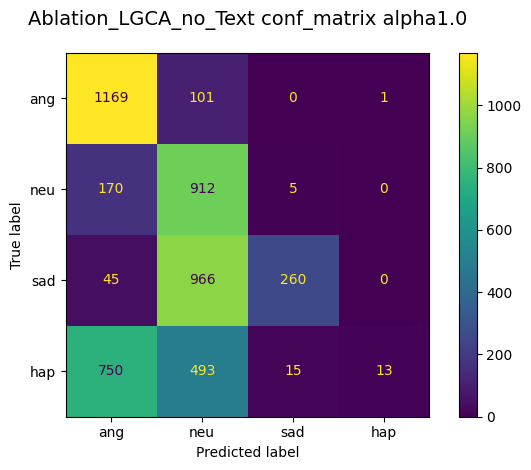

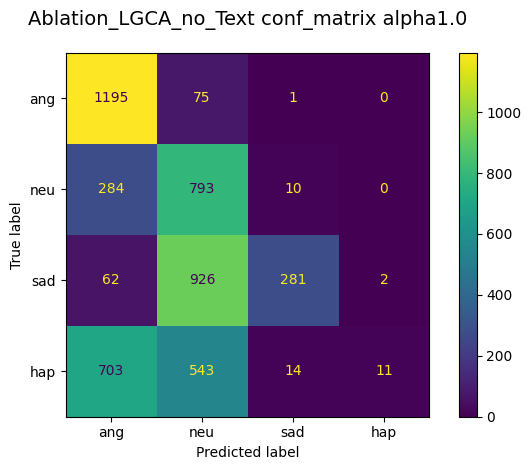

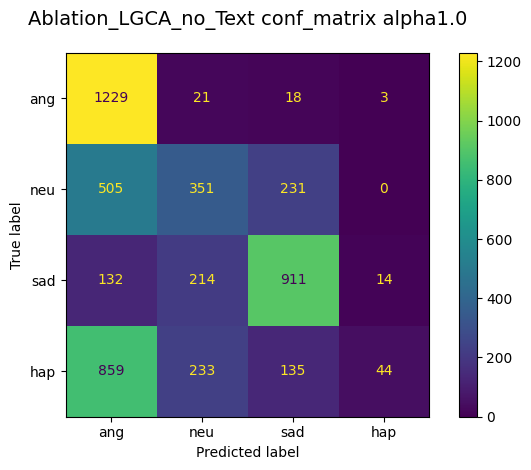

In [ ]:
# file: evaluate_ablation_checkpoints.py

import torch
import gc
import os
import logging
import pandas as pd
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. ÂØºÂÖ•‰∏éÊ∂àËûçÂÆûÈ™åÁõ∏ÂÖ≥ÁöÑÁªÑ‰ª∂ ---
from core.config import CONFIG, device
from contrastive.model import setup_memory_optimization

# [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: ÂØºÂÖ•Ê∂àËûçÂÆûÈ™åÁöÑÊ®°ÂûãÂíåËÆ≠ÁªÉÂô®
from contrastive.model import AcousticSupConModel 
from contrastive.trainer import AblationNoTextTrainer 

# [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: ÂØºÂÖ•Ê∂àËûçÂÆûÈ™åÁöÑÊï∞ÊçÆÂä†ËΩΩÂô®
from scripts.get_dataloaders import get_ablation_no_text_dataloaders 

def evaluate_no_text_ablation_checkpoints():
    """
    Âä†ËΩΩ 'checkpoints/' ÁõÆÂΩï‰∏ãÁöÑ *ÊâÄÊúâÊ∂àËûçÊ®°Âûã* Ê£ÄÊü•ÁÇπÔºåÂπ∂Âú®ÊµãËØïÈõÜ‰∏äËøõË°åËØÑ‰º∞„ÄÇ
    """
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    
    # --- 2. ÁéØÂ¢ÉÂíåÈÖçÁΩÆÂàùÂßãÂåñ (Â§çÁî®) ---
    setup_memory_optimization()
    CONFIG.load_config("config.yaml")

    # --- 3. Âä†ËΩΩÊµãËØïÊï∞ÊçÆÈõÜ ---
    logging.info("\n--- [Ê∂àËûçËØÑ‰º∞] Ê≠£Âú®Âä†ËΩΩÊµãËØïÊï∞ÊçÆÈõÜ ---")
    evaluation_dataset_name = CONFIG.evaluation_dataset_name()
    
    # [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: ‰ΩøÁî®Ê∂àËûçÊï∞ÊçÆÂä†ËΩΩÂô®Êù•Âä†ËΩΩËØÑ‰º∞Êï∞ÊçÆ
    # ËôΩÁÑ∂ÂÆÉ‰ºöÂ∫îÁî®Â¢ûÂº∫Ôºå‰ΩÜÂú®ËØÑ‰º∞Êó∂Ê®°ÂûãÂè™‰ºö‰ΩøÁî®Á¨¨‰∏Ä‰∏™ËæìÂÖ•ÔºåÊâÄ‰ª•ÁªìÊûúÊòØÊúâÊïàÁöÑ„ÄÇ
    cremad_loaders = get_ablation_no_text_dataloaders(evaluation_dataset_name)
    evaluation_loader = cremad_loaders['evaluation']
    cremad_emotions = CONFIG.dataset_emotions(evaluation_dataset_name)

    # --- 4. Êü•ÊâæÊâÄÊúâ *Ê∂àËûçÊ®°Âûã* ÁöÑÊ£ÄÊü•ÁÇπ ---
    checkpoint_dir = CONFIG.saved_ckpt_location()
    
    # [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: Á≠õÈÄâÂá∫Âè™Â±û‰∫éÊú¨Ê¨°Ê∂àËûçÂÆûÈ™åÁöÑÊ£ÄÊü•ÁÇπ (‰∏çÂå∫ÂàÜÂ§ßÂ∞èÂÜô)
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) 
                       if f.lower().startswith('ablation_lgca_no_text') and f.lower().endswith('.pt')]
    if not checkpoint_files:
        logging.error(f"Âú® '{checkpoint_dir}' ‰∏≠Ê≤°ÊúâÊâæÂà∞‰ªª‰ΩïÊ∂àËûçÊ®°ÂûãÊ£ÄÊü•ÁÇπ (‰ª• 'ablation_lgca_no_text' ÂºÄÂ§¥Ôºå‰∏çÂå∫ÂàÜÂ§ßÂ∞èÂÜô)„ÄÇ")
        return
    
    logging.info(f"ÊâæÂà∞‰∫Ü {len(checkpoint_files)} ‰∏™Ê∂àËûçÊ£ÄÊü•ÁÇπÔºåÂ∞ÜÈÄê‰∏ÄËØÑ‰º∞„ÄÇ")

    # --- 5. Âæ™ÁéØËØÑ‰º∞ÊØè‰∏™Ê£ÄÊü•ÁÇπ ---
    results_list = []
    num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))

    for checkpoint_file in tqdm(checkpoint_files, desc="ËØÑ‰º∞ÊâÄÊúâÊ∂àËûçÊ£ÄÊü•ÁÇπ"):
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        
        # [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: ÂÆû‰æãÂåñ‰∏Ä‰∏™ÂÖ®Êñ∞ÁöÑ *Ê∂àËûçÊ®°Âûã*
        model = AcousticSupConModel(num_labels=num_labels).to(device)
        
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        
        # [Ê†∏ÂøÉ‰øÆÊîπÁÇπ]: ÂÆû‰æãÂåñ‰∏Ä‰∏™ *Ê∂àËûçËÆ≠ÁªÉÂô®* ‰ª•‰ΩøÁî®ÂÖ∂ .eval() ÊñπÊ≥ï
        trainer = AblationNoTextTrainer(
            model=model, num_epochs=1, learning_rate=CONFIG.learning_rate(), alpha=CONFIG.llgca_loss_alpha(), optimizer_type=CONFIG.optimizer_type()
        )
        
        logging.info(f"\n--- Ê≠£Âú®ËØÑ‰º∞: {checkpoint_file} ---")
        # trainer.eval() ÊñπÊ≥ïÂ∑≤ÁªèË¢´Ê≠£Á°ÆÂú∞ÈáçÂÜôÔºåÂèØ‰ª•Â§ÑÁêÜÊñ∞ÁöÑÊï∞ÊçÆÂíåÊ®°Âûã
        test_uar, test_war = trainer.eval(evaluation_loader, labels=cremad_emotions)
        
        results_list.append({'checkpoint': checkpoint_file, 'test_uar': test_uar, 'test_war': test_war})
        
        del model, trainer
        gc.collect()
        torch.cuda.empty_cache()

    # --- 6. ÁªìÊûúÊ±áÊÄª‰∏éÂàÜÊûê (Â§çÁî®) ---
    results_df = pd.DataFrame(results_list).sort_values(by='test_uar', ascending=False)
    save_path = os.path.join(CONFIG.save_tables_location(), "ablation_no_text_evaluation_results.csv")
    results_df.to_csv(save_path, index=False)
    
    print("\n==================== Ê∂àËûçÂÆûÈ™åÊúÄÁªàÊµãËØïÈõÜËØÑ‰º∞ÁªìÊûú ====================")
    print(results_df)
    print(f"\nËØÑ‰º∞ÁªìÊûúÂ∑≤‰øùÂ≠òËá≥: {save_path}")

if __name__ == '__main__':
    evaluate_no_text_ablation_checkpoints()

In [ ]:
# train_ablation_no_text.py

import torch
import os
import gc
import numpy as np

# ÂØºÂÖ•ÊÇ®È°πÁõÆ‰∏≠ÁöÑÊ†∏ÂøÉÊ®°Âùó
from core.config import CONFIG, device
from scripts.get_dataloaders import get_contrastive_dataloaders
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer, AblationTrainer
from torch.utils.data import ConcatDataset # <-- ÂØºÂÖ•Áî®‰∫éÂêàÂπ∂Êï∞ÊçÆÈõÜÁöÑÂ∑•ÂÖ∑

# def train_ablation_lgca_model():
"""
ËÆ≠ÁªÉÂπ∂‰øùÂ≠òÊ∂àËûçÊ®°ÂûãA (LGCA w/o Label-Guidance)„ÄÇ
"""
print("--- [Ê∂àËûçÊ®°ÂûãAËÆ≠ÁªÉÂºÄÂßã (w/o Label-Guidance)] ---")

# 1. Âä†ËΩΩÈÖçÁΩÆ (‰∏é‰πãÂâçÂÆåÂÖ®‰∏ÄÊ†∑)
CONFIG.load_config("config.yaml")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# 2. Âä†ËΩΩÂπ∂ÂêàÂπ∂Êï∞ÊçÆÈõÜ (‰∏é‰πãÂâçÂÆåÂÖ®‰∏ÄÊ†∑)
print("Âä†ËΩΩÂπ∂ÂêàÂπ∂IEMOCAPËÆ≠ÁªÉÈõÜ‰∏éÈ™åËØÅÈõÜ...")
dataloaders = get_contrastive_dataloaders(
    CONFIG.training_dataset_name(), 
    mode = 'acoustic_supcon')# ÊòéÁ°ÆËØ∑Ê±ÇÁ∫ØÂ£∞Â≠¶Â¢ûÂº∫Êï∞ÊçÆÊ®°Âºè
train_dataset = dataloaders['train'].dataset
validation_dataset = dataloaders['validation'].dataset

full_train_dataset = ConcatDataset([dataloaders['train'].dataset, dataloaders['validation'].dataset])
full_train_loader = torch.utils.data.DataLoader(
    full_train_dataset,
    batch_size=CONFIG.dataloader_dict()['batch_size'],
    collate_fn=dataloaders['train'].collate_fn,
    num_workers=CONFIG.dataloader_dict()['num_workers'],
    shuffle=True
)
print(f"Êï∞ÊçÆÂáÜÂ§áÂÆåÊàê„ÄÇÊÄªËÆ≠ÁªÉÊ†∑Êú¨Êï∞: {len(full_train_dataset)}")

# 3. ÂàùÂßãÂåñÊ®°ÂûãÂíåËÆ≠ÁªÉÂô®
print("ÂàùÂßãÂåñÊ®°ÂûãÂíå„ÄêÊ∂àËûç„ÄëËÆ≠ÁªÉÂô®...")
num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
model = ContrastiveModel(num_labels=num_labels).to(device)

# *** ÂÖ≥ÈîÆ‰øÆÊîπÔºöÂÆû‰æãÂåñAblationTrainer ***
trainer = AblationTrainer(
    model=model,
    num_epochs=CONFIG.training_epochs(),
    learning_rate=CONFIG.learning_rate(),
    alpha=CONFIG.llgca_loss_alpha(), # alphaÂÄº‰øùÊåÅ‰∏çÂèòÔºå‰ª•‰ΩúÂÖ¨Âπ≥ÊØîËæÉ
    optimizer_type=CONFIG.optimizer_type(),
    gradient_accumulation_steps=4
)

# 4. ÊâßË°åËÆ≠ÁªÉ (‰∏é‰πãÂâçÂÆåÂÖ®‰∏ÄÊ†∑)
print(f"‰ΩøÁî®ÊúÄ‰ºò alpha = {trainer.alpha} ÂºÄÂßãÂú®ÂÆåÊï¥Êï∞ÊçÆ‰∏äËøõË°å„ÄêÊ∂àËûç„ÄëËÆ≠ÁªÉ...")
trainer.train(full_train_loader)
print("Ê∂àËûçÊ®°ÂûãËÆ≠ÁªÉÂÆåÊàê„ÄÇ")

# 5. ‰øùÂ≠òÊ®°ÂûãÊùÉÈáç
# *** ÂÖ≥ÈîÆ‰øÆÊîπÔºö‰ΩøÁî®Êñ∞ÁöÑÊñá‰ª∂Âêç‰øùÂ≠òÊ®°Âûã ***
model_save_path = os.path.join(
    CONFIG.saved_models_location(), 
    "lgca_ablation_no_text.pth" # <--- Êñ∞ÁöÑÊñá‰ª∂Âêç
)
torch.save(model.state_dict(), model_save_path)
print(f"Ê∂àËûçÊ®°ÂûãÂ∑≤ÊàêÂäü‰øùÂ≠òËá≥: {model_save_path}")

# # --- ËÑöÊú¨ÊâßË°åÂÖ•Âè£ ---
# if __name__ == '__main__':
#     train_ablation_lgca_model()



In [2]:
# Ë∞ÉËØï ContrastiveTrainer._get_logits_and_real ÊñπÊ≥ï

import torch
from core.config import CONFIG, device
from contrastive.model import MemoryOptimizedContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from scripts.get_dataloaders import get_contrastive_dataloaders

# Âä†ËΩΩÊï∞ÊçÆ
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
validation_loader = dataloaders['validation']

# ÂàõÂª∫Ê®°ÂûãÂíåËÆ≠ÁªÉÂô®
num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
model = MemoryOptimizedContrastiveModel(num_labels=num_labels).to(device)
trainer = ContrastiveTrainer(
    model=model,
    num_epochs=1,
    learning_rate=CONFIG.learning_rate(),
    alpha=0.1,
    optimizer_type=CONFIG.optimizer_type(),
    gradient_accumulation_steps=2
)

# ÊµãËØï _get_logits_and_real ÊñπÊ≥ï
first_batch = next(iter(validation_loader))
print(f"Batch keys: {list(first_batch.keys())}")

try:
    # ‰øÆÊîπËæìÂá∫ËµãÂÄºÊù•Ë∞ÉËØïËøîÂõûÁöÑÊï∞Èáè
    output = trainer._get_logits_and_real(first_batch)
    print(f"Return type: {type(output)}, Length: {len(output) if isinstance(output, tuple) else 'N/A'}")
    
    if isinstance(output, tuple):
        for i, item in enumerate(output):
            print(f"Item {i} type: {type(item)}, Shape: {item.shape if hasattr(item, 'shape') else 'N/A'}")
    
    # Â∞ùËØïÊ≠£Á°ÆÁöÑËß£ÂåÖÊñπÂºè
    logits, real = output
    print(f"ÊàêÂäüËß£ÂåÖ‰∏∫2‰∏™ÂÄº: logits shape = {logits.shape}, real shape = {real.shape}")
except ValueError as e:
    print(f"ValueError: {e}")
    # Â∞ùËØïËß£ÂåÖ‰∏∫3‰∏™ÂÄº
    try:
        a, b, c = output
        print(f"ÂèØ‰ª•Ëß£ÂåÖ‰∏∫3‰∏™ÂÄº: {type(a)}, {type(b)}, {type(c)}")
        print(f"Shapes: {a.shape if hasattr(a, 'shape') else 'N/A'}, {b.shape if hasattr(b, 'shape') else 'N/A'}, {c.shape if hasattr(c, 'shape') else 'N/A'}")
    except:
        print("‰πüÊó†Ê≥ïËß£ÂåÖ‰∏∫3‰∏™ÂÄº")
except Exception as e:
    print(f"ÂÖ∂‰ªñÈîôËØØ: {e}")

--- Ê≠£Âú®‰∏∫ 'IEMOCAP' ÂáÜÂ§áÂèåÊ®°ÊÄÅ Dataloaders ---
[INFO] Â∑≤‰ªé D:/Unitec/SER\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl Âä†ËΩΩÂéüÂßãÊï∞ÊçÆ‰ø°ÊÅØ„ÄÇ
[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
[INFO] Èü≥È¢ëÂíåÊñáÊú¨Â§ÑÁêÜÂô®ÂàùÂßãÂåñÂÆåÊàê„ÄÇ
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- Ê≠£Âú®ÂÜªÁªì WavLM ÁöÑ CNN Feature Extractor ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Embeddings ---
--- Ê≠£Âú®ÂÜªÁªì DeBERTa ÁöÑ Encoder Ââç 6 Â±Ç ---
--- ÁºñÁ†ÅÂô®ÂÜªÁªìÊìç‰ΩúÂÆåÊàê ---
--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 0.1
--- [‰ºòÂåñÂô®ÈÖçÁΩÆ] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] ‰ΩøÁî®Ê¢ØÂ∫¶Á¥ØÁßØÊ≠•Êï∞: 2, ÊçüÂ§±ÊùÉÈáç alpha: 0.1
Batch keys: ['audio_input_values', 'text_input_ids', 'text_attention_mask', 'labels']
Batch keys: ['audio_input_values', 'text_input_